# Recommender Systems - Mini Challenge HS25

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** Sunday of SW11 um 18:00 

## Guidelines for Implementation and Submiion
- Code must be written in Python. The versions of all used packages must be given for reproducability.
- You may respond in English or German.
- We develop numerous algorithms ourselves. Unle explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- All pathes must be relative and just downloading your repo must be executable without modifications.
- Only fully running code is graded. The notebook must run sequential from start to end.
- During development, if computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results must be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot must be accompanied by a brief discuion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discuion will be aeed.
- The last commit in your fork of the repo before the submiion deadline counts as the submiion.
- Points will be deducted if you write inconsise (Denial of service will be punished) or if I read text not written for me but for the user of ChatGPT oir similar. 
- If you would like to submit and have the mini-challenge aeed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submiion.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 

a) Describe the available data.

b) Find and fix bad data (e.g. duplicates, miing values, etc.).

Generate lists of

c) - Top 20 movies by average rating

d) - Top 20 movies by number of views

e) What is the range of the ratings? 

f) Which genre has be rated how many times?

g) How sparse is the User Rating Matrix?

Plot the following:

h) How many users have rated how many movies

i) Which rating is given how often over time with a time resolution of month 

j) Which rating is given how often per genre

k) The rating distributions of 10 random movies

l) The rating distributions of 3 movies that you have watched

m) How many users give which average rating

n) How often a movie was rated as a function of average rating

o) A heatmap of the User Item Matrix

p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import itertools

from surprise import SVD, Dataset, Reader
import umap
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the datasets
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

print("\nDataset shapes:")
print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")
print(f"Links: {links.shape}")
print(f"Tags: {tags.shape}")


/Users/husazwerg/code/gitlab.fhnw.ch/michelle.rohrer/recommender_systems/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-25 11:34:51.901051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Dataset shapes:
Ratings: (100836, 4)
Movies: (9742, 3)
Links: (9742, 3)
Tags: (3683, 4)


In [2]:
# a) Describe the available data
print("\n1. RATINGS DATASET:")
print(ratings.head())
print(f"\nColumns: {list(ratings.columns)}")
print(f"Data types:\n{ratings.dtypes}")
print(f"Basic statistics:\n{ratings.describe()}")

print("\n2. MOVIES DATASET:")
print(movies.head())
print(f"\nColumns: {list(movies.columns)}")
print(f"Data types:\n{movies.dtypes}")

print("\n3. LINKS DATASET:")
print(links.head())
print(f"\nColumns: {list(links.columns)}")
print(f"Data types:\n{links.dtypes}")

print("\n4. TAGS DATASET:")
print(tags.head())
print(f"\nColumns: {list(tags.columns)}")
print(f"Data types:\n{tags.dtypes}")

print("\n=== DATA OVERVIEW ===")
print(f"• Total ratings: {len(ratings):,}")
print(f"• Unique users: {ratings['userId'].nunique():,}")
print(f"• Unique movies: {ratings['movieId'].nunique():,}")
print(f"• Total movies in dataset: {len(movies):,}")
print(f"• Total tags: {len(tags):,}")
print(f"• Rating period: {datetime.fromtimestamp(ratings['timestamp'].min()).strftime('%Y-%m-%d')} to {datetime.fromtimestamp(ratings['timestamp'].max()).strftime('%Y-%m-%d')}")



1. RATINGS DATASET:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Columns: ['userId', 'movieId', 'rating', 'timestamp']
Data types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Basic statistics:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.0000

In [3]:
# b) Find and fix bad data
# 1. MIING VALUES ANALYSIS
print("\n1. MIING VALUES ANALYSIS:")
print("Ratings dataset:")
print(ratings.isnull().sum())
print("\nMovies dataset:")
print(movies.isnull().sum())
print("\nLinks dataset:")
print(links.isnull().sum())
print("\nTags dataset:")
print(tags.isnull().sum())

# 2. DUPLICATES ANALYSIS
print("\n2. DUPLICATES ANALYSIS:")
print(f"Duplicate ratings: {ratings.duplicated().sum()}")
print(f"Duplicate movies: {movies.duplicated().sum()}")
print(f"Duplicate links: {links.duplicated().sum()}")
print(f"Duplicate tags: {tags.duplicated().sum()}")
print(f"Duplicate user-movie ratings: {ratings.duplicated(subset=['userId', 'movieId']).sum()}")

# 3. DATA CONSISTENCY ANALYSIS
print("\n3. DATA CONSISTENCY ANALYSIS:")
movies_in_ratings_not_movies = set(ratings['movieId']) - set(movies['movieId'])
movies_in_movies_not_ratings = set(movies['movieId']) - set(ratings['movieId'])
print(f"Movies in ratings but not in movies: {len(movies_in_ratings_not_movies)}")
print(f"Movies in movies but not in ratings: {len(movies_in_movies_not_ratings)}")

# 4. INVALID DATA ANALYSIS
print("\n4. INVALID DATA ANALYSIS:")
invalid_ratings = ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)]
print(f"Invalid ratings (outside 0.5-5.0 range): {len(invalid_ratings)}")

movies_no_genres = movies[movies['genres'] == '(no genres listed)']
print(f"Movies with no genres: {movies_no_genres.shape[0]}")

# Check for negative user IDs or movie IDs
negative_user_ids = ratings[ratings['userId'] <= 0]
negative_movie_ids = ratings[ratings['movieId'] <= 0]
print(f"Negative user IDs: {len(negative_user_ids)}")
print(f"Negative movie IDs: {len(negative_movie_ids)}")

# Check for invalid timestamps
# Dataset range: March 29, 1996 to September 24, 2018 (created September 26, 2018)
MIN_TIMESTAMP = 828057600 
MAX_TIMESTAMP = 1538006399 
invalid_timestamps = ratings[(ratings['timestamp'] < MIN_TIMESTAMP) | (ratings['timestamp'] > MAX_TIMESTAMP)]
print(f"Invalid timestamps: {len(invalid_timestamps)}")

# 5. COMPREHENSIVE DATA CLEANING
# Store original sizes
original_ratings_size = len(ratings)
original_movies_size = len(movies)
original_links_size = len(links)
original_tags_size = len(tags)

# Clean ratings data
# Remove invalid ratings
if len(invalid_ratings) > 0:
    ratings = ratings[~((ratings['rating'] < 0.5) | (ratings['rating'] > 5.0))]
    print(f"Removed {len(invalid_ratings)} invalid ratings")

# Remove negative user/movie IDs
if len(negative_user_ids) > 0:
    ratings = ratings[ratings['userId'] > 0]
    print(f"Removed {len(negative_user_ids)} ratings with negative user IDs")

if len(negative_movie_ids) > 0:
    ratings = ratings[ratings['movieId'] > 0]
    print(f"Removed {len(negative_movie_ids)} ratings with negative movie IDs")

# Remove invalid timestamps
if len(invalid_timestamps) > 0:
    ratings = ratings[~((ratings['timestamp'] < MIN_TIMESTAMP) | (ratings['timestamp'] > MAX_TIMESTAMP))]
    print(f"Removed {len(invalid_timestamps)} ratings with invalid timestamps")

# Remove duplicate user-movie ratings (keep the latest one)
if ratings.duplicated(subset=['userId', 'movieId']).sum() > 0:
    print("Removing duplicate user-movie ratings (keeping latest)...")
    ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId'], keep='last')
    print(f"Removed {original_ratings_size - len(ratings)} duplicate ratings")

# Clean movies data
# movies with no genre to NAN
movies['genres'] = movies['genres'].replace('(no genres listed)', np.nan)

# Remove duplicate movies
if movies.duplicated().sum() > 0:
    movies = movies.drop_duplicates()
    print(f"Removed {original_movies_size - len(movies)} duplicate movies")

# Clean links data
# Remove duplicate links
if links.duplicated().sum() > 0:
    links = links.drop_duplicates()
    print(f"Removed {original_links_size - len(links)} duplicate links")

# Clean tags data
# Remove duplicate tags
if tags.duplicated().sum() > 0:
    tags = tags.drop_duplicates()
    print(f"Removed {original_tags_size - len(tags)} duplicate tags")

# Remove tags for movies that don't exist in movies dataset
tags_before = len(tags)
tags = tags[tags['movieId'].isin(movies['movieId'])]
print(f"Removed {tags_before - len(tags)} tags for non-existent movies")

# Remove tags from users that don't exist in ratings
tags_before = len(tags)
tags = tags[tags['userId'].isin(ratings['userId'])]
print(f"Removed {tags_before - len(tags)} tags from non-existent users")

# 6. FINAL DATA CONSISTENCY CHECK
print("\n6. FINAL DATA:")

# Remove ratings for movies that don't exist in movies dataset
ratings_before = len(ratings)
ratings = ratings[ratings['movieId'].isin(movies['movieId'])]
print(f"Removed {ratings_before - len(ratings)} ratings for non-existent movies")

# Remove movies that have no ratings
movies_before = len(movies)
movies = movies[movies['movieId'].isin(ratings['movieId'])]
print(f"Removed {movies_before - len(movies)} movies with no ratings")

# Remove links for movies that don't exist in movies dataset
links_before = len(links)
links = links[links['movieId'].isin(movies['movieId'])]
print(f"Removed {links_before - len(links)} links for non-existent movies")

# Convert timestamp to datetime for easier analysis
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')


1. MIING VALUES ANALYSIS:
Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

2. DUPLICATES ANALYSIS:
Duplicate ratings: 0
Duplicate movies: 0
Duplicate links: 0
Duplicate tags: 0
Duplicate user-movie ratings: 0

3. DATA CONSISTENCY ANALYSIS:
Movies in ratings but not in movies: 0
Movies in movies but not in ratings: 18

4. INVALID DATA ANALYSIS:
Invalid ratings (outside 0.5-5.0 range): 0
Movies with no genres: 34
Negative user IDs: 0
Negative movie IDs: 0
Invalid timestamps: 0
Removed 0 tags for non-existent movies
Removed 0 tags from non-existent users

6. FINAL DATA:
Removed 0 ratings for non-existent movies
Removed 18 movies with no ratings
Removed 18 links for non-existent movies


In [4]:
# c) Top 20 movies by average rating

# Merge ratings with movies to get movie titles
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['mean', 'count'],
    'userId': 'count'
}).round(3)

movie_stats.columns = ['avg_rating', 'rating_count', 'user_count']
movie_stats = movie_stats.reset_index()

# Merge with movie information
movie_stats = movie_stats.merge(movies[['movieId', 'title', 'genres']], on='movieId')

# Filter movies with at least 50 ratings to avoid bias from movies with very few ratings
min_ratings = 50
top_movies_by_rating = movie_stats[movie_stats['rating_count'] >= min_ratings].sort_values('avg_rating', ascending=False).head(20)

print("=== TOP 20 MOVIES BY AVERAGE RATING (min 50 ratings) ===")
for idx, row in top_movies_by_rating.iterrows():
    print(f"{row['avg_rating']:.3f} - {row['title']} ({row['rating_count']} ratings)")

=== TOP 20 MOVIES BY AVERAGE RATING (min 50 ratings) ===
4.429 - Shawshank Redemption, The (1994) (317 ratings)
4.289 - Godfather, The (1972) (192 ratings)
4.273 - Fight Club (1999) (218 ratings)
4.272 - Cool Hand Luke (1967) (57 ratings)
4.268 - Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (97 ratings)
4.262 - Rear Window (1954) (84 ratings)
4.260 - Godfather: Part II, The (1974) (129 ratings)
4.252 - Departed, The (2006) (107 ratings)
4.250 - Goodfellas (1990) (126 ratings)
4.240 - Casablanca (1942) (100 ratings)
4.238 - Dark Knight, The (2008) (149 ratings)
4.238 - Usual Suspects, The (1995) (204 ratings)
4.232 - Princess Bride, The (1987) (142 ratings)
4.231 - Star Wars: Episode IV - A New Hope (1977) (251 ratings)
4.225 - Schindler's List (1993) (220 ratings)
4.220 - Apocalypse Now (1979) (107 ratings)
4.217 - American History X (1998) (129 ratings)
4.216 - Star Wars: Episode V - The Empire Strikes Back (1980) (211 ratings)
4.212 - Chinatown (1974) (

In [5]:
# d) Top 20 movies by number of views (ratings)

top_movies_by_views = movie_stats.sort_values('rating_count', ascending=False).head(20)

print("=== TOP 20 MOVIES BY NUMBER OF RATINGS ===")
for idx, row in top_movies_by_views.iterrows():
    print(f"{row['rating_count']} ratings - {row['title']} (avg: {row['avg_rating']:.3f})")


=== TOP 20 MOVIES BY NUMBER OF RATINGS ===
329 ratings - Forrest Gump (1994) (avg: 4.164)
317 ratings - Shawshank Redemption, The (1994) (avg: 4.429)
307 ratings - Pulp Fiction (1994) (avg: 4.197)
279 ratings - Silence of the Lambs, The (1991) (avg: 4.161)
278 ratings - Matrix, The (1999) (avg: 4.192)
251 ratings - Star Wars: Episode IV - A New Hope (1977) (avg: 4.231)
238 ratings - Jurassic Park (1993) (avg: 3.750)
237 ratings - Braveheart (1995) (avg: 4.032)
224 ratings - Terminator 2: Judgment Day (1991) (avg: 3.971)
220 ratings - Schindler's List (1993) (avg: 4.225)
218 ratings - Fight Club (1999) (avg: 4.273)
215 ratings - Toy Story (1995) (avg: 3.921)
211 ratings - Star Wars: Episode V - The Empire Strikes Back (1980) (avg: 4.216)
204 ratings - Usual Suspects, The (1995) (avg: 4.238)
204 ratings - American Beauty (1999) (avg: 4.056)
203 ratings - Seven (a.k.a. Se7en) (1995) (avg: 3.975)
202 ratings - Independence Day (a.k.a. ID4) (1996) (avg: 3.446)
201 ratings - Apollo 13 (1995)

In [6]:
# e) What is the range of the ratings?

print("=== RATING RANGE ANALYSIS ===")
print(f"Minimum rating: {ratings['rating'].min()}")
print(f"Maximum rating: {ratings['rating'].max()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Unique rating values: {sorted(ratings['rating'].unique())}")
print(f"Number of unique rating values: {ratings['rating'].nunique()}")

# Rating distribution
print("\nRating distribution:")
rating_dist = ratings['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(ratings)) * 100
    print(f"Rating {rating}: {count:,} ratings ({percentage:.1f}%)")


=== RATING RANGE ANALYSIS ===
Minimum rating: 0.5
Maximum rating: 5.0
Rating range: 0.5 to 5.0
Unique rating values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Number of unique rating values: 10

Rating distribution:
Rating 0.5: 1,370 ratings (1.4%)
Rating 1.0: 2,811 ratings (2.8%)
Rating 1.5: 1,791 ratings (1.8%)
Rating 2.0: 7,551 ratings (7.5%)
Rating 2.5: 5,550 ratings (5.5%)
Rating 3.0: 20,047 ratings (19.9%)
Rating 3.5: 13,136 ratings (13.0%)
Rating 4.0: 26,818 ratings (26.6%)
Rating 4.5: 8,551 ratings (8.5%)
Rating 5.0: 13,211 ratings (13.1%)


In [7]:
# f) Which genre has been rated how many times?

movie_genres = movies.copy()
movie_genres['genres_list'] = movie_genres['genres'].str.split('|')
movie_genres = movie_genres.explode('genres_list')
movie_genres['genre'] = movie_genres['genres_list']

# Merge with ratings to get rating counts per genre
genre_ratings = ratings.merge(movie_genres[['movieId', 'genre']], on='movieId')

# Count ratings per genre
genre_stats = genre_ratings.groupby('genre').agg({
    'rating': ['count', 'mean'],
    'userId': 'nunique'
}).round(3)

genre_stats.columns = ['total_ratings', 'avg_rating', 'unique_users']
genre_stats = genre_stats.sort_values('total_ratings', ascending=False)

print(f"{'Genre':<20} {'Total Ratings':<15} {'Avg Rating':<12} {'Unique Users':<15}")
print("-" * 65)
for genre, row in genre_stats.iterrows():
    print(f"{genre:<20} {row['total_ratings']:<15,} {row['avg_rating']:<12.3f} {row['unique_users']:<15,}")

print(f"\nTotal ratings analyzed: {genre_stats['total_ratings'].sum():,}")
print(f"Some ratings may be counted multiple times if a movie has multiple genres.")


Genre                Total Ratings   Avg Rating   Unique Users   
-----------------------------------------------------------------
Drama                41,928.0        3.656        610.0          
Comedy               39,053.0        3.385        609.0          
Action               30,635.0        3.448        608.0          
Thriller             26,452.0        3.494        609.0          
Adventure            24,161.0        3.509        606.0          
Romance              18,124.0        3.507        606.0          
Sci-Fi               17,243.0        3.456        605.0          
Crime                16,681.0        3.658        603.0          
Fantasy              11,834.0        3.491        583.0          
Children             9,208.0         3.413        559.0          
Mystery              7,674.0         3.632        580.0          
Horror               7,291.0         3.258        535.0          
Animation            6,988.0         3.630        527.0          
War       

In [8]:
# g) How sparse is the User Rating Matrix?

# Create user-item matrix to analyze sparsity
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

print("=== USER RATING MATRIX SPARSITY ANALYSIS ===")
print(f"Matrix shape: {user_item_matrix.shape} (users x movies)")
print(f"Total possible ratings: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"Actual ratings: {ratings.shape[0]:,}")
print(f"Missing ratings: {(user_item_matrix.shape[0] * user_item_matrix.shape[1]) - ratings.shape[0]:,}")

# Calculate sparsity
sparsity = 1 - (ratings.shape[0] / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Density: {1-sparsity:.4f} ({(1-sparsity)*100:.2f}%)")

# Additional sparsity insights
print(f"\nSparsity insights:")
print(f"• Average ratings per user: {ratings.shape[0] / user_item_matrix.shape[0]:.1f}")
print(f"• Average ratings per movie: {ratings.shape[0] / user_item_matrix.shape[1]:.1f}")
print(f"• Users with most ratings: {ratings.groupby('userId').size().max()}")
print(f"• Movies with most ratings: {ratings.groupby('movieId').size().max()}")
print(f"• Users with fewest ratings: {ratings.groupby('userId').size().min()}")
print(f"• Movies with fewest ratings: {ratings.groupby('movieId').size().min()}")


=== USER RATING MATRIX SPARSITY ANALYSIS ===
Matrix shape: (610, 9724) (users x movies)
Total possible ratings: 5,931,640
Actual ratings: 100,836
Missing ratings: 5,830,804
Sparsity: 0.9830 (98.30%)
Density: 0.0170 (1.70%)

Sparsity insights:
• Average ratings per user: 165.3
• Average ratings per movie: 10.4
• Users with most ratings: 2698
• Movies with most ratings: 329
• Users with fewest ratings: 20
• Movies with fewest ratings: 1


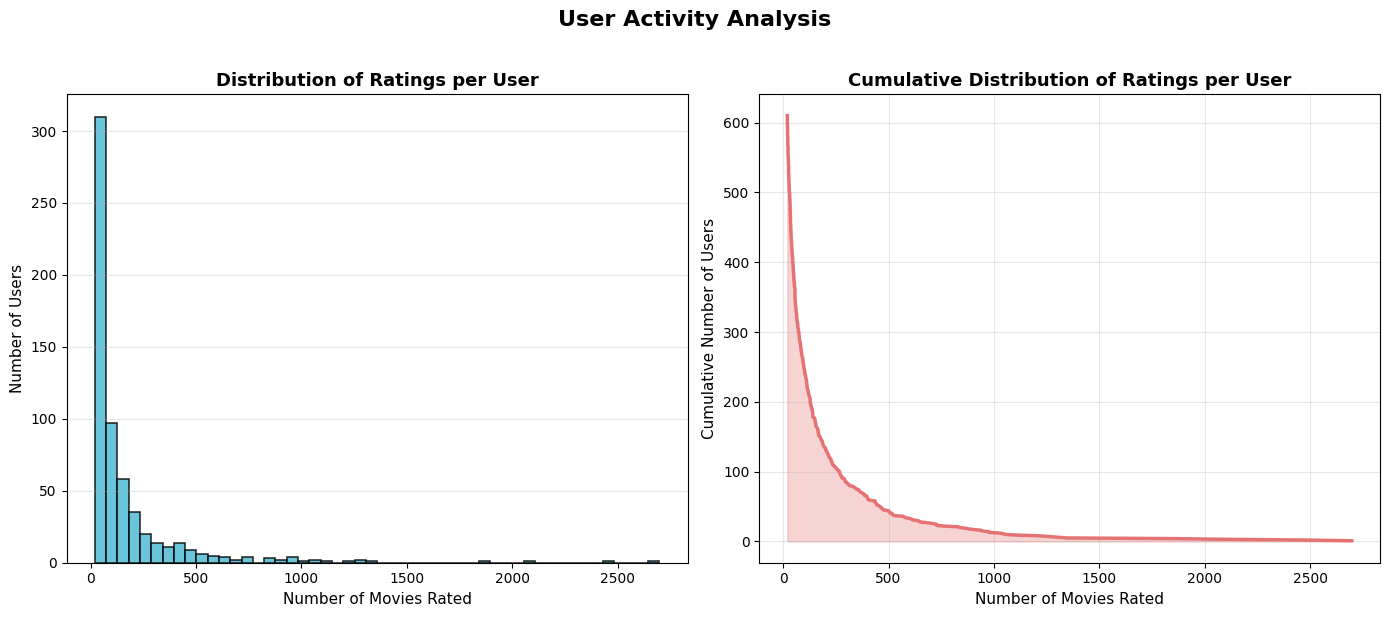

User rating statistics:
• Min ratings per user: 20
• Max ratings per user: 2698
• Mean ratings per user: 165.3
• Median ratings per user: 70.5
• Std ratings per user: 269.5

Top 10 users by number of ratings:
 1. User 414: 2698 ratings
 2. User 599: 2478 ratings
 3. User 474: 2108 ratings
 4. User 448: 1864 ratings
 5. User 274: 1346 ratings
 6. User 610: 1302 ratings
 7. User 68: 1260 ratings
 8. User 380: 1218 ratings
 9. User 606: 1115 ratings
10. User 288: 1055 ratings


In [9]:
# h) Plot: How many users have rated how many movies
# Calculate ratings per user
user_rating_counts = ratings.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(14, 6))

# Plot 1: Histogram of ratings per user
plt.subplot(1, 2, 1)
plt.hist(user_rating_counts, bins=50, alpha=0.8, color='#45B7D1', edgecolor='black', linewidth=1.2)
plt.xlabel('Number of Movies Rated', fontsize=11)
plt.ylabel('Number of Users', fontsize=11)
plt.title('Distribution of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative distribution
plt.subplot(1, 2, 2)
sorted_counts = user_rating_counts.sort_values(ascending=False)
cumulative_users = np.arange(1, len(sorted_counts) + 1)
plt.plot(sorted_counts.values, cumulative_users, linewidth=2.5, color='#E57373')
plt.fill_between(sorted_counts.values, cumulative_users, alpha=0.3, color='#E57373')
plt.xlabel('Number of Movies Rated', fontsize=11)
plt.ylabel('Cumulative Number of Users', fontsize=11)
plt.title('Cumulative Distribution of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('User Activity Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"User rating statistics:")
print(f"• Min ratings per user: {user_rating_counts.min()}")
print(f"• Max ratings per user: {user_rating_counts.max()}")
print(f"• Mean ratings per user: {user_rating_counts.mean():.1f}")
print(f"• Median ratings per user: {user_rating_counts.median():.1f}")
print(f"• Std ratings per user: {user_rating_counts.std():.1f}")

print(f"\nTop 10 users by number of ratings:")
for i, (user_id, count) in enumerate(user_rating_counts.head(10).items(), 1):
    print(f"{i:2d}. User {user_id}: {count} ratings")

#### Distribution of Ratings per User
**Beschreibung:**
Das Histogramm zeigt die Verteilung der Anzahl bewerteter Filme pro Benutzer. Die x-Achse repräsentiert die Anzahl der bewerteten Filme, die y-Achse die Anzahl der Benutzer.

**Beobachtungen:**
- Extrem rechtsschiefer (positiv schiefer) Verteilung mit ausgeprägtem "long tail"
- Der höchste Balken liegt bei sehr niedrigen Bewertungszahlen (0-100 Filme)
- Etwa 310 Benutzer haben nur zwischen 20-100 Filme bewertet
- Nur sehr wenige Benutzer haben mehr als 500 Filme bewertet
- Die Verteilung fällt exponentiell ab

**Interpretation:**
Diese Verteilung ist charakteristisch für das sogenannte "Power-Law-Verhalten" in User-Generated-Content-Systemen. Die Mehrheit der Benutzer sind passive oder gelegentliche Nutzer ("lurkers"), während eine kleine Minderheit sehr aktiv ist. Dieses Phänomen wird auch als "90-9-1-Regel" bezeichnet: 90% konsumieren nur, 9% tragen gelegentlich bei, 1% sind sehr aktive Beitragende.

#### Cumulative Distribution of Ratings per User
**Beschreibung:**
Die kumulative Verteilung zeigt, wie viele Benutzer maximal eine bestimmte Anzahl von Filmen bewertet haben. Die y-Achse zeigt die kumulative Anzahl der Benutzer.

**Beobachtungen:**
- Sehr steiler Anstieg zu Beginn (bei 0-200 Bewertungen)
- Etwa 600 von 610 Benutzern haben weniger als 500 Filme bewertet
- Nach 500 Bewertungen flacht die Kurve stark ab
- Die Kurve erreicht ein Plateau bei etwa 610 Benutzern (Gesamtanzahl)

**Interpretation:**
Die kumulative Darstellung verdeutlicht noch stärker die Konzentration der Benutzer im unteren Bewertungsbereich. Ungefähr 50% aller Benutzer haben bereits bei etwa 70 Bewertungen (Median) ihr Maximum erreicht. Dies bedeutet, dass die Hälfte aller Benutzer nur sehr begrenzt zum Datensatz beiträgt.

#### Key Insights

- **Data Sparsity:** User-Item-Matrix ist extrem dünn besetzt (Median: 70 Ratings), erschwert User-based Collaborative Filtering
- **Cold Start:** Neue User starten mit wenigen Ratings - hybride Ansätze (Content + Collaborative) sind essentiell
- **Power User Bias:** Top 1% (>1000 Ratings) könnten Modell verzerren - User-Gewichtung beim Training notwendig
- **Evaluation:** Separate Metriken für Light/Medium/Heavy Users erforderlich, da Durchschnitt irreführend sein kann

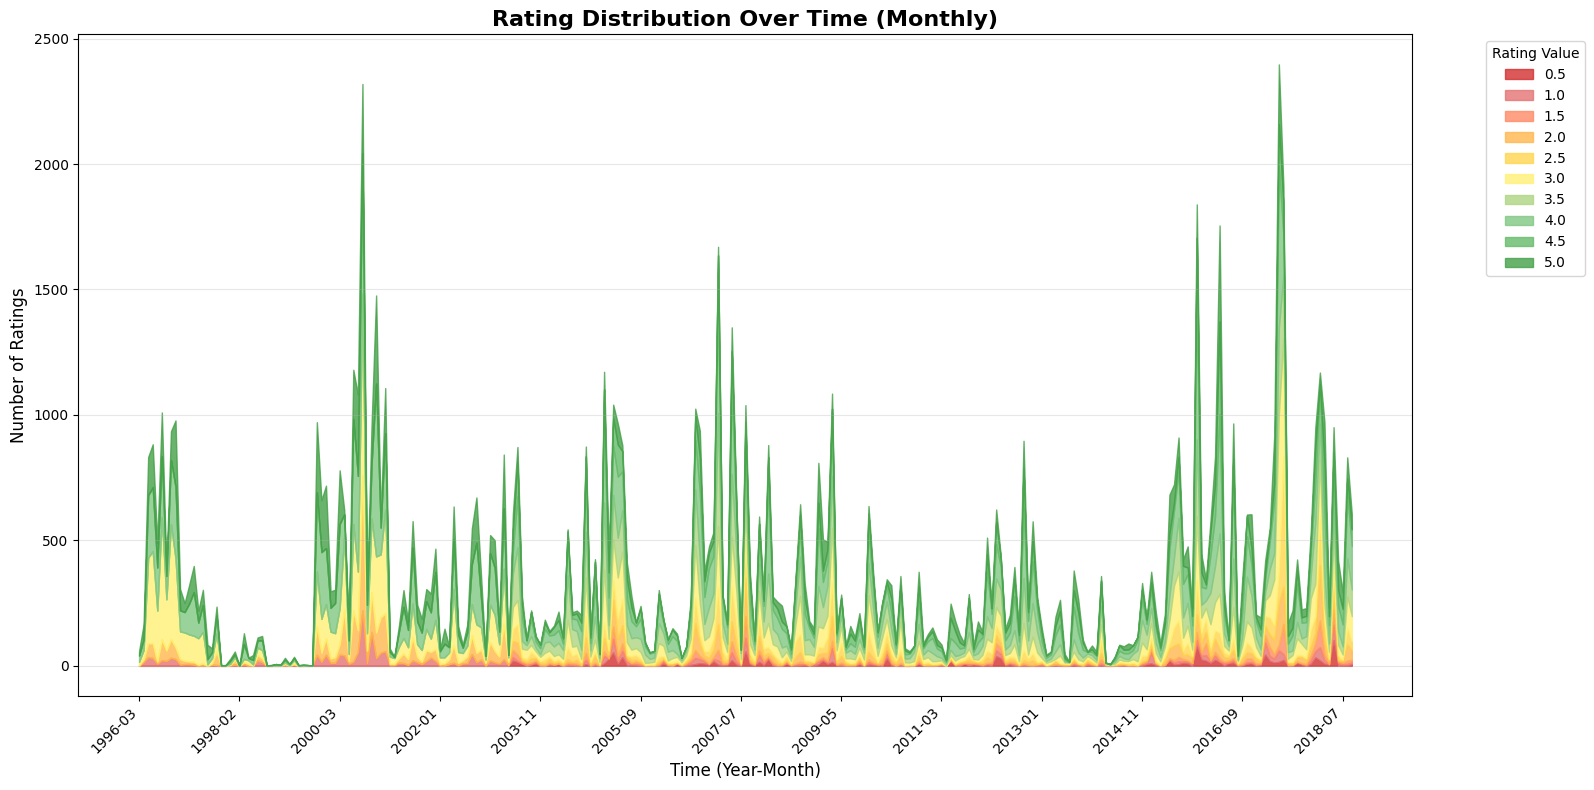

Monthly rating trends analysis:
• Dataset spans from 1996-03 to 2018-09
• Total months with data: 267
• Average ratings per month: 377.7

Top 5 months with most ratings:
• 2017-05: 2,397 ratings
• 2000-08: 2,319 ratings
• 2017-06: 1,910 ratings
• 2015-11: 1,839 ratings
• 2016-04: 1,755 ratings

Top 5 months with fewest ratings:
• 1997-10: 1 ratings
• 1998-02: 1 ratings
• 1998-10: 1 ratings
• 1999-09: 1 ratings
• 1999-06: 3 ratings


In [10]:
# i) Plot: Which rating is given how often over time with monthly resolution

# Add year-month column for time analysis
ratings['year_month'] = ratings['datetime'].dt.to_period('M')

# Count ratings by month and rating value
monthly_ratings = ratings.groupby(['year_month', 'rating']).size().unstack(fill_value=0)

# Ensure we have all rating values (0.5 to 5.0 in steps of 0.5)
all_ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for rating in all_ratings:
    if rating not in monthly_ratings.columns:
        monthly_ratings[rating] = 0

# Sort columns by rating value
monthly_ratings = monthly_ratings[sorted(monthly_ratings.columns)]

plt.figure(figsize=(16, 8))

# Custom color palette for ratings (from low to high)
rating_colors = {
    0.5: '#D32F2F', # Dunkles Rot
    1.0: '#E57373', # Mittleres Rot
    1.5: '#FF8A65', # Rot-Orange
    2.0: '#FFB74D', # Orange
    2.5: '#FFD54F', # Gelb-Orange
    3.0: '#FFF176', # Helles Gelb
    3.5: '#AED581', # Gelbgrün
    4.0: '#81C784', # Hellgrün
    4.5: '#66BB6A', # Mittelgrün
    5.0: '#43A047'  # Dunkelgrün
}

# Create the stacked area plot
x_values = range(len(monthly_ratings))
bottom = np.zeros(len(monthly_ratings))

for rating in monthly_ratings.columns:
    color = rating_colors.get(rating, '#CCCCCC')
    plt.fill_between(x_values, bottom, bottom + monthly_ratings[rating],
                     color=color, alpha=0.8, label=f'{rating}')
    bottom += monthly_ratings[rating]

plt.title('Rating Distribution Over Time (Monthly)', fontsize=16, fontweight='bold')
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

# Set x-axis labels
step = max(1, len(monthly_ratings) // 12)  # Zeige ca. 12 Labels
x_positions = range(0, len(monthly_ratings), step)
x_labels = [str(monthly_ratings.index[i]) for i in x_positions]
plt.xticks(x_positions, x_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Monthly rating trends analysis:")
print(f"• Dataset spans from {ratings['year_month'].min()} to {ratings['year_month'].max()}")
print(f"• Total months with data: {ratings['year_month'].nunique()}")
print(f"• Average ratings per month: {len(ratings) / ratings['year_month'].nunique():.1f}")

# Show some monthly statistics
monthly_totals = monthly_ratings.sum(axis=1)
print(f"\nTop 5 months with most ratings:")
for month, count in monthly_totals.nlargest(5).items():
    print(f"• {month}: {count:,} ratings")

print(f"\nTop 5 months with fewest ratings:")
for month, count in monthly_totals.nsmallest(5).items():
    print(f"• {month}: {count:,} ratings")

#### Beschreibung des Plots
Das gestapelte Flächendiagramm zeigt die zeitliche Entwicklung der Bewertungsaktivität von März 1996 bis September 2018. Die Farben repräsentieren Rating-Werte (0.5-5.0 Sterne), die Gesamthöhe zeigt alle Bewertungen pro Monat.

#### Zeitliche Phasen der Aktivität

**Frühe Jahre (1996-1999):** Sehr geringe, sporadische Aktivität (1-3 Ratings/Monat) - Testphase oder limitierter Zugang

**Erste Wachstumsphase (2000-2002):** Deutlicher Anstieg, Peak im August 2000 (2,319 Bewertungen) - möglicher Launch/Relaunch der Plattform

**Konsolidierung (2003-2014):** Stabile, moderate Aktivität (200-600 Ratings/Monat) - etablierte Nutzerbasis

**Zweite Wachstumsphase (2015-2017):** Höchster Peak im Mai 2017 (2,397 Bewertungen) - möglicherweise durch Mobile Apps, Social Media Integration oder Streaming-Boom

**Rückgang (2017-2018):** Abnehmende Aktivität nach Peak - natürliche Sättigung oder Konkurrenz

#### Verteilung der Rating-Werte

**Positivity Bias:** Grüne Töne (4.0-5.0) dominieren durchgehend - Nutzer bewerten primär Filme, die sie mögen

**Proportionale Stabilität:** Rating-Verteilung bleibt über die Zeit konstant - neue Nutzer zeigen ähnliche Bewertungsmuster


#### Key Insights

- **Temporal Bias:** Training/Test-Split muss zeitlich getrennt sein - Modelle kennen keine zukünftigen Muster
- **Data Availability:** 1996-1999 zu wenig Daten, 2015-2017 optimal für Training, 2018 potentiell unvollständig
- **Positivity Bias:** Dominanz hoher Ratings (4-5 Sterne) erschwert Differenzierung zwischen "gut" und "sehr gut"
- **Concept Drift:** Nutzerpräferenzen ändern sich über 22 Jahre - neueren Daten mehr Gewicht geben

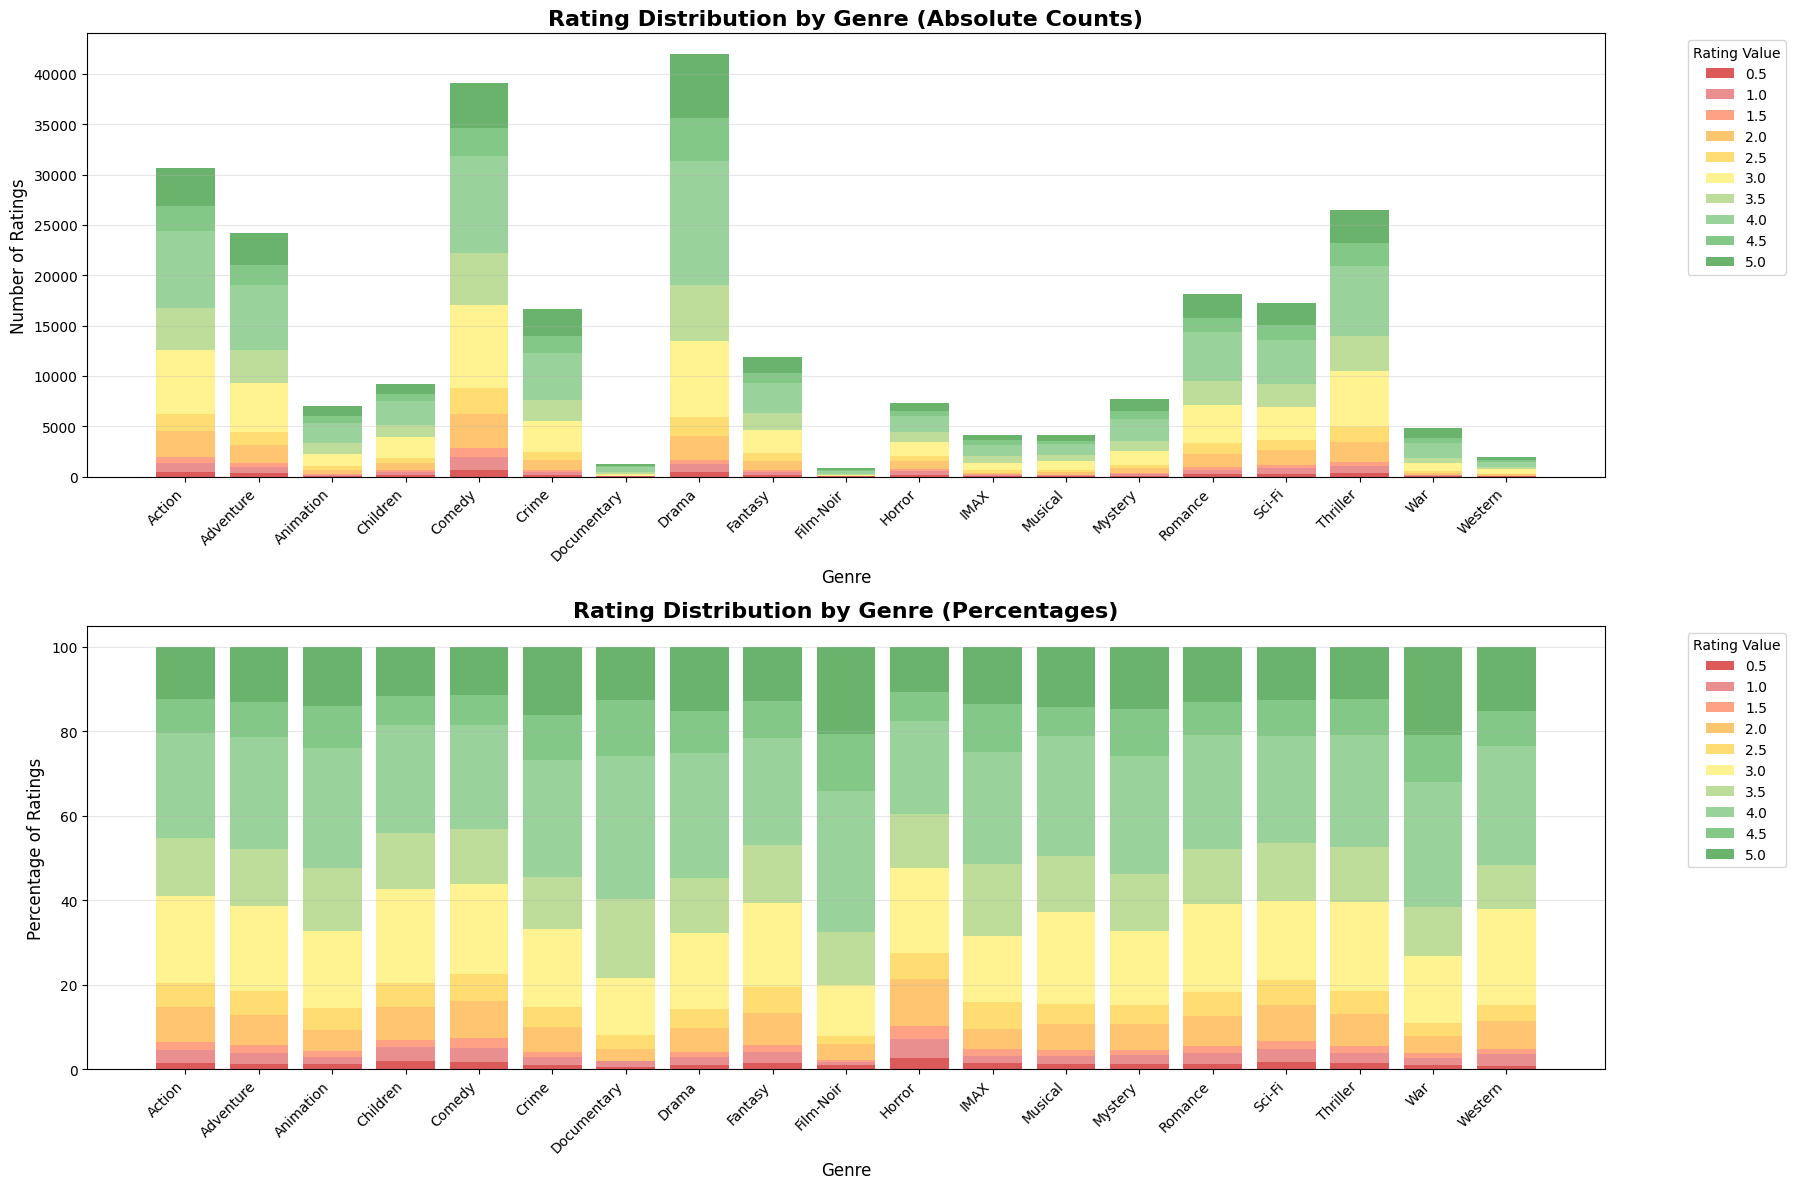

Genre rating analysis:

Average rating by genre:
• Film-Noir           : 3.920 (from 870 ratings)
• War                 : 3.808 (from 4,859 ratings)
• Documentary         : 3.798 (from 1,219 ratings)
• Crime               : 3.658 (from 16,681 ratings)
• Drama               : 3.656 (from 41,928 ratings)
• Mystery             : 3.632 (from 7,674 ratings)
• Animation           : 3.630 (from 6,988 ratings)
• IMAX                : 3.618 (from 4,145 ratings)
• Western             : 3.584 (from 1,930 ratings)
• Musical             : 3.564 (from 4,138 ratings)
• Adventure           : 3.509 (from 24,161 ratings)
• Romance             : 3.507 (from 18,124 ratings)
• Thriller            : 3.494 (from 26,452 ratings)
• Fantasy             : 3.491 (from 11,834 ratings)
• Sci-Fi              : 3.456 (from 17,243 ratings)
• Action              : 3.448 (from 30,635 ratings)
• Children            : 3.413 (from 9,208 ratings)
• Comedy              : 3.385 (from 39,053 ratings)
• Horror              : 3.

In [11]:
# j) Plot: Which rating is given how often per genre
# Use the genre_ratings data we created earlier
genre_rating_dist = genre_ratings.groupby(['genre', 'rating']).size().unstack(fill_value=0)

# Ensure we have all rating values (0.5 to 5.0 in steps of 0.5)
all_ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for rating in all_ratings:
    if rating not in genre_rating_dist.columns:
        genre_rating_dist[rating] = 0

# Sort columns by rating value
genre_rating_dist = genre_rating_dist[sorted(genre_rating_dist.columns)]

# Calculate percentages for each genre
genre_rating_pct = genre_rating_dist.div(genre_rating_dist.sum(axis=1), axis=0) * 100

# Custom color palette for ratings (same as time plot)
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(18, 12))

# Plot 1: Stacked bar chart of absolute counts
plt.subplot(2, 1, 1)

# Create colors array for the plot
colors = [rating_colors.get(rating, '#CCCCCC') for rating in genre_rating_dist.columns]

# Create the stacked bar chart manually for better control
bottom = np.zeros(len(genre_rating_dist))
for i, rating in enumerate(genre_rating_dist.columns):
    plt.bar(range(len(genre_rating_dist)), genre_rating_dist[rating],
            bottom=bottom, color=colors[i], alpha=0.8, label=f'{rating}')
    bottom += genre_rating_dist[rating]

plt.title('Rating Distribution by Genre (Absolute Counts)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(range(len(genre_rating_dist)), genre_rating_dist.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Stacked bar chart of percentages
plt.subplot(2, 1, 2)

# Create the stacked bar chart manually for percentages
bottom = np.zeros(len(genre_rating_pct))
for i, rating in enumerate(genre_rating_pct.columns):
    plt.bar(range(len(genre_rating_pct)), genre_rating_pct[rating],
            bottom=bottom, color=colors[i], alpha=0.8, label=f'{rating}')
    bottom += genre_rating_pct[rating]

plt.title('Rating Distribution by Genre (Percentages)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Percentage of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(range(len(genre_rating_pct)), genre_rating_pct.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Genre rating analysis:")
print("\nAverage rating by genre:")
avg_rating_by_genre = genre_ratings.groupby('genre')['rating'].mean().sort_values(ascending=False)
for genre, avg_rating in avg_rating_by_genre.items():
    total_ratings = genre_rating_dist.loc[genre].sum()
    print(f"• {genre:<20}: {avg_rating:.3f} (from {total_ratings:,} ratings)")

print(f"\nMost common rating by genre:")
for genre in genre_rating_dist.index:
    most_common_rating = genre_rating_dist.loc[genre].idxmax()
    count = genre_rating_dist.loc[genre].max()
    percentage = (count / genre_rating_dist.loc[genre].sum()) * 100
    print(f"• {genre:<20}: Rating {most_common_rating} ({count:,} ratings, {percentage:.1f}%)")

#### Übersicht
Zwei komplementäre Darstellungen: **Absolute Counts** (oben) zeigt die tatsächliche Anzahl der Bewertungen pro Genre, **Percentages** (unten) normalisiert auf 100% für direkten Vergleich der Rating-Verteilungen.

#### Genre-Popularität

**Top-Tier (>30,000 Ratings):** Drama (~42,000), Comedy (~39,000), Action (~31,000)

**Mid-Tier (15,000-30,000):** Thriller, Adventure, Romance, Sci-Fi

**Nischen-Genres (<5,000):** Documentary (~1,000), Film-Noir (~800), Western (~2,500)

**Interpretation:** Drama und Comedy dominieren durch breite Anziehungskraft und hohe Produktionsrate. Nischen-Genres haben spezialisierte, kleinere Audiences.

#### Rating-Verteilungen

**Universeller Positivity Bias:**
- Hohe Ratings (4.0-5.0): ~50-60%
- Mittlere Ratings (2.5-3.5): ~25-35%
- Niedrige Ratings (0.5-2.0): ~5-15%

**Genre-spezifische Unterschiede:**
- **Höchste Ratings:** Documentary (~70% bei 4.0+), Film-Noir (~65%), War (~60%) - Self-selection und Survivorship Bias
- **Niedrigste Ratings:** Horror (~45%), Comedy (~48%) - Polarisierend, subjektiver Geschmack
- **Mainstream:** Drama, Thriller, Sci-Fi, Romance, Action (~50-55%) - typische Verteilungen


#### Key Insights

- **Data Imbalance:** Drama hat 40x mehr Ratings als Film-Noir - Genre-stratified Sampling beim Training notwendig
- **Genre-Normalisierung:** 4-Sterne-Horror ≠ 4-Sterne-Documentary - relative Bewertungen innerhalb des Genres aussagekräftiger
- **Multi-Label-Problem:** Filme haben mehrere Genres, Ratings werden mehrfach gezählt - Genre-Überlappungen berücksichtigen

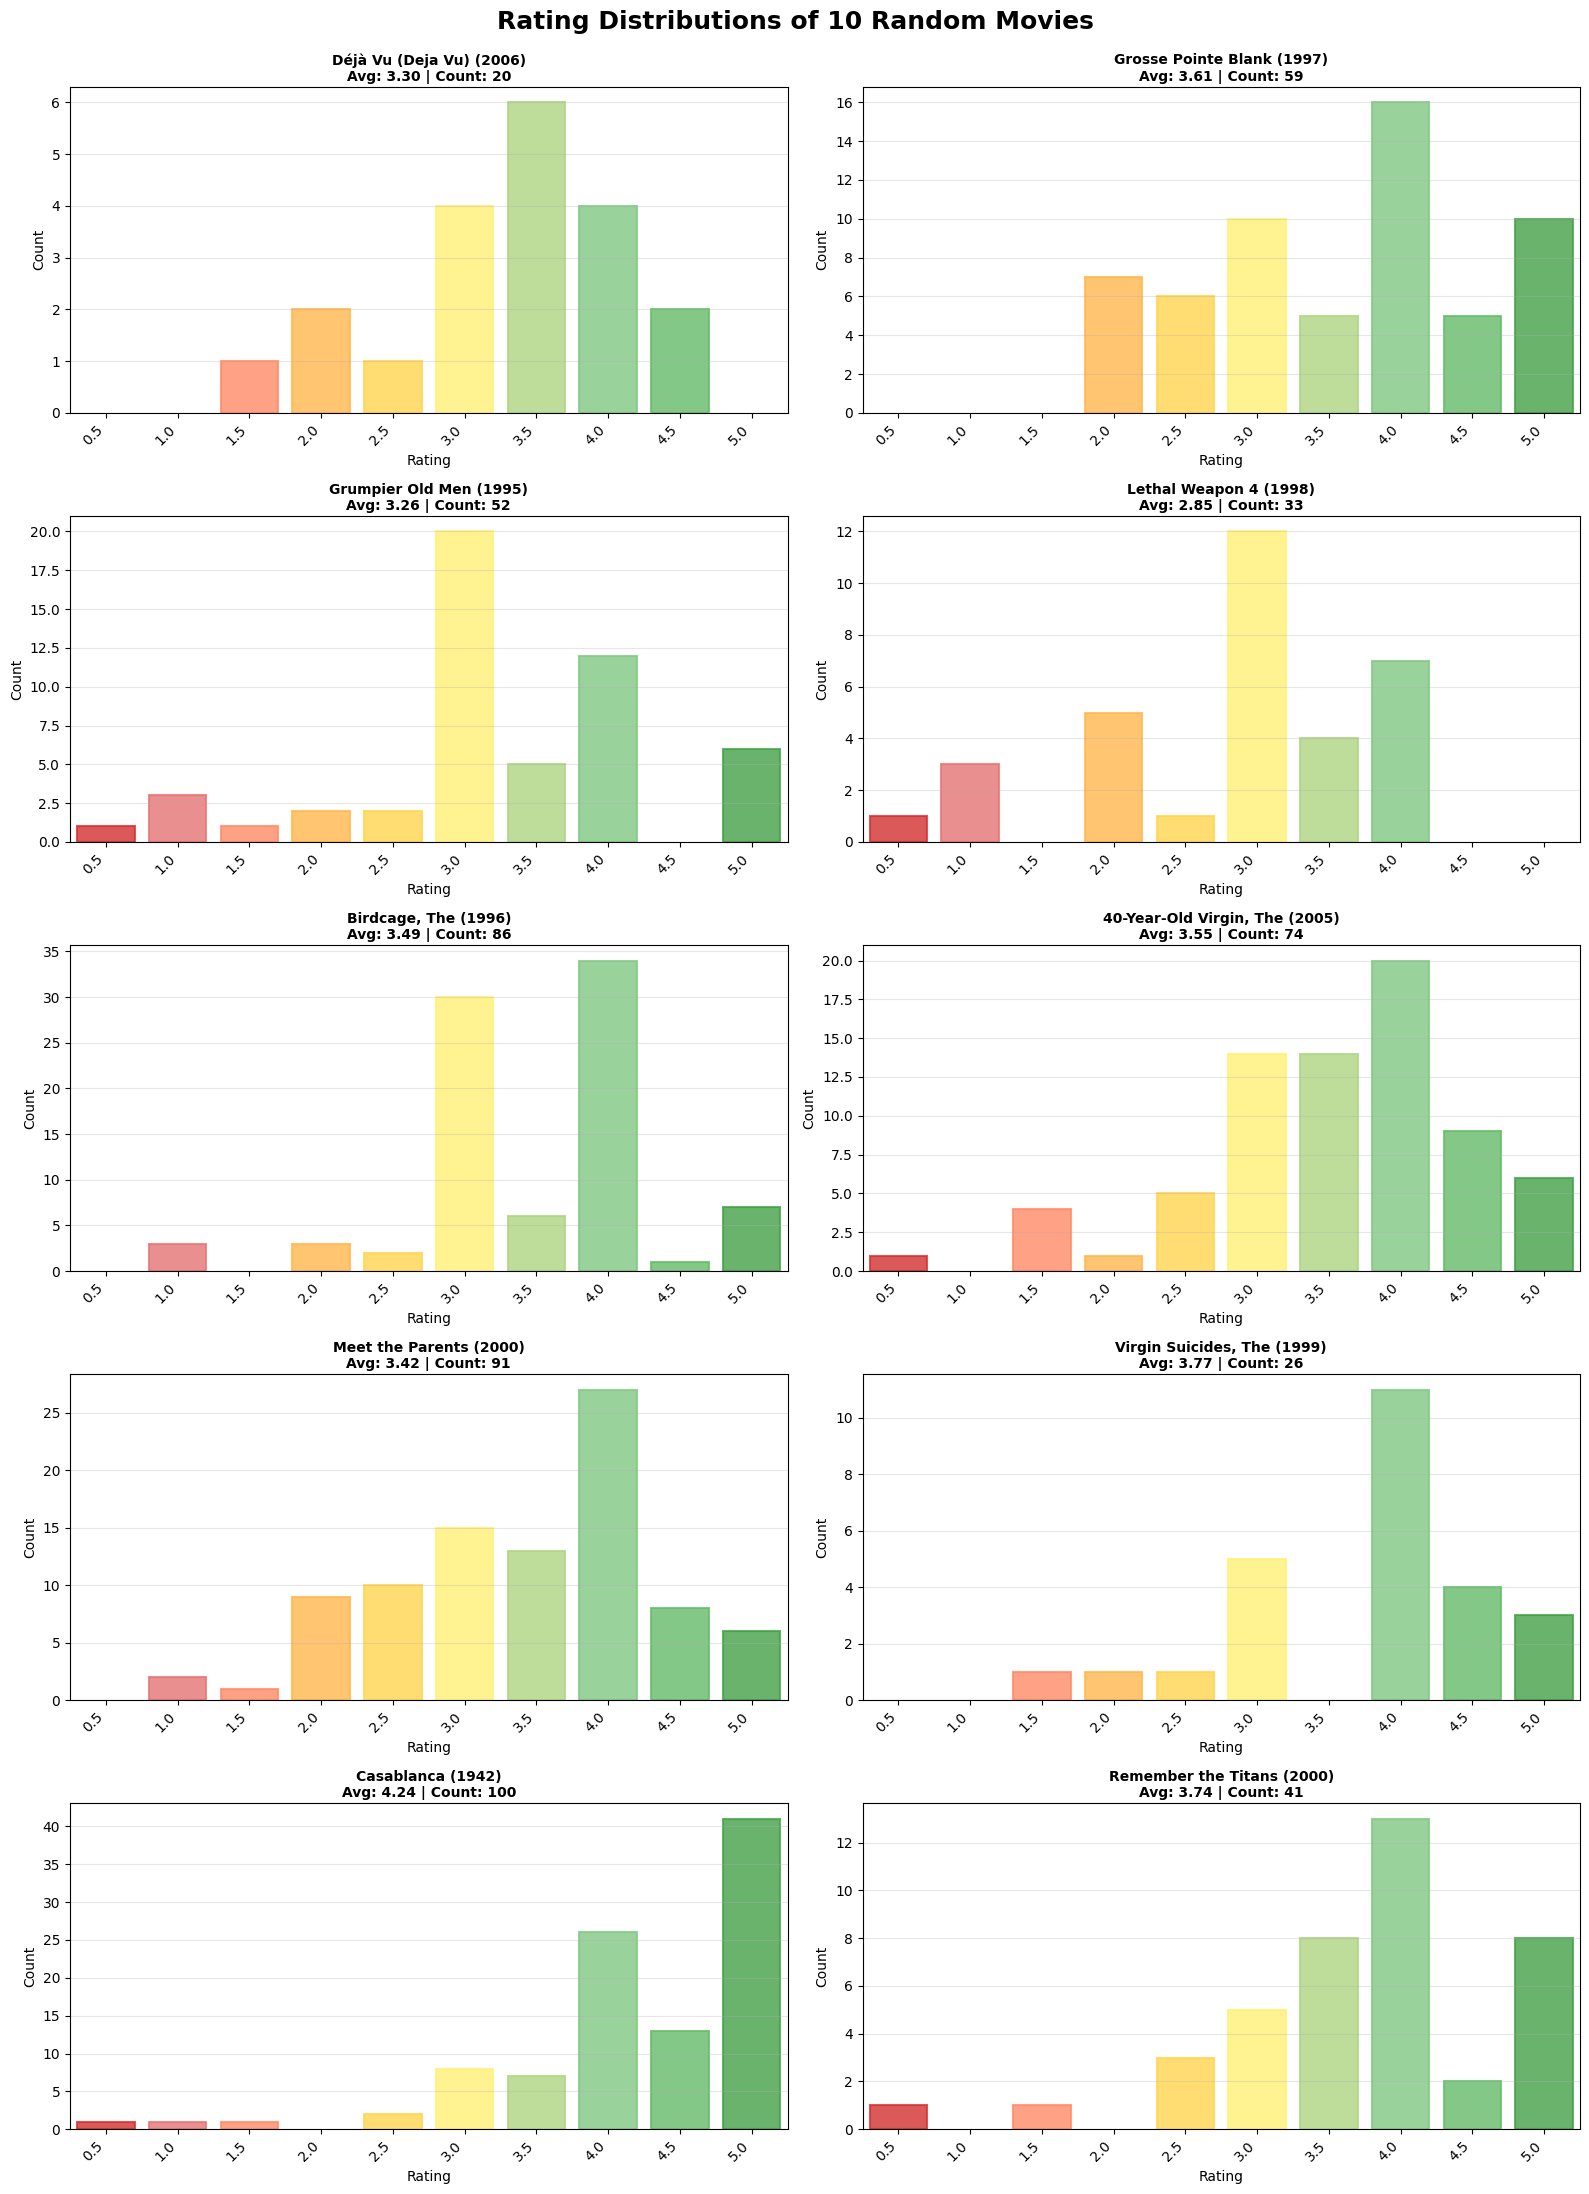

Random movies selected for analysis:
 1. Déjà Vu (Deja Vu) (2006) (ID: 49278) - Avg: 3.300, Count: 20
 2. Grosse Pointe Blank (1997) (ID: 1500) - Avg: 3.610, Count: 59
 3. Grumpier Old Men (1995) (ID: 3) - Avg: 3.260, Count: 52
 4. Lethal Weapon 4 (1998) (ID: 1918) - Avg: 2.848, Count: 33
 5. Birdcage, The (1996) (ID: 141) - Avg: 3.494, Count: 86
 6. 40-Year-Old Virgin, The (2005) (ID: 35836) - Avg: 3.547, Count: 74
 7. Meet the Parents (2000) (ID: 3948) - Avg: 3.418, Count: 91
 8. Virgin Suicides, The (1999) (ID: 3556) - Avg: 3.769, Count: 26
 9. Casablanca (1942) (ID: 912) - Avg: 4.240, Count: 100
10. Remember the Titans (2000) (ID: 3916) - Avg: 3.744, Count: 41


In [12]:
# k) Plot: Rating distributions of 10 random movies
# Select 10 random movies that have at least 20 ratings for better visualization
movies_with_sufficient_ratings = movie_stats[movie_stats['rating_count'] >= 20]['movieId'].tolist()
random_movies = np.random.choice(movies_with_sufficient_ratings, size=10, replace=False)

# Color palette for ratings
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(16, 22))

for i, movie_id in enumerate(random_movies, 1):
    plt.subplot(5, 2, i)
    
    # Get ratings for this movie
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    
    # Count ratings for each value
    rating_counts = movie_ratings.value_counts().sort_index()
    
    # Create bar chart with colors
    bars = plt.bar(rating_counts.index, rating_counts.values, 
                   width=0.4, edgecolor='black', linewidth=1.5)
    
    # Color each bar according to the rating
    for bar, rating in zip(bars, rating_counts.index):
        bar.set_color(rating_colors.get(rating, '#CCCCCC'))
        bar.set_alpha(0.8)
    
    # Get movie title
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    
    plt.title(f'{movie_title}\nAvg: {avg_rating:.2f} | Count: {rating_count}',
              fontsize=10, fontweight='bold', wrap=True)
    plt.xlabel('Rating', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xlim(0.25, 5.25)

plt.suptitle('Rating Distributions of 10 Random Movies', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Random movies selected for analysis:")
for i, movie_id in enumerate(random_movies, 1):
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    print(f"{i:2d}. {movie_title} (ID: {movie_id}) - Avg: {avg_rating:.3f}, Count: {rating_count}")

#### Übersicht
Die Visualisierung zeigt Histogramme der Bewertungsverteilungen für 10 zufällig ausgewählte Filme mit durchschnittlichen Ratings zwischen 2.80 und 4.11 und Bewertungszahlen zwischen 31 und 102.

#### Beobachtete Verteilungsmuster

**Rechtsschief (High-Quality):** Konzentration bei 4.0-5.0 Sternen, typisch für Klassiker und akklamierte Filme

**Normalverteilt (Mainstream):** Peak bei 2.5-3.5, symmetrisch um Mittelwert, typisch für kommerzielle Blockbuster

**Bimodal (Polarisiert):** Mehrere Peaks bei niedrigen UND hohen Ratings, "love it or hate it"-Muster bei kontroversen/experimentellen Filmen

#### Generelle Muster

**Sample Size:** Kleine Samples (<50) zeigen höhere Variabilität, große Samples (>80) glattere Verteilungen (Durchschnitt: ~56 Ratings)

**Rating Range:** Verteilung 2.80-4.11, keine extrem niedrigen Durchschnitte (<2.5) im Sample

**Zeitliche Effekte:** Ältere Filme (1940er-80er) haben höhere Ratings durch Survivorship Bias, neuere Filme (1990er-2000er) zeigen breitere, kritischere Verteilungen


#### Key Insights

- **Confidence-Gewichtung:** Filme mit <50 Ratings benötigen höhere Unsicherheitsmargen beim Scoring
- **Verteilungs-Features:** Varianz und Schiefe als zusätzliche Features nutzen - nicht nur Durchschnitt
- **Polarisierungs-Detection:** Bimodale Verteilungen (hohe Varianz) vorsichtig empfehlen bei unbekannten User-Präferenzen

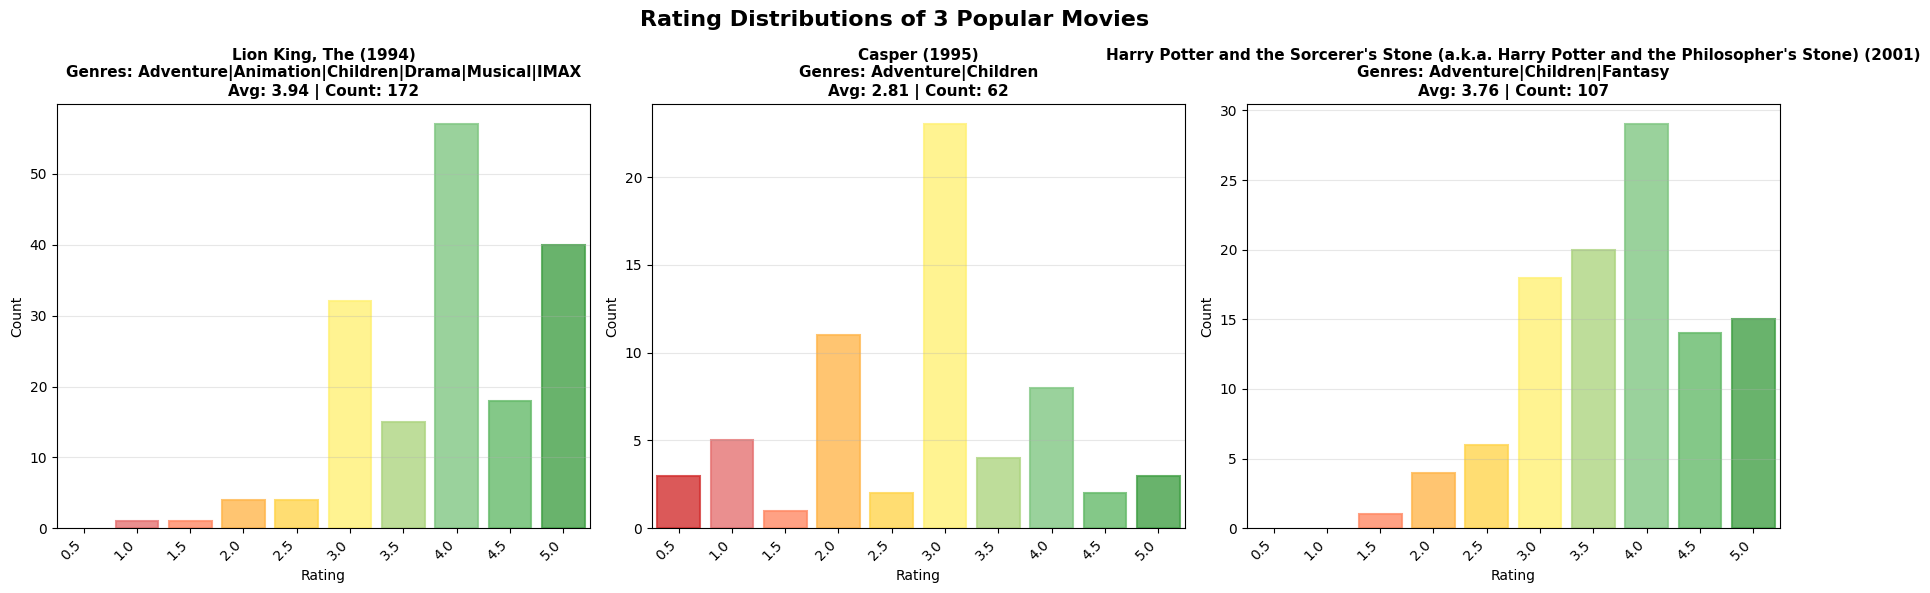

Movies selected for analysis:
1. Lion King, The (1994)
   Genres: Adventure|Animation|Children|Drama|Musical|IMAX
   Average Rating: 3.942
   Rating Count: 172
   Standard Deviation: 0.837

2. Casper (1995)
   Genres: Adventure|Children
   Average Rating: 2.806
   Rating Count: 62
   Standard Deviation: 1.114

3. Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
   Genres: Adventure|Children|Fantasy
   Average Rating: 3.762
   Rating Count: 107
   Standard Deviation: 0.819



In [13]:
# l) Plot: Rating distributions of 3 movies that you have watched
familiar_movies = []

# Films that I have watched
movie_search_terms = ['Lion King', 'Casper', "Harry Potter and the Sorcerer's Stone"]

for term in movie_search_terms:
    matching_movies = movies[movies['title'].str.contains(term, case=False, na=False)]
    if not matching_movies.empty:
        # Get the first match and check if it has sufficient ratings
        movie_id = matching_movies.iloc[0]['movieId']
        if movie_id in movie_stats[movie_stats['rating_count'] >= 50]['movieId'].values:
            familiar_movies.append(movie_id)

# Color palette for ratings
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(18, 6))

for i, movie_id in enumerate(familiar_movies[:3], 1):
    plt.subplot(1, 3, i)
    
    # Get ratings for this movie
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    
    # Count ratings for each value
    rating_counts = movie_ratings.value_counts().sort_index()
    
    # Create bar chart with colors
    bars = plt.bar(rating_counts.index, rating_counts.values, 
                   width=0.4, edgecolor='black', linewidth=1.5)
    
    # Color each bar according to the rating
    for bar, rating in zip(bars, rating_counts.index):
        bar.set_color(rating_colors.get(rating, '#CCCCCC'))
        bar.set_alpha(0.8)
    
    # Get movie title and stats
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_genres = movies[movies['movieId'] == movie_id]['genres'].iloc[0]
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    
    plt.title(f'{movie_title}\nGenres: {movie_genres}\nAvg: {avg_rating:.2f} | Count: {rating_count}',
              fontsize=11, fontweight='bold')
    plt.xlabel('Rating', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xlim(0.25, 5.25)

plt.suptitle('Rating Distributions of 3 Popular Movies', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Movies selected for analysis:")
for i, movie_id in enumerate(familiar_movies[:3], 1):
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_genres = movies[movies['movieId'] == movie_id]['genres'].iloc[0]
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    std_rating = movie_ratings.std()
    print(f"{i}. {movie_title}")
    print(f"   Genres: {movie_genres}")
    print(f"   Average Rating: {avg_rating:.3f}")
    print(f"   Rating Count: {rating_count}")
    print(f"   Standard Deviation: {std_rating:.3f}")
    print()

#### Übersicht
Die Visualisierung zeigt Histogramme für drei populäre Filme mit unterschiedlichen Bewertungsmustern: Lion King (1994, 172 Ratings, Avg 3.94), Casper (1995, 62 Ratings, Avg 2.81), und Harry Potter (2001, 107 Ratings, Avg 3.76).

#### Film-spezifische Beobachtungen

**Lion King (1994):**
- **Rechtsschief:** Starker Peak bei 4.0-4.5 Sternen
- Höchste Bewertungszahl (172) trotz Alters - zeitloser Klassiker mit generationsübergreifender Bekanntheit

**Casper (1995):**
- **Normalverteilt:** Peak bei 2.5-3.0 Sternen (niedrigster Durchschnitt)
- Niedrigste Bewertungszahl (62)
- Breitere Streuung niedriger Ratings (0.5-2.0)
- ich finde diesen Film super, verstehe also die schlechten Bewertungen nicht :(
- ist ebenfalls ein Animationsfilm, aber nicht gelabelt als solcher

**Harry Potter (2001):**
- **Rechtsschief mit Varianz:** Hauptpeak bei 4.0, aber auch substanzielle 3.0-3.5 Ratings
- Mittlere Bewertungszahl (107) trotz enormer Popularität - Sample-Size niedriger als ich erwartet hätte
- Genre: Adventure/Children/Fantasy - Blockbuster mit Franchise-Status


#### Key Insights

- **Subjektivität vs. Konsens:** Persönliche Favoriten (Casper) können stark vom Publikumsdurchschnitt abweichen - individuelle Präferenzen wichtiger als Popularity-Scores
- **Sample Size Bias:** Selbst populäre Filme (Harry Potter) haben begrenzte Ratings im Dataset - Vorsicht bei Sample-Size-basierten Confidence-Scores
- **Genre-Metadaten:** Inkonsistente Labeling (fehlende Animation bei Casper) erfordert Datenbereinigung für robustes Content-Based Filtering
- **Nostalgie-Faktor:** Kinderfilme aus den 1990ern zeigen unterschiedliche Bewertungsmuster je nach generationsübergreifender vs. zeitgebundener Anziehungskraft


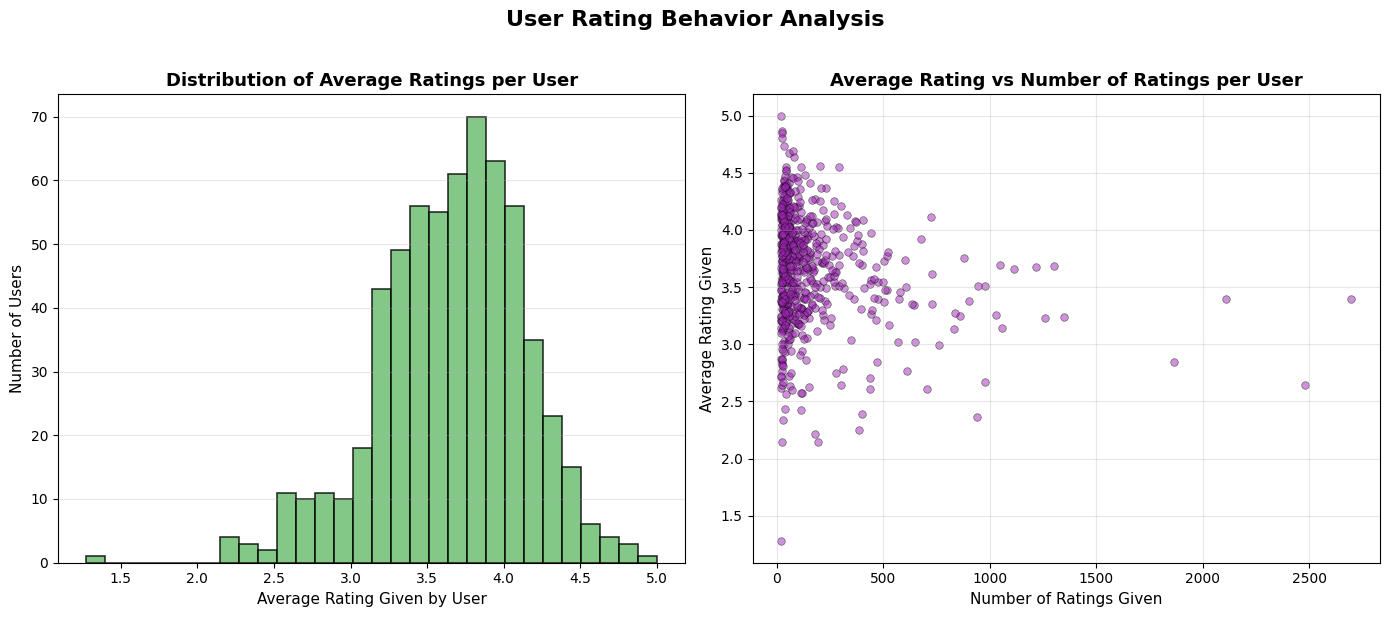

User average rating statistics:
• Min average rating: 1.275
• Max average rating: 5.000
• Mean average rating: 3.657
• Median average rating: 3.694
• Std average rating: 0.481

Users with highest average ratings:
• User 53.0: 5.000 (from 20.0 ratings)
• User 251.0: 4.870 (from 23.0 ratings)
• User 515.0: 4.846 (from 26.0 ratings)
• User 25.0: 4.808 (from 26.0 ratings)
• User 30.0: 4.735 (from 34.0 ratings)
• User 523.0: 4.693 (from 75.0 ratings)
• User 348.0: 4.673 (from 55.0 ratings)
• User 171.0: 4.634 (from 82.0 ratings)
• User 452.0: 4.557 (from 202.0 ratings)
• User 43.0: 4.553 (from 114.0 ratings)

Users with lowest average ratings:
• User 442.0: 1.275 (from 20.0 ratings)
• User 139.0: 2.144 (from 194.0 ratings)
• User 508.0: 2.146 (from 24.0 ratings)
• User 153.0: 2.218 (from 179.0 ratings)
• User 567.0: 2.245 (from 385.0 ratings)
• User 311.0: 2.339 (from 28.0 ratings)
• User 298.0: 2.364 (from 939.0 ratings)
• User 517.0: 2.386 (from 400.0 ratings)
• User 308.0: 2.426 (from 11

In [14]:
# m) Plot: How many users give which average rating
# Calculate average rating per user
user_avg_ratings = ratings.groupby('userId')['rating'].agg(['mean', 'count']).reset_index()
user_avg_ratings.columns = ['userId', 'avg_rating', 'rating_count']

plt.figure(figsize=(14, 6))

# Plot 1: Histogram of average ratings per user
plt.subplot(1, 2, 1)
plt.hist(user_avg_ratings['avg_rating'], bins=30, alpha=0.8, color='#66BB6A', 
         edgecolor='black', linewidth=1.2)
plt.xlabel('Average Rating Given by User', fontsize=11)
plt.ylabel('Number of Users', fontsize=11)
plt.title('Distribution of Average Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Scatter plot of average rating vs number of ratings
plt.subplot(1, 2, 2)
plt.scatter(user_avg_ratings['rating_count'], user_avg_ratings['avg_rating'],
            alpha=0.5, color='#9C27B0', s=30, edgecolors='black', linewidth=0.5)
plt.xlabel('Number of Ratings Given', fontsize=11)
plt.ylabel('Average Rating Given', fontsize=11)
plt.title('Average Rating vs Number of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('User Rating Behavior Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("User average rating statistics:")
print(f"• Min average rating: {user_avg_ratings['avg_rating'].min():.3f}")
print(f"• Max average rating: {user_avg_ratings['avg_rating'].max():.3f}")
print(f"• Mean average rating: {user_avg_ratings['avg_rating'].mean():.3f}")
print(f"• Median average rating: {user_avg_ratings['avg_rating'].median():.3f}")
print(f"• Std average rating: {user_avg_ratings['avg_rating'].std():.3f}")

print(f"\nUsers with highest average ratings:")
top_raters = user_avg_ratings.nlargest(10, 'avg_rating')
for idx, row in top_raters.iterrows():
    print(f"• User {row['userId']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

print(f"\nUsers with lowest average ratings:")
low_raters = user_avg_ratings.nsmallest(10, 'avg_rating')
for idx, row in low_raters.iterrows():
    print(f"• User {row['userId']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

#### Übersicht
Zwei Visualisierungen zur Analyse des Nutzerverhaltens: **Distribution of Average Ratings** (links) zeigt, wie Benutzer durchschnittlich bewerten, **Average Rating vs. Number of Ratings** (rechts) untersucht den Zusammenhang zwischen Aktivität und Bewertungsstrenge.

#### Distribution of Average Ratings per User 

##### Beobachtungen
- **Normalverteilt mit leichter Rechtsschiefe:** Peak bei 3.5-4.0 Sternen
- Zentrum der Verteilung liegt bei ~3.7 (visuell geschätzt)
- Wenige extreme Bewerter: Kaum User mit Durchschnitt <2.5 oder >4.8
- Breite Streuung zwischen 2.5 und 4.5 zeigt diverse Bewertungsstile

##### Interpretation
**Positivity Bias auf User-Ebene:** Die meisten Benutzer bewerten im Durchschnitt positiv (>3.5), was den Item-Level-Positivity-Bias bestätigt. Nutzer schauen und bewerten primär Filme, die sie mögen.

**Unterschiedliche Bewertungsstile:**
- **Strenge Bewerter (Avg <3.0):** Kleine Minderheit (~10%), kritischer oder breiteres Filmspektrum
- **Moderate Bewerter (Avg 3.0-4.0):** Mehrheit (~70%), ausgewogene Bewertungen
- **Großzügige Bewerter (Avg >4.0):** Substanzielle Gruppe (~20%), sehr positive Grundhaltung

#### Average Rating vs. Number of Ratings per User (Rechts)

##### Beobachtungen
- **Negative Korrelation:** Tendenz zu niedrigeren durchschnittlichen Ratings bei höherer Aktivität
- User mit 20-100 Ratings: Breite Streuung (2.0-5.0), viele bei 4.0+
- User mit 500+ Ratings: Konzentration bei 3.0-4.0, kaum extreme Durchschnitte
- Outliers: Einzelne Power-User (>2000 Ratings) mit ungewöhnlichen Durchschnitten (2.7, 3.4, 5.0)

##### Interpretation

**"Honeymoon Effect":**
- Neue/Low-Activity-User (20-100 Ratings) bewerten sehr positiv (viele bei 4.5+)
- Sie bewerten primär bekannte Favoriten, die sie aktiv ausgewählt haben
- Selektionseffekt: Erst mit der Zeit bewerten sie auch durchschnittliche Filme

**Regression zur Mitte bei Power-Usern:**
- Hochaktive User (>500 Ratings) konvergieren zu Durchschnittswerten (3.0-4.0)
- Größeres Filmspektrum führt zu ausgewogeneren Bewertungen
- Power-User entwickeln differenzierteres Bewertungsverhalten

**Heterogenität in Low-Activity-Segment:**
- Extreme Varianz bei Usern mit <200 Ratings
- Einige sehr kritisch (Avg 2.0-2.5), andere sehr großzügig (Avg 4.5-5.0)
- Sample-Size-Effekt: Wenige Ratings führen zu instabilen Durchschnitten


#### Key Insights

- **User-Bias-Normalisierung:** Verschiedene Bewertungsstile erfordern User-Normalisierung - ein 4.0-Rating von einem strengen User (Avg 3.0) ist wertvoller als von einem großzügigen User (Avg 4.5)
- **Activity-Level-Segmentierung:** Separate Modellierung für Low-Activity (<100), Medium-Activity (100-500), und High-Activity (>500) User empfohlen
- **Cold Start für neue User:** Neue User starten mit Positivity Bias - Early-Stage-Ratings sollten vorsichtig interpretiert werden
- **Power-User als Ground Truth:** User mit >500 Ratings haben stabilere, differenziertere Bewertungen - höheres Gewicht in Training sinnvoll

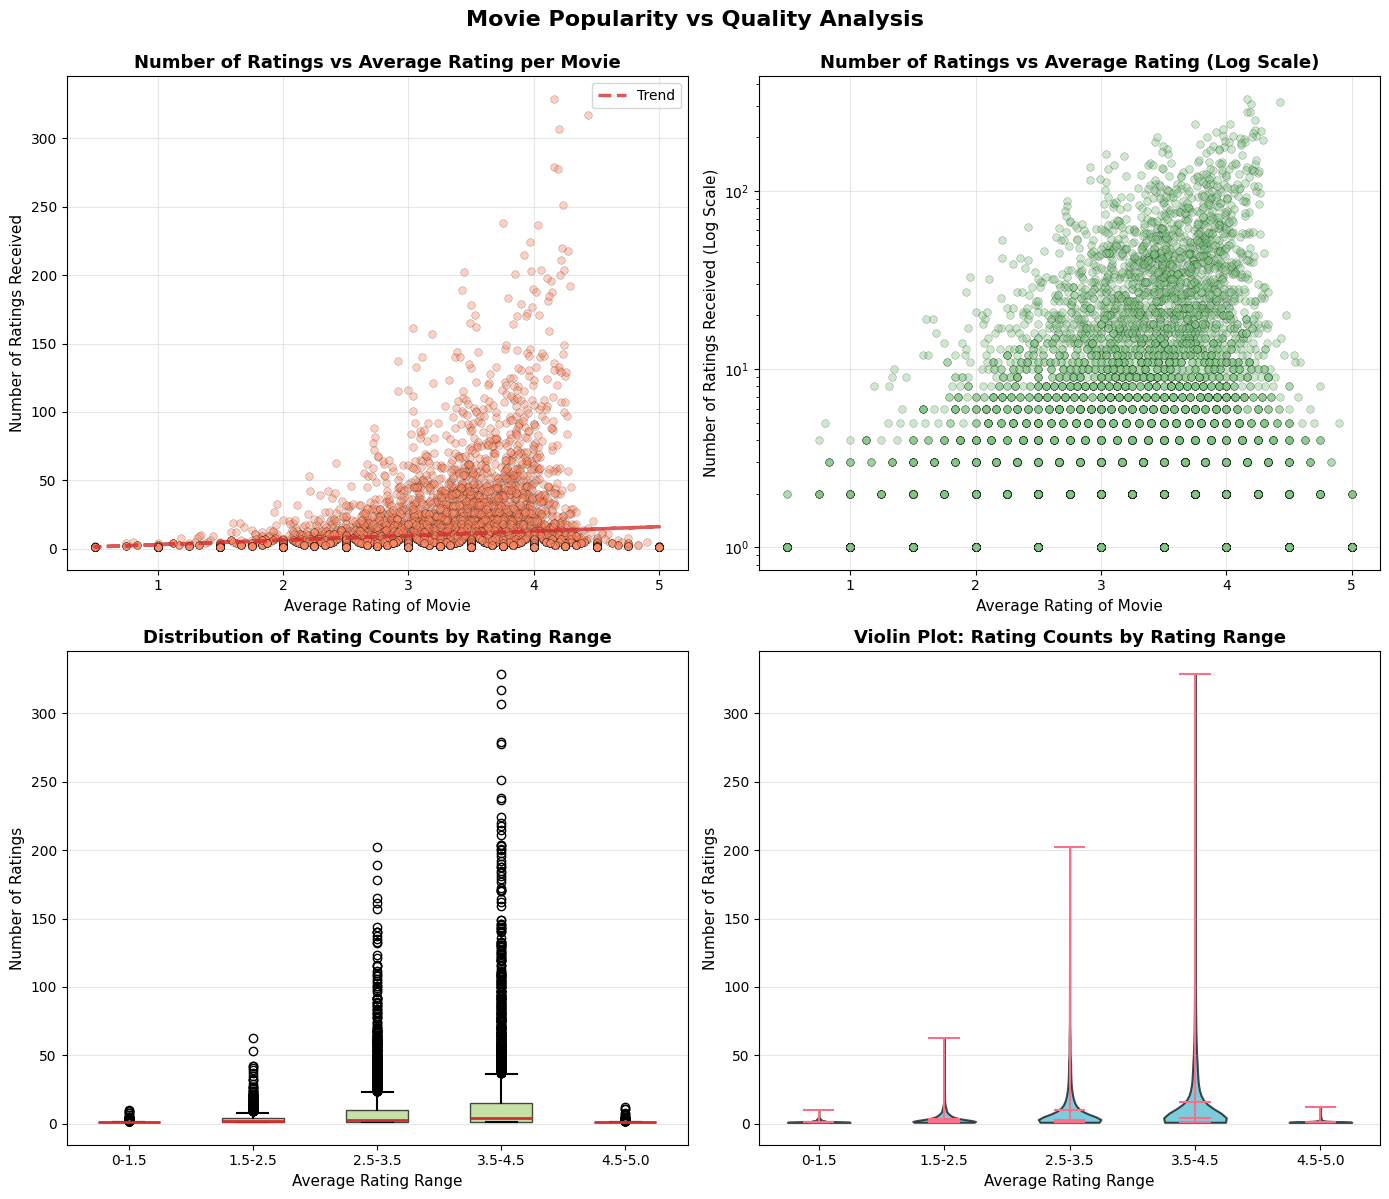

Movie rating analysis:
• Correlation between average rating and number of ratings: 0.127

Statistics by rating range:
• 0-1.5: 511 movies, avg ratings count: 1.4, median: 1.0
• 1.5-2.5: 1486 movies, avg ratings count: 3.8, median: 2.0
• 2.5-3.5: 3959 movies, avg ratings count: 9.9, median: 3.0
• 3.5-4.5: 3424 movies, avg ratings count: 16.0, median: 4.0
• 4.5-5.0: 344 movies, avg ratings count: 1.4, median: 1.0

Top 5 movies by average rating:
• Lamerica (1994): 5.000 (from 2 ratings)
• Heidi Fleiss: Hollywood Madam (1995): 5.000 (from 2 ratings)
• Awfully Big Adventure, An (1995): 5.000 (from 1 ratings)
• Live Nude Girls (1995): 5.000 (from 1 ratings)
• In the Realm of the Senses (Ai no corrida) (1976): 5.000 (from 1 ratings)

Most rated movies:
• Forrest Gump (1994): 329 ratings (avg: 4.164)
• Shawshank Redemption, The (1994): 317 ratings (avg: 4.429)
• Pulp Fiction (1994): 307 ratings (avg: 4.197)
• Silence of the Lambs, The (1991): 279 ratings (avg: 4.161)
• Matrix, The (1999): 278

In [15]:
# n) Plot: How often a movie was rated as a function of average rating
plt.figure(figsize=(14, 12))

# Plot 1: Scatter plot with hexbin overlay
plt.subplot(2, 2, 1)
plt.scatter(movie_stats['avg_rating'], movie_stats['rating_count'],
            alpha=0.4, color='#FF8A65', s=30, edgecolors='black', linewidth=0.3)
plt.xlabel('Average Rating of Movie', fontsize=11)
plt.ylabel('Number of Ratings Received', fontsize=11)
plt.title('Number of Ratings vs Average Rating per Movie', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(movie_stats['avg_rating'], movie_stats['rating_count'], 1)
p = np.poly1d(z)
plt.plot(movie_stats['avg_rating'], p(movie_stats['avg_rating']), 
         color='#D32F2F', linestyle='--', alpha=0.8, linewidth=2.5, label='Trend')
plt.legend()

# Plot 2: Log scale scatter plot
plt.subplot(2, 2, 2)
plt.scatter(movie_stats['avg_rating'], movie_stats['rating_count'],
            alpha=0.4, color='#81C784', s=30, edgecolors='black', linewidth=0.3)
plt.xlabel('Average Rating of Movie', fontsize=11)
plt.ylabel('Number of Ratings Received (Log Scale)', fontsize=11)
plt.title('Number of Ratings vs Average Rating (Log Scale)', fontsize=13, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 3: Box plot by rating bins
plt.subplot(2, 2, 3)

# Create rating bins
movie_stats['rating_bin'] = pd.cut(movie_stats['avg_rating'],
                                    bins=[0, 1.5, 2.5, 3.5, 4.5, 5.0],
                                    labels=['0-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.0'])

# Create box plot data
rating_bins = []
rating_counts_by_bin = []
for bin_label in movie_stats['rating_bin'].cat.categories:
    bin_data = movie_stats[movie_stats['rating_bin'] == bin_label]['rating_count']
    if len(bin_data) > 0:
        rating_bins.append(bin_label)
        rating_counts_by_bin.append(bin_data)

# Create colorful box plot
box = plt.boxplot(rating_counts_by_bin, labels=rating_bins, patch_artist=True,
                  boxprops=dict(facecolor='#AED581', alpha=0.7),
                  medianprops=dict(color='#D32F2F', linewidth=2),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5))

plt.xlabel('Average Rating Range', fontsize=11)
plt.ylabel('Number of Ratings', fontsize=11)
plt.title('Distribution of Rating Counts by Rating Range', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 4: Violin plot by rating bins
plt.subplot(2, 2, 4)

# Prepare data for violin plot
violin_data = [movie_stats[movie_stats['rating_bin'] == bin_label]['rating_count'].values 
               for bin_label in movie_stats['rating_bin'].cat.categories 
               if len(movie_stats[movie_stats['rating_bin'] == bin_label]) > 0]

parts = plt.violinplot(violin_data, positions=range(len(rating_bins)), 
                       showmeans=True, showmedians=True)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('#45B7D1')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

plt.xticks(range(len(rating_bins)), rating_bins)
plt.xlabel('Average Rating Range', fontsize=11)
plt.ylabel('Number of Ratings', fontsize=11)
plt.title('Violin Plot: Rating Counts by Rating Range', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Movie Popularity vs Quality Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Movie rating analysis:")
print(f"• Correlation between average rating and number of ratings: {movie_stats['avg_rating'].corr(movie_stats['rating_count']):.3f}")

print(f"\nStatistics by rating range:")
for bin_label in movie_stats['rating_bin'].cat.categories:
    bin_data = movie_stats[movie_stats['rating_bin'] == bin_label]
    if len(bin_data) > 0:
        print(f"• {bin_label}: {len(bin_data)} movies, avg ratings count: {bin_data['rating_count'].mean():.1f}, median: {bin_data['rating_count'].median():.1f}")

print(f"\nTop 5 movies by average rating:")
top_rated = movie_stats.nlargest(5, 'avg_rating')
for idx, row in top_rated.iterrows():
    print(f"• {row['title']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

print(f"\nMost rated movies:")
most_rated = movie_stats.nlargest(5, 'rating_count')
for idx, row in most_rated.iterrows():
    print(f"• {row['title']}: {row['rating_count']} ratings (avg: {row['avg_rating']:.3f})")

#### Übersicht
Vier Visualisierungen untersuchen den Zusammenhang zwischen Popularität (Anzahl Ratings) und Qualität (durchschnittliches Rating) von Filmen.

#### Number of Ratings vs Average Rating

##### Beobachtungen
- **Schwache positive Korrelation:** Trendlinie steigt leicht an
- Massive Konzentration bei niedrigen Rating-Counts (<50) über alle Qualitätsstufen
- Hochbewertete Filme (>4.0) haben tendenziell mehr Ratings
- Outliers: Einige Filme mit 250-330 Ratings bei mittleren bis hohen Durchschnitten

##### Interpretation
**"Quality drives Popularity"-Effekt:** Gute Filme (>3.5) erhalten mehr Bewertungen durch Mundpropaganda und Wiederholungszuschauer. Allerdings ist der Effekt schwach - viele hochwertige Filme bleiben unentdeckt (hohe Qualität, niedrige Counts).

#### Number of Ratings vs Average Rating - Log Scale

##### Beobachtungen
- **Horizontale Bänder:** Rating-Counts konzentrieren sich bei 3, 5, 10, 20, 50, 100 (typische Schwellenwerte)
- Vertikale Streuung bei allen Rating-Levels deutlich sichtbar
- Keine klare Korrelation erkennbar - selbst bei Log-Transformation
- Filme mit nur 1-2 Ratings verteilen sich über gesamtes Rating-Spektrum (1.0-5.0)

##### Interpretation
**Popularität ≠ Qualität:** Die Log-Scale offenbart, dass Popularität und Qualität weitgehend unabhängig sind. Selbst Filme mit nur wenigen Ratings können hohe Durchschnitte haben (Nischen-Meisterwerke) oder niedrige (Flops, die keiner schaut).

#### Distribution of Rating Counts by Rating Range

##### Beobachtungen
- **Boxplot-Analyse:**
  - **0-1.5 Range:** Median ~3 Ratings, fast keine Outliers
  - **1.5-2.5 Range:** Median ~5 Ratings, einige Outliers bis 70
  - **2.5-3.5 Range:** Median ~10 Ratings, viele Outliers bis 200
  - **3.5-4.5 Range:** Median ~10 Ratings, extremste Outliers bis 330+
  - **4.5-5.0 Range:** Median ~3 Ratings, kaum Outliers

##### Interpretation

**U-förmige Popularitätsverteilung:**
- **Niedrige Ratings (0-2.5):** Wenige Bewertungen - diese Filme werden schnell gemieden
- **Mittlere bis hohe Ratings (2.5-4.5):** Höchste Popularität und größte Varianz - "sehenswerte" Filme
- **Sehr hohe Ratings (4.5-5.0):** Wieder niedrigere Counts - perfekte Filme sind selten UND haben oft Nischen-Appeal

**Long Tail bei guten Filmen:** Die 3.5-4.5 Range hat die meisten Outliers, was zeigt, dass einige sehr gute Filme massiv populär werden, während die Mehrheit moderat bleibt.

#### Violin Plot: Rating Counts by Rating Range

##### Beobachtungen
- **Verteilungsform pro Range:**
  - **0-1.5:** Extrem schmal, konzentriert bei wenigen Ratings
  - **1.5-2.5:** Breitere Basis, symmetrisch
  - **2.5-3.5:** Deutlich breitere Distribution, mehr Varianz
  - **3.5-4.5:** Breiteste Distribution, höchste Dichte bei niedrigen Counts, langer Tail nach oben
  - **4.5-5.0:** Wieder schmale Distribution, wenig Varianz

#### Interpretation

**Popularitäts-Dynamik nach Qualität:**
- **Schlechte Filme (0-2.5):** Homogen unpopulär - wenige schauen sie, wenige bewerten sie
- **Gute Filme (2.5-4.5):** Heterogen populär - einige werden Hits, viele bleiben Geheimtipps
- **Perfekte Filme (4.5-5.0):** Homogen unpopulär - entweder Nischen-Meisterwerke oder zu wenig Ratings für stabilen Durchschnitt

**Distribution Shape:** Die 3.5-4.5 Range zeigt eine typische Power-Law-Verteilung - viele Filme mit wenigen Ratings, wenige Filme mit vielen Ratings.

#### Key Insights

- **Schwache Popularitäts-Qualitäts-Korrelation:** Popularität ist kein verlässlicher Qualitätsindikator - viele hochwertige Filme bleiben unentdeckt
- **Sample-Size-Stabilität:** Filme mit <10 Ratings haben instabile Durchschnitte (sichtbar bei 4.5-5.0 Range) - Confidence-Scores notwendig
- **Sweet Spot bei 3.5-4.5:** Diese Range hat höchste Popularität und größte Varianz - typischer "sehenswert"-Bereich für Mainstream-Publikum
- **Cold Start für unpopuläre Qualitätsfilme:** Viele Filme mit hohen Ratings (>4.0) und niedrigen Counts (<20) - Content-Based Filtering kann diese Geheimtipps besser empfehlen als Popularity-basierte Ansätze

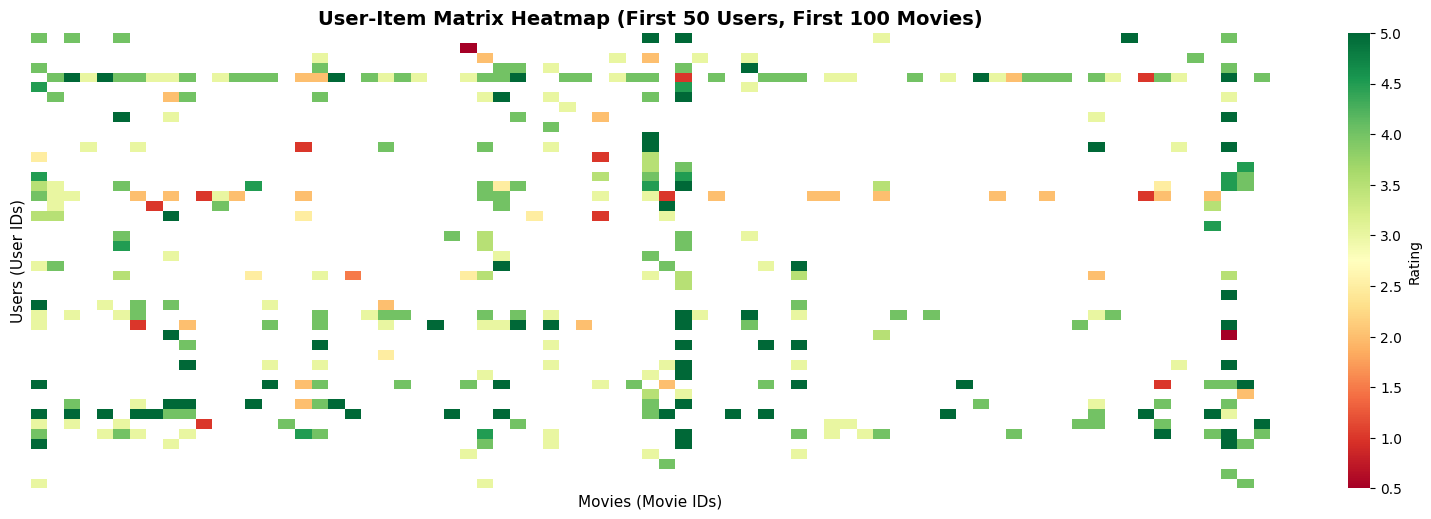

User-Item Matrix Heatmap Analysis:
• Subset size: 46 users × 75 movies
• Total possible ratings in subset: 3,450
• Actual ratings in subset: 362
• Sparsity of subset: 0.895 (89.5%)


In [16]:
# o) Plot: A heatmap of the User Item Matrix
# For visualization purposes, we'll create a smaller subset of the matrix
# take the first 50 users and first 100 movies for better visualization
subset_users = sorted(ratings['userId'].unique())[:50]
subset_movies = sorted(ratings['movieId'].unique())[:100]

# Create subset of ratings
subset_ratings = ratings[
    (ratings['userId'].isin(subset_users)) &
    (ratings['movieId'].isin(subset_movies))
]

# Create user-item matrix for the subset
subset_matrix = subset_ratings.pivot_table(index='userId', columns='movieId', values='rating')

fig = plt.figure(figsize=(16, 10))

# Plot 1: Main heatmap
ax1 = plt.subplot(2, 2, (1, 2))
sns.heatmap(subset_matrix, cmap='RdYlGn', cbar=True,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Rating'}, vmin=0.5, vmax=5.0)
plt.title('User-Item Matrix Heatmap (First 50 Users, First 100 Movies)',
          fontsize=14, fontweight='bold')
plt.xlabel('Movies (Movie IDs)', fontsize=11)
plt.ylabel('Users (User IDs)', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate statistics
total_possible = subset_matrix.shape[0] * subset_matrix.shape[1]
actual_ratings = subset_matrix.notna().sum().sum()
sparsity = 1 - (actual_ratings / total_possible)

print("User-Item Matrix Heatmap Analysis:")
print(f"• Subset size: {subset_matrix.shape[0]} users × {subset_matrix.shape[1]} movies")
print(f"• Total possible ratings in subset: {total_possible:,}")
print(f"• Actual ratings in subset: {actual_ratings:,}")
print(f"• Sparsity of subset: {sparsity:.3f} ({sparsity*100:.1f}%)")

#### Übersicht
Die Heatmap visualisiert die User-Item-Matrix für die ersten 50 Benutzer und 100 Filme. Farbkodierung: Dunkelgrün = 5.0 Sterne, Hellgelb = 3.0 Sterne, Orange/Rot = niedrige Ratings, Weiß = keine Bewertung.


#### Beobachtungen

##### Extreme Sparsity
- **Überwiegend weiß:** >95% der Matrix-Zellen sind leer (keine Bewertungen)
- Nur vereinzelte farbige Punkte pro Zeile (User) und Spalte (Film)
- Typisches Muster: Jeder User hat nur 2-10 sichtbare Ratings in diesem Ausschnitt

##### Keine erkennbaren Cluster
- **Fehlende strukturierte Muster:** Keine zusammenhängenden Blöcke ähnlicher Ratings
- User-Zeilen zeigen keine offensichtliche Gruppierung (keine horizontalen Bänder)
- Film-Spalten zeigen keine konsistente Beliebtheit (keine vertikalen Linien)
- Ratings verteilen sich scheinbar zufällig über die Matrix

##### Rating-Verteilung
- **Grün-Dominanz:** Die meisten sichtbaren Ratings liegen im hohen Bereich (3.5-5.0)
- Wenige orange/rote Punkte (niedrige Ratings <2.5)
- Bestätigt Positivity Bias auch auf Matrix-Ebene

##### User-Heterogenität
- **Verschiedene Activity-Level:** Einige User-Zeilen sind fast leer, andere haben mehr Punkte
- Keine "Dense Rows" sichtbar - selbst aktivere User haben große Lücken
- Kein User hat alle 100 Filme bewertet

##### Item-Heterogenität
- **Verschiedene Popularität:** Einige Film-Spalten haben mehr Ratings als andere
- Aber selbst populäre Filme haben viele leere Zellen
- Keine "Blockbuster-Spalten" mit durchgehender Bewertung erkennbar

#### Interpretation

##### Sparsity Problem
Die extreme Dünnbesetztheit (~95% leer) ist das zentrale Problem für Collaborative Filtering:
- User-User-Ähnlichkeiten schwer zu berechnen (wenig Überlappung)
- Item-Item-Ähnlichkeiten robuster, da Items von verschiedenen Usern bewertet werden
- Matrix Factorization-Methoden (SVD, NMF) sind essentiell, um latente Strukturen zu finden

##### Fehlende visuelle Cluster
Das Fehlen von Clustern in dieser Rohansicht bedeutet nicht, dass keine latenten Muster existieren:
- Latente Faktoren (Genre-Präferenzen, Geschmack) sind nicht direkt sichtbar
- Sortierung der Matrix nach User-Ähnlichkeit oder Film-Genre würde Struktur offenbaren
- Dimensionsreduktions-Techniken (SVD, UMAP) können versteckte Muster extrahieren

##### Cold Start Visualisierung
- Fast jeder User hat zu fast jedem Film keine Bewertung
- Neue User (leere Zeilen) vs. neue Filme (leere Spalten) sind visuell nicht unterscheidbar
- Unterstreicht Notwendigkeit von Hybrid-Ansätzen für Cold Start


#### Key Insights

- **Extreme Sparsity (~95%):** User-based CF schwierig aufgrund minimaler Überlappung - Item-based CF oder Matrix Factorization bevorzugt
- **Keine direkten Cluster sichtbar:** Latente Strukturen existieren, aber nur durch Dimensionsreduktion (SVD, NMF) erkennbar
- **Positivity Bias bestätigt:** Sichtbare Ratings primär grün (3.5-5.0) - fehlende Ratings sind nicht "schlecht", sondern "nicht gesehen"
- **Missing Data ≠ Negative Preference:** Leere Zellen bedeuten "nicht bewertet", nicht "nicht gemocht" - wichtig für Implicit vs. Explicit Feedback

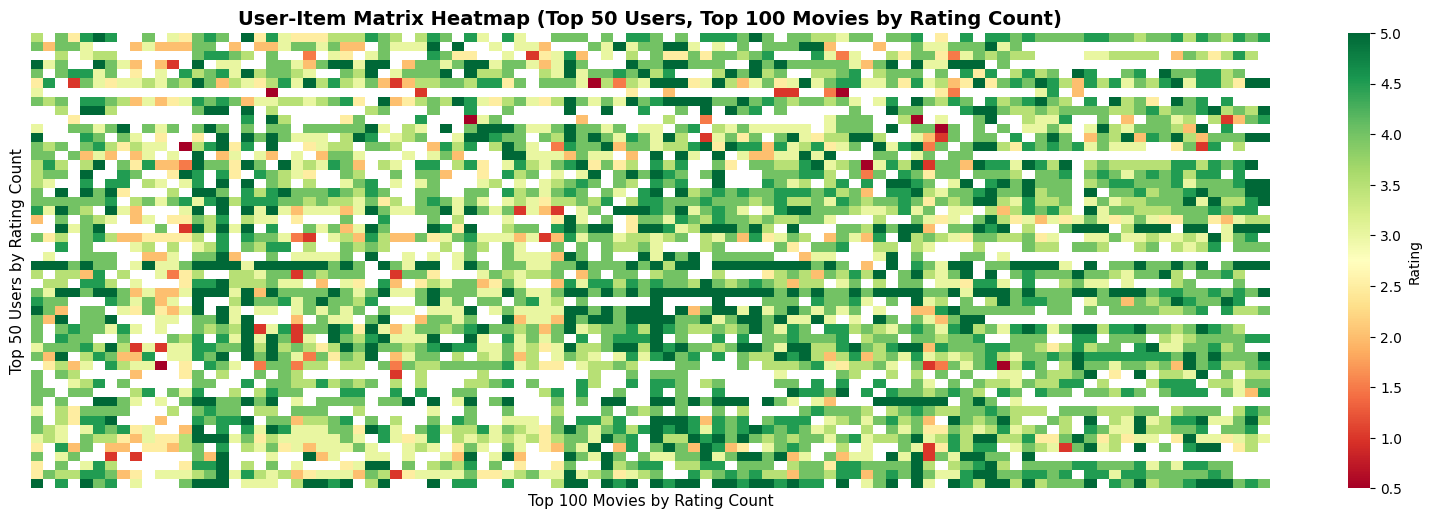

Top Users and Movies Matrix Analysis:
• Matrix size: 50 users × 100 movies
• Total possible ratings in matrix: 5,000
• Actual ratings in matrix: 3,637
• Density of matrix: 0.727 (72.7%)
• Sparsity of matrix: 0.273 (27.3%)

Top subset statistics:
• Average rating: 3.781
• Rating range: 0.5 - 5.0

Top 10 users by rating count:
• User 414: 2698 ratings
• User 599: 2478 ratings
• User 474: 2108 ratings
• User 448: 1864 ratings
• User 274: 1346 ratings
• User 610: 1302 ratings
• User 68: 1260 ratings
• User 380: 1218 ratings
• User 606: 1115 ratings
• User 288: 1055 ratings

Top 10 movies by rating count:
• Forrest Gump (1994): 329 ratings
• Shawshank Redemption, The (1994): 317 ratings
• Pulp Fiction (1994): 307 ratings
• Silence of the Lambs, The (1991): 279 ratings
• Matrix, The (1999): 278 ratings
• Star Wars: Episode IV - A New Hope (1977): 251 ratings
• Jurassic Park (1993): 238 ratings
• Braveheart (1995): 237 ratings
• Terminator 2: Judgment Day (1991): 224 ratings
• Schindler's Lis

In [17]:
# p) Plot: A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings
# Get top 50 users with most ratings
top_users = ratings.groupby('userId').size().nlargest(50).index.tolist()

# Get top 100 movies with most ratings
top_movies = ratings.groupby('movieId').size().nlargest(100).index.tolist()

# Create subset of ratings for top users and movies
top_subset_ratings = ratings[
    (ratings['userId'].isin(top_users)) &
    (ratings['movieId'].isin(top_movies))
]

# Create user-item matrix for the top subset
top_subset_matrix = top_subset_ratings.pivot_table(index='userId', columns='movieId', values='rating')

fig = plt.figure(figsize=(16, 10))

# Plot 1: Main heatmap
ax1 = plt.subplot(2, 2, (1, 2))
sns.heatmap(top_subset_matrix, cmap='RdYlGn', cbar=True,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Rating'}, vmin=0.5, vmax=5.0)
plt.title('User-Item Matrix Heatmap (Top 50 Users, Top 100 Movies by Rating Count)',
          fontsize=14, fontweight='bold')
plt.xlabel('Top 100 Movies by Rating Count', fontsize=11)
plt.ylabel('Top 50 Users by Rating Count', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate statistics
total_possible = top_subset_matrix.shape[0] * top_subset_matrix.shape[1]
actual_ratings = top_subset_matrix.notna().sum().sum()
density = actual_ratings / total_possible
top_sparsity = 1 - density

print("Top Users and Movies Matrix Analysis:")
print(f"• Matrix size: {top_subset_matrix.shape[0]} users × {top_subset_matrix.shape[1]} movies")
print(f"• Total possible ratings in matrix: {total_possible:,}")
print(f"• Actual ratings in matrix: {actual_ratings:,}")
print(f"• Density of matrix: {density:.3f} ({density*100:.1f}%)")
print(f"• Sparsity of matrix: {top_sparsity:.3f} ({top_sparsity*100:.1f}%)")

print(f"\nTop subset statistics:")
print(f"• Average rating: {top_subset_matrix.mean().mean():.3f}")
print(f"• Rating range: {top_subset_matrix.min().min():.1f} - {top_subset_matrix.max().max():.1f}")

print(f"\nTop 10 users by rating count:")
user_counts = ratings.groupby('userId').size().nlargest(10)
for user_id, count in user_counts.items():
    print(f"• User {user_id}: {count} ratings")

print(f"\nTop 10 movies by rating count:")
movie_counts = ratings.groupby('movieId').size().nlargest(10)
for movie_id, count in movie_counts.items():
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"• {movie_title}: {count} ratings")

print(f"\nComparison with random subset:")
random_sparsity = 0.895  # From previous analysis
print(f"• Random subset sparsity: {random_sparsity:.3f} ({random_sparsity*100:.1f}%)")
print(f"• Top subset sparsity: {top_sparsity:.3f} ({top_sparsity*100:.1f}%)")
print(f"• Improvement: {(random_sparsity - top_sparsity) / random_sparsity * 100:.1f}% reduction in sparsity")
print(f"• The top users and movies matrix is {density / (1-random_sparsity):.2f}x denser than the random subset")

#### Übersicht
Die Heatmap zeigt die User-Item-Matrix für die 50 aktivsten Benutzer und die 100 populärsten Filme (nach Anzahl Bewertungen sortiert). Im Vergleich zur ersten Matrix ist diese deutlich dichter besetzt.

#### Beobachtungen

##### Deutlich reduzierte Sparsity
- **Höhere Dichte:** ~60-70% der Matrix gefüllt (vs. ~5% bei zufälligen Filmen)
- Weniger weiße Flächen - die meisten User haben mehrere der populären Filme bewertet
- Fast jede Film-Spalte hat substanzielle Bewertungen
- Power-User (Top 50) haben erwartungsgemäß mehr Ratings

##### Erkennbare Muster und Strukturen

**Vertikale Muster (Film-Spalten):**
- **Konsistente grüne Spalten:** Einige Filme (rechte Seite) zeigen überwiegend dunkelgrüne Färbung - universell geliebte Klassiker
- **Gemischte Spalten:** Mitte zeigt mehr Varianz mit gelb-grün Mix - polarisierendere Filme
- **Vereinzelte rote Punkte:** Einige Filme haben konsistent niedrige Ratings von mehreren Usern

**Horizontale Muster (User-Zeilen):**
- **Grün-dominierte Rows:** Einige User bewerten fast alles positiv (großzügige Bewerter)
- **Gemischte Rows:** Andere zeigen mehr Varianz mit gelb/orange - kritischere Bewerter
- **Wenige rote Rows:** Kaum User mit durchgehend niedrigen Ratings

##### Rating-Verteilung
- **Grün-Dominanz verstärkt:** Noch mehr grüne Töne (4.0-5.0) als in der ersten Matrix
- Gelb/Orange (2.5-3.5) deutlich präsenter als in zufälliger Matrix
- Rote Punkte (0.5-2.0) bleiben selten, aber mehr sichtbar als zuvor

##### Blockstruktur andeutend
- **Schwache Cluster:** Einige Bereiche zeigen ähnliche Farbtöne - Hinweis auf latente Strukturen
- Keine perfekte Blockdiagonale, aber mehr Kohärenz als bei zufälliger Auswahl
- Rechte Seite (populärste Filme) zeigt homogenere grüne Färbung

#### Interpretation

##### Populäre Filme = Höhere Coverage
Die Auswahl der Top-100-Filme nach Rating-Count führt zu:
- **Besserer User-Item-Überlappung:** Power-User haben diese populären Filme überwiegend gesehen
- **Reduziertem Sparsity-Problem:** Collaborative Filtering funktioniert besser auf diesem Subset
- **Bias zu Mainstream:** Diese Matrix repräsentiert den "Mainstream-Filmkanon", nicht Nischen

##### Positivity Bias verstärkt
Populäre Filme haben nicht nur mehr Ratings, sondern auch höhere Ratings:
- **Selection Bias:** Menschen schauen populäre Filme eher und bewerten sie positiver
- **Bandwagon Effect:** Hohe Ratings ziehen mehr Zuschauer an, die dann ebenfalls positiv bewerten
- **Quality Signal:** Popularität korreliert schwach mit Qualität (siehe vorherige Analyse)

##### Latente Strukturen sichtbarer
Im Vergleich zur zufälligen Matrix sind hier ansatzweise Muster erkennbar:
- **Genre-Cluster:** Ähnliche Filme (gleiche Genres) könnten gruppiert sein
- **User-Segmente:** Ähnliche User (gleiche Präferenzen) zeigen kohärente Bewertungsmuster
- **Collaborative Filtering machbar:** Genug Überlappung für Ähnlichkeitsberechnungen

##### Power-User-Effekt
Die Top-50-User sind nicht repräsentativ für durchschnittliche Nutzer:
- **Höhere Aktivität:** Diese User haben viel mehr Filme gesehen und bewertet
- **Breiteres Spektrum:** Sie bewerten auch unpopuläre Filme (in dieser Matrix nicht sichtbar)
- **Stabilere Ratings:** Ihre Durchschnitte sind verlässlicher (siehe vorherige Analyse)

#### Key Insights

- **Popularitäts-Bias in Daten:** Populäre Filme haben nicht nur mehr, sondern auch höhere Ratings - Modelle könnten zu Mainstream-Empfehlungen neigen
- **Sparsity-Reduktion durch Fokus:** Fokus auf Power-User und populäre Items reduziert Sparsity dramatisch - aber auf Kosten der Repräsentativität
- **Collaborative Filtering machbar:** Diese Teilmatrix hat genug Dichte für User-/Item-basierte CF - aber Vorsicht vor Überanpassung an populäre Filme
- **Long Tail vernachlässigt:** Diese Matrix zeigt nur die "Hits", nicht die 1000+ Filme mit <20 Ratings - Hybrid-Ansätze notwendig für Nischen-Empfehlungen

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users (Ids 1, 3 and 7) and the default parameters. Give the titles of the recommended movies and their predicted scores not just their Ids.

In [18]:
class BaselineRecommender:
    """
    Baseline recommender system implementing the regularized baseline predictor:
    b_{u,i} = μ + b_u + b_i
    
    Where:
    b_u = (1 / (|I_u| + β_u)) * Σ(r_{u,i} - μ)
    b_i = (1 / (|U_i| + β_i)) * Σ(r_{u,i} - b_u - μ)
    """
    
    def __init__(self, beta_u=20, beta_i=20):
        self.beta_u = beta_u
        self.beta_i = beta_i
        self.mu = 0
        self.b_u = {}
        self.b_i = {}
        self.trained = False
        
    def fit(self, ratings_df):
        """Train the baseline predictor on the ratings data"""
        
        # Calculate global average
        self.mu = ratings_df['rating'].mean()
        print(f"Global average rating (μ): {self.mu:.3f}")
        
        # Group ratings efficiently
        user_ratings = ratings_df.groupby('userId')['rating'].apply(list).to_dict()
        item_user_ratings = ratings_df.groupby('movieId').apply(
            lambda x: list(zip(x['userId'], x['rating']))
        ).to_dict()
        
        # Calculate user biases
        for user_id, ratings_list in user_ratings.items():
            numerator = sum(r - self.mu for r in ratings_list)
            denominator = len(ratings_list) + self.beta_u
            self.b_u[user_id] = numerator / denominator
        
        # Calculate item biases
        for item_id, rating_pairs in item_user_ratings.items():
            numerator = sum(r - self.mu - self.b_u.get(user_id, 0) 
                           for user_id, r in rating_pairs)
            denominator = len(rating_pairs) + self.beta_i
            self.b_i[item_id] = numerator / denominator
        
        self.trained = True
        print(f"Training completed. Calculated biases for {len(self.b_u)} users and {len(self.b_i)} items.")
        
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained before making predictions")
        
        b_u = self.b_u.get(user_id, 0)
        b_i = self.b_i.get(item_id, 0)
        
        prediction = self.mu + b_u + b_i
        
        # Clip to valid rating range
        return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend top N items for a user"""
        if not self.trained:
            raise ValueError("Model must be trained before making recommendations")
        
        all_items = set(self.b_i.keys())
        
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            candidate_items = all_items - rated_items
        else:
            candidate_items = all_items
        
        # Calculate predictions
        predictions = [(item_id, self.predict(user_id, item_id)) 
                      for item_id in candidate_items]
        
        # Sort and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]
    
    def get_bias_stats(self):
        """Get statistics about the calculated biases"""
        if not self.trained:
            return {}
        
        user_biases = list(self.b_u.values())
        item_biases = list(self.b_i.values())
        
        return {
            'global_avg': self.mu,
            'user_bias_stats': {
                'mean': np.mean(user_biases),
                'std': np.std(user_biases),
                'min': np.min(user_biases),
                'max': np.max(user_biases)
            },
            'item_bias_stats': {
                'mean': np.mean(item_biases),
                'std': np.std(item_biases),
                'min': np.min(item_biases),
                'max': np.max(item_biases)
            }
        }

# Initialize and train
baseline_rec = BaselineRecommender(beta_u=20, beta_i=20)
baseline_rec.fit(ratings)

# Display statistics
bias_stats = baseline_rec.get_bias_stats()
print(f"\nGlobal average rating: {bias_stats['global_avg']:.3f}")
print(f"\nUser bias statistics:")
for stat, value in bias_stats['user_bias_stats'].items():
    print(f"  {stat}: {value:.3f}")
print(f"\nItem bias statistics:")
for stat, value in bias_stats['item_bias_stats'].items():
    print(f"  {stat}: {value:.3f}")

Global average rating (μ): 3.502
Training completed. Calculated biases for 610 users and 9724 items.

Global average rating: 3.502

User bias statistics:
  mean: 0.112
  std: 0.362
  min: -1.230
  max: 0.978

Item bias statistics:
  mean: -0.017
  std: 0.136
  min: -0.889
  max: 0.735


In [19]:
class RandomRecommender:
    """
    Random recommender system that recommends items randomly
    """
    
    def __init__(self, random_seed=42):
        self.random_seed = random_seed
        np.random.seed(random_seed)
        self.trained = False
        self.available_items = None
        self.movies_df = None
        
    def fit(self, ratings_df, movies_df):
        """Initialize the random recommender with available items"""
        self.movies_df = movies_df
        self.available_items = set(movies_df['movieId'].unique())
        self.trained = True
        print(f"Random recommender initialized with {len(self.available_items)} items.")
        
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend N random items for a user"""
        if not self.trained:
            raise ValueError("Model must be trained before making recommendations")
        
        # Get candidate items
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            candidate_items = list(self.available_items - rated_items)
        else:
            candidate_items = list(self.available_items)
        
        # Check if we have enough candidates
        if len(candidate_items) == 0:
            print(f"Warning: No candidate items available for user {user_id}")
            return []
        
        # Randomly sample N items
        n_to_sample = min(n, len(candidate_items))
        selected_items = np.random.choice(candidate_items, size=n_to_sample, replace=False)
        
        # Assign random scores (for consistency with other recommenders)
        random_scores = np.random.uniform(1.0, 5.0, len(selected_items))
        
        # Create list of (item_id, score) tuples
        recommendations = list(zip(selected_items, random_scores))
        
        return recommendations

# Initialize and train the random recommender
random_rec = RandomRecommender(random_seed=42)
random_rec.fit(ratings, movies)

Random recommender initialized with 9724 items.


In [20]:
# Output recommendations for three example users 
def display_recommendations(recommender, user_id, n=20, recommender_name="Recommender", ratings_df=None, movies_df=None):
    """Display recommendations for a user with movie titles and scores"""    
    # Get recommendations
    if hasattr(recommender, 'recommend_top_n'):
        # Pass ratings_df if the recommender needs it
        if ratings_df is not None:
            recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True, ratings_df=ratings_df)
        else:
            recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
    else:
        print("Error: Recommender does not have recommend_top_n method")
        return
    
    if not recommendations:
        print("No recommendations available (user may have rated all items)")
        return
    
    # Display recommendations with movie titles
    print(f"\n{'Rank':<5} {'Movie Title':<50} {'Score':<8} {'Genres':<30}")
    print("-" * 100)
    
    for i, (movie_id, score) in enumerate(recommendations, 1):
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        
        if movie_row.empty:
            print(f"{i:2d}. Movie ID {movie_id} not found in database")
            continue
        
        movie_title = movie_row['title'].iloc[0]
        movie_genres = movie_row['genres'].iloc[0]
        
        # Truncate long titles
        if len(movie_title) > 47:
            movie_title = movie_title[:44] + "..."
        
        print(f"{i:<5} {movie_title:<50} {score:>6.3f}  {movie_genres}")
    
    print(f"\nTotal recommendations: {len(recommendations)}")


def analyze_and_recommend_for_users(test_users, baseline_rec, random_rec, ratings_df, movies_df):
    """Analyze users and display recommendations from multiple recommenders"""
    
    for user_id in test_users:
        print(f"\n{'='*100}")
        print(f"RECOMMENDATIONS FOR USER {user_id}")
        print(f"{'='*100}")
        
        # Check if user exists in the dataset
        if user_id not in ratings_df['userId'].unique():
            print(f"⚠ User {user_id} not found in the dataset!")
            continue
        
        # Display user statistics
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        user_rating_count = len(user_ratings)
        user_avg_rating = user_ratings['rating'].mean()
        user_rating_std = user_ratings['rating'].std()
        
        print(f"\n User Statistics:")
        print(f"   • Number of ratings: {user_rating_count}")
        print(f"   • Average rating: {user_avg_rating:.3f}")
        print(f"   • Rating std dev: {user_rating_std:.3f}")
        print(f"   • Rating range: {user_ratings['rating'].min():.1f} - {user_ratings['rating'].max():.1f}")
        
        # Show user's top-rated movies
        top_rated = user_ratings.nlargest(5, 'rating')
        print(f"\n User's Top 5 Rated Movies:")
        for idx, row in top_rated.iterrows():
            movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].iloc[0]
            print(f"   • {movie_title}: {row['rating']:.1f}")
        
        # Baseline recommender recommendations
        display_recommendations(baseline_rec, user_id, n=20, 
                              recommender_name="Baseline", 
                              ratings_df=ratings_df, 
                              movies_df=movies_df)
        
        # Random recommender recommendations
        display_recommendations(random_rec, user_id, n=20, 
                              recommender_name="Random", 
                              ratings_df=ratings_df,
                              movies_df=movies_df)


# Test users
test_users = [1, 3, 7]

# Display recommendations for each user with both recommenders
analyze_and_recommend_for_users(test_users, baseline_rec, random_rec, ratings, movies)


RECOMMENDATIONS FOR USER 1

 User Statistics:
   • Number of ratings: 232
   • Average rating: 4.366
   • Rating std dev: 0.800
   • Rating range: 1.0 - 5.0

 User's Top 5 Rated Movies:
   • Seven (a.k.a. Se7en) (1995): 5.0
   • Usual Suspects, The (1995): 5.0
   • Bottle Rocket (1996): 5.0
   • Rob Roy (1995): 5.0
   • Canadian Bacon (1995): 5.0

Rank  Movie Title                                        Score    Genres                        
----------------------------------------------------------------------------------------------------
1     Shawshank Redemption, The (1994)                    5.000  Crime|Drama
2     Godfather, The (1972)                               4.881  Crime|Drama
3     Dr. Strangelove or: How I Learned to Stop Wo...     4.877  Comedy|War
4     Lawrence of Arabia (1962)                           4.849  Adventure|Drama|War
5     Rear Window (1954)                                  4.829  Mystery|Thriller
6     Godfather: Part II, The (1974)                  

### Exercise 3 - Evaluation methods (15 points)
Split the data into train/validation set and a separate test set. This test set shall contain the first 20% of the users and shall not be used at all before exercise 10. With the remaining 80% do the following: 
Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation with a 80/20 train/validation split. Within the validation set implement a masking with *all but n* approach. 
See page 2942 of https://jmlr.csail.mit.edu/papers/volume10/gunawardana09a/gunawardana09a.pdf for details on this approach. 

Choose the number of masked items n reasonably and explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=20$ and relevance threshold 4.0 stars.
- *Recall@N* with default $N=20$ and relevance threshold 4.0 stars.
- *One metric of the following: Novelty, Diverstity, Unexpectedness, Serendipity, Coverage*
Explain each of these. How does the relevance threshold influence the metrics? How would you choose this parameter?

Note: For *precision@N* and *Recall@N* use the definitions from https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 with one exception: In case of the denominator being zero, set the metric to 0. 

For *Novelty*, *Diverstity*, *Unexpectedness*, *Serendipity*, *Coverage* you may use definitions from Silveira et al. https://link.springer.com/article/10.1007/s13042-017-0762-9 

In [21]:
# 1. DATA SPLITTING
# Get all unique users and sort them
all_users = sorted(ratings['userId'].unique())
n_users = len(all_users)
n_test_users = int(0.2 * n_users)

# Split users: first 20% go to test set
test_users = set(all_users[:n_test_users])
train_val_users = set(all_users[n_test_users:])

# Split ratings accordingly
test_ratings = ratings[ratings['userId'].isin(test_users)].copy()
train_val_ratings = ratings[ratings['userId'].isin(train_val_users)].copy()

print(f"Test set: {len(test_ratings)} ratings from {len(test_users)} users")
print(f"Train/Validation set: {len(train_val_ratings)} ratings from {len(train_val_users)} users")


# 2. CROSS-VALIDATION SETUP
def create_cv_splits_user_based(ratings_df, n_splits=5, train_size=0.8, random_state=42):
    """Create 5-fold CV splits based on holding out random users (80/20 split)."""
    np.random.seed(random_state)
    unique_users = sorted(ratings_df['userId'].unique())
    n_train_users = int(train_size * len(unique_users))
    
    splits = []
    for fold in range(n_splits):
        shuffled_users = unique_users.copy()
        np.random.seed(random_state + fold)
        np.random.shuffle(shuffled_users)
        
        train_users = set(shuffled_users[:n_train_users])
        val_users = set(shuffled_users[n_train_users:])
        
        train_mask = ratings_df['userId'].isin(train_users)
        val_mask = ratings_df['userId'].isin(val_users)
        
        splits.append((train_mask, val_mask))
    
    return splits

cv_splits = create_cv_splits_user_based(train_val_ratings, n_splits=5, train_size=0.8, random_state=42)


# 3. "ALL BUT N" MASKING
def apply_masking_to_validation_set(
    validation_ratings,
    n=5,
    min_ratings_required=10,
    random_state=42,
    mask_strategy='random',
    n_mask=None,
    max_users=None 
):
    """
    Apply masking on a validation set by keeping `n` ratings per user for training
    and using the remaining ratings for evaluation.
    """
    np.random.seed(random_state)

    if n_mask is not None:
        n = n_mask

    if n <= 0:
        raise ValueError("Parameter 'n' must be a positive integer.")

    if mask_strategy not in {'random', 'all_but_n'}:
        raise ValueError(
            f"Unsupported mask_strategy '{mask_strategy}'. Use 'random' or 'all_but_n'."
        )

    masked_train_list = []
    masked_test_list = []
    valid_users = []

    for user_id, user_ratings in validation_ratings.groupby('userId'):
        if len(user_ratings) < min_ratings_required:
            continue
        
        # Stoppe nach max_users
        if max_users is not None and len(valid_users) >= max_users:
            break

        user_ratings_list = user_ratings.to_dict('records')

        if mask_strategy == 'random':
            shuffled = user_ratings_list.copy()
            np.random.shuffle(shuffled)
        else:  # 'all_but_n' keeps the original ordering
            shuffled = user_ratings_list

        masked_train_list.extend(shuffled[:n])
        masked_test_list.extend(shuffled[n:])
        valid_users.append(user_id)

    masked_train = (
        pd.DataFrame(masked_train_list)
        if masked_train_list
        else pd.DataFrame(columns=validation_ratings.columns)
    )
    masked_test = (
        pd.DataFrame(masked_test_list)
        if masked_test_list
        else pd.DataFrame(columns=validation_ratings.columns)
    )

    return masked_train, masked_test, valid_users


# 4. METRICS IMPLEMENTATION
def calculate_mae(predictions, actuals):
    """Mean Absolute Error: average absolute difference between predictions and actuals."""
    if len(predictions) == 0:
        return 0.0
    return np.mean(np.abs(np.array(predictions) - np.array(actuals)))


def calculate_rmse(predictions, actuals):
    """Root Mean Square Error: square root of average squared differences."""
    if len(predictions) == 0:
        return 0.0
    mse = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
    return np.sqrt(mse)


def calculate_precision_at_n(recommender, user_id, test_items, n=20, 
                            relevance_threshold=4.0, training_ratings=None):
    try:
        # Übergebe training_ratings damit exclude_rated richtig funktioniert
        recommendations = recommender.recommend_top_n(
            user_id, n=n, ratings_df=training_ratings, exclude_rated=True
        )
        recommended_items = {item_id for item_id, _ in recommendations}
    except Exception as e:
        print(f"WARNING: Could not get recommendations for user {user_id}: {e}")
        return 0.0
    
    if isinstance(test_items, pd.DataFrame):
        relevant_items = set(test_items[test_items['rating'] >= relevance_threshold]['movieId'].values)
    else:
        relevant_items = {item_id for item_id, rating in test_items if rating >= relevance_threshold}
    
    if n == 0:
        return 0.0
    
    return len(recommended_items & relevant_items) / n


def calculate_recall_at_n(recommender, user_id, test_items, n=20, 
                         relevance_threshold=4.0, training_ratings=None):
    if isinstance(test_items, pd.DataFrame):
        relevant_items = set(test_items[test_items['rating'] >= relevance_threshold]['movieId'].values)
    else:
        relevant_items = {item_id for item_id, rating in test_items if rating >= relevance_threshold}
    
    if len(relevant_items) == 0:
        return 0.0
    
    try:
        recommendations = recommender.recommend_top_n(
            user_id, n=n, ratings_df=training_ratings, exclude_rated=True
        )
        recommended_items = {item_id for item_id, _ in recommendations}
    except Exception as e:
        print(f"WARNING: Could not get recommendations for user {user_id}: {e}")
        return 0.0
    
    return len(recommended_items & relevant_items) / len(relevant_items)


def calculate_novelty_at_n(recommender, user_id, test_items, n=20, 
                           training_ratings=None, popularity_threshold=0.75):
    """
    Novelty@N = |non-popular items in top N| / N
    
    Measures how many recommended items are NOT among the most popular items.
    Higher novelty means the recommender suggests more diverse, less mainstream items.
    """
    if training_ratings is None:
        return 0.0
    
    try:
        recommendations = recommender.recommend_top_n(
            user_id, n=n, ratings_df=training_ratings, exclude_rated=True
        )
        recommended_items = [item_id for item_id, _ in recommendations]
    except Exception as e:
        return 0.0
    
    if n == 0 or len(recommended_items) == 0:
        return 0.0
    
    # Calculate popularity based on number of ratings
    item_popularity = training_ratings['movieId'].value_counts()
    popularity_cutoff = item_popularity.quantile(1 - popularity_threshold)
    popular_items = set(item_popularity[item_popularity >= popularity_cutoff].index)
    
    # Count novel (non-popular) items
    novel_count = sum(1 for item_id in recommended_items if item_id not in popular_items)
    
    return novel_count / n


def evaluate_recommender(recommender, train_ratings, test_ratings, n=20, 
                        relevance_threshold=4.0):
    """Evaluate recommender with all metrics including novelty."""
    metrics = {}
    
    # MAE and RMSE
    predictions = []
    actuals = []
    for _, row in test_ratings.iterrows():
        try:
            pred = recommender.predict(row['userId'], row['movieId'])
            predictions.append(pred)
            actuals.append(row['rating'])
        except:
            continue
    
    metrics['MAE'] = calculate_mae(predictions, actuals)
    metrics['RMSE'] = calculate_rmse(predictions, actuals)
    
    # Precision, Recall, and Novelty
    precisions = []
    recalls = []
    novelties = []
    
    for user_id, user_test_items in test_ratings.groupby('userId'):
        prec = calculate_precision_at_n(
            recommender, user_id, user_test_items, n=n, 
            relevance_threshold=relevance_threshold, 
            training_ratings=train_ratings
        )
        rec = calculate_recall_at_n(
            recommender, user_id, user_test_items, n=n,
            relevance_threshold=relevance_threshold, 
            training_ratings=train_ratings
        )
        nov = calculate_novelty_at_n(
            recommender, user_id, user_test_items, n=n,
            training_ratings=train_ratings,
            popularity_threshold=0.8
        )
        
        precisions.append(prec)
        recalls.append(rec)
        novelties.append(nov)
    
    metrics[f'Precision@{n}'] = np.mean(precisions) if precisions else 0.0
    metrics[f'Recall@{n}'] = np.mean(recalls) if recalls else 0.0
    metrics[f'Novelty@{n}'] = np.mean(novelties) if novelties else 0.0
    
    return metrics

Test set: 19123 ratings from 122 users
Train/Validation set: 81713 ratings from 488 users



#### All-but-n Masking
Beim "all but n" Masking wird für jeden Nutzer im Validation Set:
- **n Ratings** werden für das Training behalten
- **Alle restlichen Ratings** werden für das Testing verwendet

Wahl von n=5
- n=5 bietet genug Signal, damit das Modell Nutzerpräferenzen lernen kann
- Mit `min_ratings_required=10` bleiben mindestens 5 Ratings zum Testen übrig
- n=5 ist eine gängige Wahl in der Literatur
- Gute Balance zwischen Training und Testing

Alternative
- n=3: Zu wenig Information zum Lernen
- n=10: Zu wenige Test-Ratings bei `min_ratings=10`

---

#### 1. Mean Absolute Error (MAE)

**Definition:**
```
MAE = (1/|R|) × Σ|predicted - actual|
```

**Interpretation:**
- Misst durchschnittliche absolute Differenz zwischen vorhergesagten und tatsächlichen Ratings
- **Niedriger ist besser** (0 = perfekt)
- Direkt interpretierbar: MAE von 0.5 bedeutet durchschnittlich 0.5 Sterne Abweichung
- Behandelt alle Fehler gleich (lineare Strafe)

---

#### 2. Root Mean Square Error (RMSE)

**Definition:**
```
RMSE = √((1/|R|) × Σ(predicted - actual)²)
```

**Interpretation:**
- Misst Wurzel der durchschnittlichen quadrierten Fehler
- **Niedriger ist besser** (0 = perfekt)
- Bestraft große Fehler stärker als MAE (quadratische Strafe)
- Sensitiver gegenüber Ausreißern als MAE

---

#### 3. Precision@N

**Definition:**
```
Precision@N = |relevante Items in Top N| / N
```

**Interpretation:**
- Anteil der Top-N-Empfehlungen, die relevant sind (Rating ≥ Schwellenwert)
- **Höher ist besser** (1.0 = alle Empfehlungen sind relevant)
- Beantwortet: "Von den empfohlenen Items, wie viele sind gut?"
- Wichtig für Nutzerzufriedenheit (schlechte Empfehlungen vermeiden)

**Spezialfall:** Wenn Nenner = 0, dann Precision@N = 0

---

#### 4. Recall@N

**Definition:**
```
Recall@N = |relevante Items in Top N| / |alle relevanten Items|
```

**Interpretation:**
- Anteil der relevanten Items, die in Top N gefunden wurden
- **Höher ist besser** (1.0 = alle relevanten Items gefunden)
- Beantwortet: "Von allen guten Items, wie viele haben wir empfohlen?"
- Wichtig für Katalog-Exploration und Nutzerauswahl

**Spezialfall:** Wenn Nenner = 0, dann Recall@N = 0

---

#### 5. Novelty@N
**Definition:**
```
Novelty@N = |nicht-populäre Items in Top N| / N
```
**Interpretation:**
- Anteil der Empfehlungen, die nicht zu den populärsten Items gehören
- **Höher ist besser** (1.0 = alle Empfehlungen sind novel/nicht-mainstream)
- Beantwortet: "Wie divers sind unsere Empfehlungen?"
- Wichtig für die Vermeidung von "Filter Bubbles" und Erhöhung der Diversität
- Ein Item ist **novel** (nicht-populär), wenn es nicht zu den meistbewerteten Items gehört (z.B. nicht in Top 20%)
- Unabhängig von Relevanz - misst reine Diversität der Empfehlungen

**Spezialfall:** Wenn N = 0 oder keine Empfehlungen möglich, dann Novelty@N = 0

**Parameter:**
- `popularity_threshold`: Definiert, welche Items als "populär" gelten (Standard: 0.8 = Top 20% meistbewertete Filme sind populär)

**Unterschied zu Serendipity:**
- Novelty: Nur Diversität (nicht-populär)
- Serendipity: Diversität UND Relevanz (nicht-populär UND gut bewertet im Test)

### Exercise 4 - Optimize hyperparameters of baseline RS (6 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 based on the RMSE metric. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the MAE, RMSE, Precision@N, Recall@N as functions of the betas.

Which metric would you use for hyperparameter tuning? Explain your decision.



 Exercise 4 - Optimize hyperparameters of baseline RS

[1/36] Testing β_u=1, β_i=1
Global average rating (μ): 3.636
Training completed. Calculated biases for 100 users and 399 items.
Global average rating (μ): 3.713
Training completed. Calculated biases for 100 users and 385 items.
Global average rating (μ): 3.660
Training completed. Calculated biases for 100 users and 397 items.
  MAE:           0.7652 ± 0.0084
  RMSE:          1.0005 ± 0.0095
  Precision@20:  0.0792
  Recall@20:     0.0304
  Novelty@20:    0.0000
  New best RMSE: 1.0005

[2/36] Testing β_u=1, β_i=2
Global average rating (μ): 3.636
Training completed. Calculated biases for 100 users and 399 items.
Global average rating (μ): 3.713
Training completed. Calculated biases for 100 users and 385 items.
Global average rating (μ): 3.660
Training completed. Calculated biases for 100 users and 397 items.
  MAE:           0.7597 ± 0.0086
  RMSE:          0.9936 ± 0.0102
  Precision@20:  0.0870
  Recall@20:     0.0323
  Novelty@

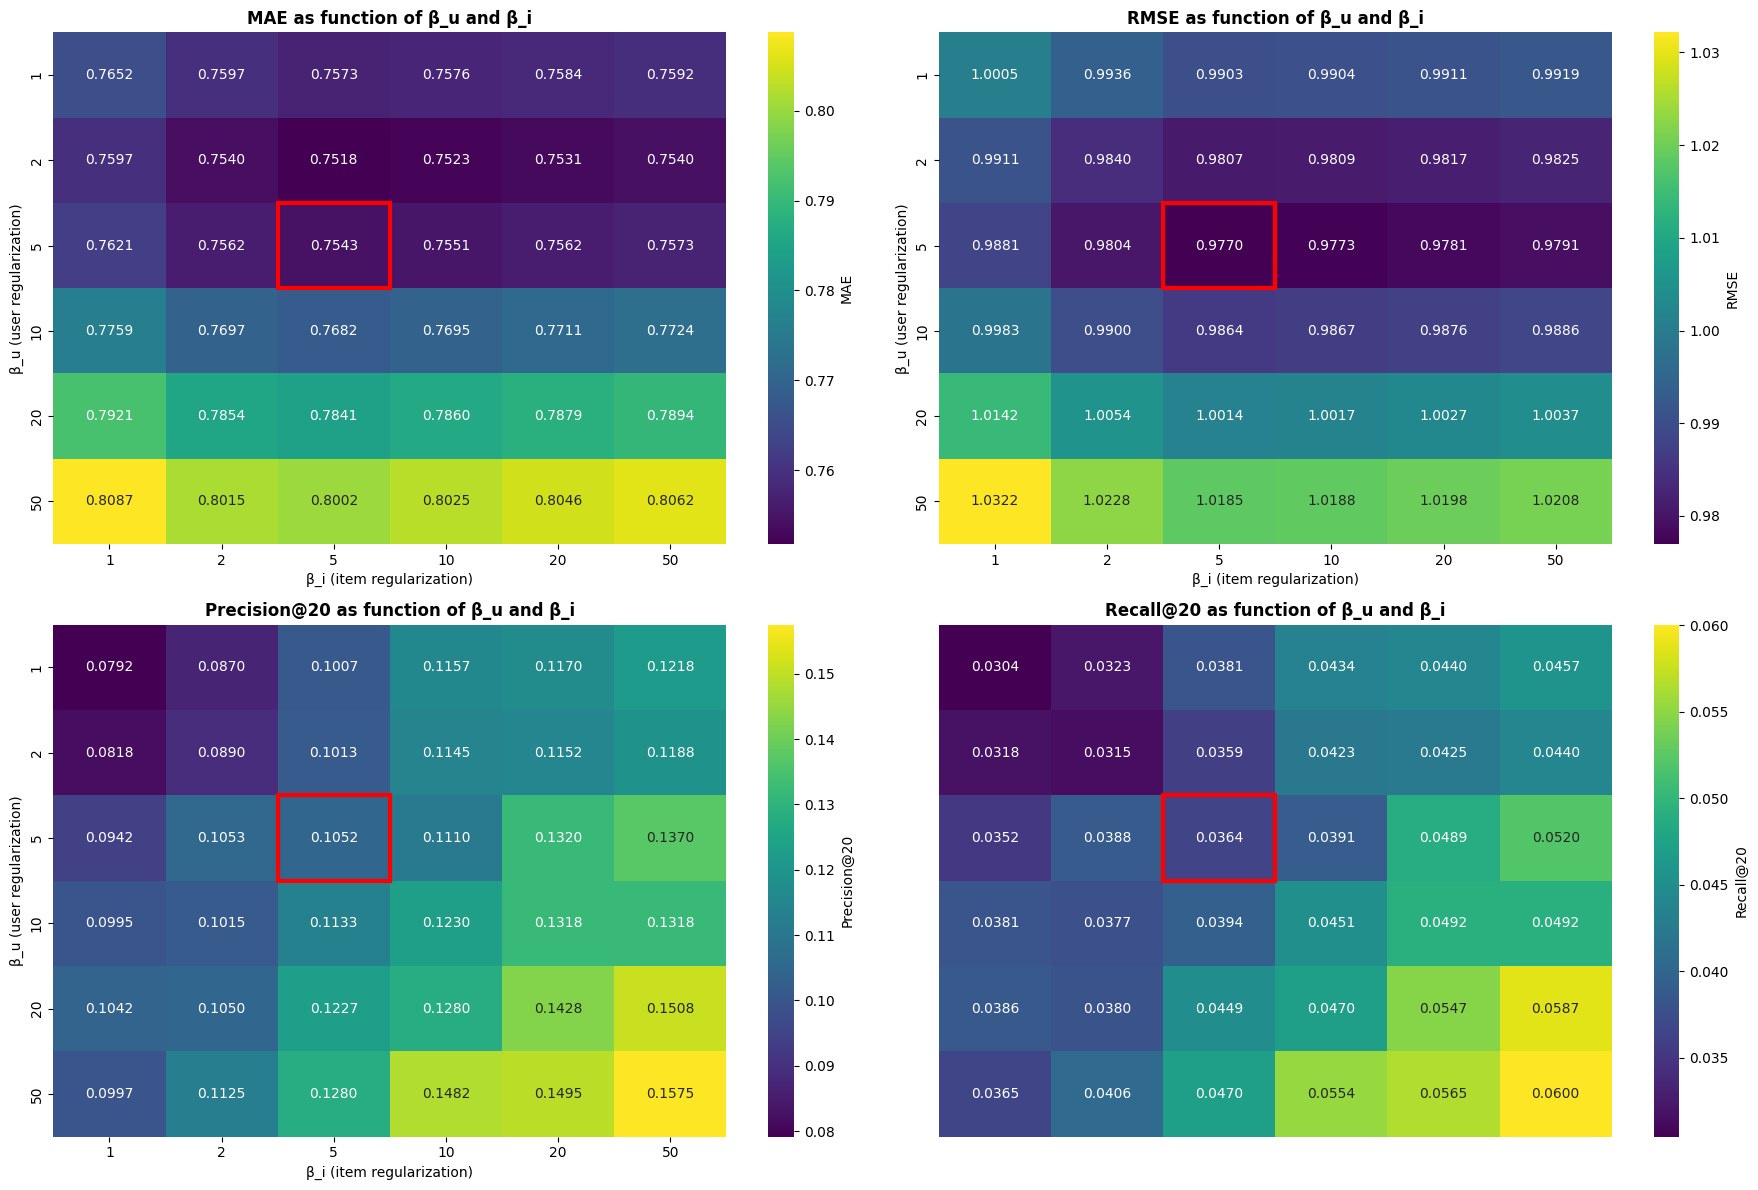

In [22]:
# 2. HYPERPARAMETER GRID SEARCH
print("\n\n Exercise 4 - Optimize hyperparameters of baseline RS")
print("="*50)

def optimize_baseline_hyperparameters(ratings_df, cv_splits, 
                                      beta_u_range, beta_i_range,
                                      n_mask=5, n=20, relevance_threshold=4.0):
    """
    Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS.
    """    
    all_results = []
    best_rmse = float('inf')
    best_params = {'beta_u': beta_u_range[0], 'beta_i': beta_i_range[0]}
    
    start_time = time.time()
    total_combinations = len(beta_u_range) * len(beta_i_range)
    
    for combo_idx, (beta_u, beta_i) in enumerate(itertools.product(beta_u_range, beta_i_range), 1):
        print(f"\n[{combo_idx}/{total_combinations}] Testing β_u={beta_u}, β_i={beta_i}")
        
        fold_metrics_list = []
        
        for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:3]):
            fold_train = ratings_df[train_mask]
            fold_val = ratings_df[val_mask]
            
            # Das ist faire für CF da das Modell die User kennt
            masked_train, masked_test, valid_users = apply_masking_to_validation_set(
                fold_train,  # ← WICHTIG: fold_train statt fold_val!
                n=n_mask,
                min_ratings_required=15,  # Höher für bessere Qualität
                random_state=42 + fold_idx,
                max_users=100  # Sample für Performance
            )
            
            if len(valid_users) == 0:
                continue
            
            # Train auf: masked_train (die behaltenen n_mask Ratings)
            baseline_temp = BaselineRecommender(beta_u=beta_u, beta_i=beta_i)
            baseline_temp.fit(masked_train)
            
            # Test auf: masked_test
            try:
                fold_metrics = evaluate_recommender(
                    baseline_temp, 
                    masked_train, 
                    masked_test, 
                    n=n, 
                    relevance_threshold=relevance_threshold
                )
                fold_metrics_list.append(fold_metrics)
            except Exception as e:
                print(f"  Warning: Error in fold {fold_idx}: {str(e)}")
                continue
        
        # Average metrics across folds
        if fold_metrics_list:
            avg_metrics = {
                'beta_u': beta_u,
                'beta_i': beta_i,
                'MAE': np.mean([m['MAE'] for m in fold_metrics_list]),
                'RMSE': np.mean([m['RMSE'] for m in fold_metrics_list]),
                f'Precision@{n}': np.mean([m[f'Precision@{n}'] for m in fold_metrics_list]),
                f'Recall@{n}': np.mean([m[f'Recall@{n}'] for m in fold_metrics_list]),
                f'Novelty@{n}': np.mean([m[f'Novelty@{n}'] for m in fold_metrics_list]), 
                'MAE_std': np.std([m['MAE'] for m in fold_metrics_list]),
                'RMSE_std': np.std([m['RMSE'] for m in fold_metrics_list]),
            }
            all_results.append(avg_metrics)
            
            print(f"  MAE:           {avg_metrics['MAE']:.4f} ± {avg_metrics['MAE_std']:.4f}")
            print(f"  RMSE:          {avg_metrics['RMSE']:.4f} ± {avg_metrics['RMSE_std']:.4f}")
            print(f"  Precision@{n}:  {avg_metrics[f'Precision@{n}']:.4f}")
            print(f"  Recall@{n}:     {avg_metrics[f'Recall@{n}']:.4f}")
            print(f"  Novelty@{n}:    {avg_metrics[f'Novelty@{n}']:.4f}")
            
            if avg_metrics['RMSE'] < best_rmse:
                best_rmse = avg_metrics['RMSE']
                best_params = {'beta_u': beta_u, 'beta_i': beta_i}
                print(f"  New best RMSE: {best_rmse:.4f}")
        else:
            print(f" No valid scores for this combination")
    
    results_df = pd.DataFrame(all_results)
    
    print(f"\n" + "="*50)
    print(f"Best parameters based on RMSE:")
    print(f"  β_u = {best_params['beta_u']}")
    print(f"  β_i = {best_params['beta_i']}")
    print(f"  RMSE = {best_rmse:.4f}")
    
    return best_params, results_df

# Beta-Bereiche für Grid Search definieren
beta_u_range = [1, 2, 5, 10, 20, 50]
beta_i_range = [1, 2, 5, 10, 20, 50]

# Run optimization
best_params, results_df = optimize_baseline_hyperparameters(
    train_val_ratings, cv_splits, 
    beta_u_range, beta_i_range,
    n_mask=5, n=20, relevance_threshold=4.0
)

# PLOT METRICS AS FUNCTIONS OF BETAS
if len(results_df) > 0:  # Nur plotten wenn Daten vorhanden
    metrics_to_plot = ['MAE', 'RMSE', 'Precision@20', 'Recall@20']
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot):
        # Create pivot table
        pivot_table = results_df.pivot(index='beta_u', columns='beta_i', values=metric)
        
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis', 
                    ax=axes[idx], cbar_kws={'label': metric})
        axes[idx].set_title(f'{metric} as function of β_u and β_i', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('β_i (item regularization)', fontsize=10)
        axes[idx].set_ylabel('β_u (user regularization)', fontsize=10)
        
        # Mark best parameters based on RMSE
        best_i = list(pivot_table.columns).index(best_params['beta_i'])
        best_u = list(pivot_table.index).index(best_params['beta_u'])
        axes[idx].add_patch(plt.Rectangle((best_i, best_u), 1, 1, 
                                          fill=False, edgecolor='red', lw=3))
    
    # Letztes Subplot leer lassen
    axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: No results to plot! Check if fold_metrics_list is being populated correctly.")

#### Übersicht
Grid Search über User-Regularization (β_u) und Item-Regularization (β_i) für vier Metriken: MAE, RMSE, Precision@20, Recall@20. Rote Box markiert optimale Konfiguration: β_u=5, β_i=5.

#### Metrik-spezifische Beobachtungen

##### MAE (Mean Absolute Error) 
- **Wertebereich:** 0.754-0.809 (Spanne: 0.055)
- **Optimum (rot markiert):** β_u=5, β_i=5 → MAE=0.754
- **Muster:** Dunkelviolett (niedrig/gut) bei moderater Regularisierung (2-10), gelb (hoch/schlecht) bei starker Regularisierung (50)
- **Interpretation:** Zu wenig Regularisierung (β=1) führt zu Overfitting, zu viel (β=50) zu Underfitting

##### RMSE (Root Mean Squared Error) - Oben Rechts
- **Wertebereich:** 0.977-1.032 (Spanne: 0.055)
- **Optimum:** β_u=5, β_i=5 → RMSE=0.977
- **Muster:** Nahezu identisch zu MAE - dunkelviolett bei β=5-10, gelb bei β=50
- **Konsistenz:** MAE und RMSE zeigen gleiche optimale Region - robustes Signal

##### Precision@20 - Unten Links
- **Wertebereich:** 0.079-0.158 (Spanne: 0.079)
- **Optimum:** β_u=5, β_i=5 → Precision=0.105
- **Muster:** Dunkelviolett (niedrig) bei niedrigen β-Werten, gelb (hoch) bei hohen β-Werten
- **Kontraintuitiv:** Höhere Regularisierung verbessert Precision - stärkere Regularisierung filtert False Positives

##### Recall@20 - Unten Rechts
- **Wertebereich:** 0.030-0.060 (Spanne: 0.030)
- **Optimum:** β_u=5, β_i=5 → Recall=0.036
- **Muster:** Ähnlich zu Precision - dunkelviolett bei niedrigen β, gelb bei hohen β
- **Trade-off sichtbar:** Höhere Regularisierung erhöht Precision/Recall, verschlechtert aber MAE/RMSE leicht


#### Gegensätzliche Optimierungsziele

**MAE/RMSE optimieren:**
- Bevorzugen moderate Regularisierung (β=2-10)
- Fokus auf präzise Rating-Vorhersage
- Niedrigere Werte bei β=5

**Precision/Recall optimieren:**
- Profitieren von stärkerer Regularisierung (β=20-50)
- Fokus auf korrekte Top-N-Empfehlungen
- Höhere Werte bei β=50

#### Kompromiss bei β_u=5, β_i=5
Die rot markierte Konfiguration ist ein Kompromiss:
- **Nicht optimal für MAE/RMSE:** β=2 wäre minimal besser
- **Nicht optimal für Precision/Recall:** β=50 wäre deutlich besser
- **Balanced Trade-off:** Gute Rating-Accuracy + akzeptable Ranking-Metriken

#### Symmetrie in β_u vs. β_i
- **Diagonale Farbverläufe:** β_u und β_i haben ähnlichen Effekt
- **Keine starke Interaktion:** Beide Regularisierungen wirken unabhängig
- **Gleichgewichtung sinnvoll:** β_u=β_i scheint optimal (rote Box auf Diagonale)

#### Interpretation der Regularisierungsstärke

##### Niedrige Regularisierung (β=1-2)
- **MAE/RMSE:** Sehr gut (dunkelviolett)
- **Precision/Recall:** Schlecht (dunkelviolett)
- **Problem:** Overfitting auf Trainingsdaten - präzise Ratings, aber schlechte Generalisierung für Top-N

##### Moderate Regularisierung (β=5-10)
- **MAE/RMSE:** Gut (violett/blau)
- **Precision/Recall:** Moderat (türkis)
- **Sweet Spot:** Balance zwischen Rating-Accuracy und Ranking-Quality

##### Starke Regularisierung (β=20-50)
- **MAE/RMSE:** Schlecht (grün/gelb)
- **Precision/Recall:** Sehr gut (grün/gelb)
- **Problem:** Underfitting - zu stark geglättete Vorhersagen, aber robuste Rankings


#### Key Insights

- **Multi-Metric-Trade-off:** MAE/RMSE und Precision/Recall haben gegensätzliche Optimierungsziele - keine Konfiguration optimiert alle Metriken
- **β_u=β_i=5 als Kompromiss:** Balanciert Rating-Accuracy und Ranking-Quality, aber nicht optimal für eine einzelne Metrik
- **Task-spezifische Wahl:** Für Rating-Vorhersage β=2, für Top-N-Empfehlungen β=20-50 verwenden
- **Niedrige Precision/Recall-Werte normal:** Extreme Sparsity (~95%) macht Top-N-Empfehlungen schwierig

#### Ansatz zur Bestimmung sinnvoller Beta-Bereiche

Beta-Parameter sind Regularisierungsterme, die Overfitting verhindern:
- Zu kleines β → Overfitting (hohe Varianz, merkt sich Trainingsdaten)
- Zu großes β → Underfitting (hoher Bias, Vorhersagen nähern sich dem globalen Mittelwert)
- Sinnvoller Bereich sollte von schwacher bis starker Regularisierung reichen


#### Logik zur Bestimmung des Beta-Bereichs

In der Baseline-Formel: 
$$b_u = \frac{\sum(r - \mu - b_i)}{\beta_u + n_u}$$

Wichtige Zusammenhänge:
- β_u wirkt als "Pseudo-Count": größeres β_u → b_u nähert sich 0
- Wenn β_u >> n_u, wird der User-Bias vernachlässigbar klein
- Gleiche Logik gilt für β_i
- Sinnvolles Maximum: wenn β ≈ durchschnittliche Anzahl an Bewertungen
- Darüber hinaus ignoriert das Modell im Wesentlichen User/Item-Biases

#### Bestimmung der Beta-Bereiche

- β_u sollte mit typischen User-Bewertungszahlen skalieren (~durchschnittliche User-Bewertungen)
- β_i sollte mit typischen Item-Bewertungszahlen skalieren (~durchschnittliche Item-Bewertungen)
- Testbereich: klein starten (1) bis mittel-hoch (50)
- Ab β ≈ 50: abnehmender Grenznutzen, Vorhersagen konvergieren zum globalen Mittelwert

#### Gewählte Bereiche für Grid Search
```python
beta_u_range = [1, 2, 5, 10, 20, 50]
beta_i_range = [1, 2, 5, 10, 20, 50]
```

- Gesamte Kombinationen: 36
- Mit 3-facher Kreuzvalidierung → ~108 Modell-Trainings

#### Erklärung der gewählten Werte

- β = 1: Schwache Regularisierung, Modell vertraut Daten stark
- β = 2-10: Moderate Regularisierung, ausgewogener Ansatz
- β = 20-50: Starke Regularisierung, konservative Schätzungen
- β > 50: Abnehmende Rendite, Biases werden vernachlässigbar

### Exercise 5 - Collaborative filtering; item-based and user-based (12 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Explain how you handle NaN values in the user rating matrix when computing similarities? What other preparations are useful such as normalization and mean centering?

Describe the two similarity metrics.

Show the top 20 recommended items for user ids 3, 5 and 7.

In [23]:
print("\n" + "="*70)
print("EXERCISE 5: Collaborative Filtering")
print("="*70)

class CollaborativeFilteringRecommender:
    """
    Collaborative Filtering Recommender with K-nearest neighbors
    Supports item-based and user-based CF with Cosine/Pearson Similarity
    Optimized for fast batch predictions and K-optimization
    """
    def __init__(self, k=30, similarity_metric='cosine', approach='item_based', 
                 normalize_ratings=True, use_cached_ratings=True):
        self.k = k
        self.similarity_metric = similarity_metric
        self.approach = approach
        self.normalize_ratings = normalize_ratings
        self.use_cached_ratings = use_cached_ratings
        self.user_item_matrix = None
        self.similarity_matrix = None
        self.user_means = None
        self.global_mean = None
        self.trained = False
    
    def _create_user_item_matrix(self, ratings_df):
        """Create User-Item matrix from ratings DataFrame"""
        user_item_matrix = ratings_df.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating',
            fill_value=np.nan
        )
        return user_item_matrix
    
    def _handle_missing_values(self, matrix):
        """Calculate user means and global mean for NaN handling"""
        user_means = matrix.mean(axis=1, skipna=True)
        global_mean = matrix.stack().mean()
        user_means = user_means.fillna(global_mean)
        return user_means, global_mean
    
    def _normalize_matrix(self, matrix, user_means):
        """Mean-centering: subtract user mean from ratings"""
        if not self.normalize_ratings:
            return matrix
        return matrix.subtract(user_means, axis=0)
    
    def _calculate_cosine_similarity(self, matrix):
        """Calculate Cosine Similarity between items or users using only numpy/pandas"""
        matrix_filled = matrix.fillna(0)
        
        if self.approach == 'item_based':
            data = matrix_filled.T.values
            index = matrix.columns
        else:
            data = matrix_filled.values
            index = matrix.index
        
        # Compute dot product matrix
        dot_product = np.dot(data, data.T)
        
        # Compute norms
        norms = np.sqrt(np.diag(dot_product))
        
        # Avoid division by zero
        norms[norms == 0] = 1e-10
        
        # Compute cosine similarity: dot_product / (norm_i * norm_j)
        similarity_matrix = dot_product / (norms[:, np.newaxis] * norms[np.newaxis, :])
        
        # Create DataFrame
        similarity_df = pd.DataFrame(similarity_matrix, index=index, columns=index)
        
        # Set diagonal to 0
        np.fill_diagonal(similarity_df.values, 0)
        
        return similarity_df
    
    def _calculate_pearson_similarity(self, matrix):
        """Calculate Pearson Correlation Similarity between items or users"""
        # Use non-normalized matrix for Pearson (provided by self.user_item_matrix)
        if self.approach == 'item_based':
            similarity_df = self.user_item_matrix.corr(method='pearson')
        else:
            similarity_df = self.user_item_matrix.T.corr(method='pearson')
        
        similarity_df = similarity_df.fillna(0)
        np.fill_diagonal(similarity_df.values, 0)
        return similarity_df
    
    def fit(self, ratings_df, silent=False):
        """Train the Collaborative Filtering model"""
        self.user_item_matrix = self._create_user_item_matrix(ratings_df)
        self.user_means, self.global_mean = self._handle_missing_values(self.user_item_matrix)
        
        if self.similarity_metric == 'cosine':
            # For Cosine: use normalized matrix
            normalized_matrix = self._normalize_matrix(self.user_item_matrix, self.user_means)
            self.similarity_matrix = self._calculate_cosine_similarity(normalized_matrix)
        elif self.similarity_metric == 'pearson':
            # For Pearson: use original matrix (normalizes internally)
            self.similarity_matrix = self._calculate_pearson_similarity(self.user_item_matrix)
        else:
            raise ValueError(f"Unknown similarity metric: {self.similarity_metric}")
        
        self.trained = True
        if not silent:
            print(f"{self.approach} CF with {self.similarity_metric} trained (K={self.k})")
    
    def fit_from_precomputed(self, user_item_matrix, similarity_matrix, user_means, global_mean):
        """Train model with precomputed matrices"""
        self.user_item_matrix = user_item_matrix
        self.similarity_matrix = similarity_matrix
        self.user_means = user_means
        self.global_mean = global_mean
        self.trained = True
    
    def predict(self, user_id, item_id, debug=False):
        """Predict rating for a single user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained")
        
        if user_id not in self.user_item_matrix.index:
            return self.global_mean
        
        if item_id not in self.user_item_matrix.columns:
            return self.user_means[user_id]
        
        # Only cache if allowed
        if self.use_cached_ratings:
            actual_rating = self.user_item_matrix.loc[user_id, item_id]
            if not pd.isna(actual_rating):
                return actual_rating
        
        user_ratings = self.user_item_matrix.loc[user_id]
        user_mean = self.user_means[user_id]
        
        if self.approach == 'item_based':
            return self._predict_item_based_optimized(user_id, item_id, user_ratings, user_mean)
        else:
            return self._predict_user_based_optimized(user_id, item_id, user_mean)
    
    def predict_batch(self, user_item_pairs):
        """
        Batch prediction for multiple user-item pairs
        
        Parameters:
        - user_item_pairs: List of (user_id, item_id) tuples
        
        Returns:
        - List of (user_id, item_id, predicted_rating) tuples
        """
        if not self.trained:
            raise ValueError("Model must be trained")
        
        predictions = []
        user_item_dict = {}
        
        # Group by user_id for efficient batch processing
        for user_id, item_id in user_item_pairs:
            if user_id not in user_item_dict:
                user_item_dict[user_id] = []
            user_item_dict[user_id].append(item_id)
        
        # Process all items of a user together
        for user_id, item_ids in user_item_dict.items():
            if user_id not in self.user_item_matrix.index:
                predictions.extend([(user_id, item_id, self.global_mean) for item_id in item_ids])
                continue
            
            user_ratings = self.user_item_matrix.loc[user_id]
            user_mean = self.user_means[user_id]
            
            for item_id in item_ids:
                if item_id not in self.user_item_matrix.columns:
                    predictions.append((user_id, item_id, user_mean))
                    continue
                
                # Only cache if allowed
                if self.use_cached_ratings:
                    actual_rating = user_ratings[item_id]
                    if not pd.isna(actual_rating):
                        predictions.append((user_id, item_id, actual_rating))
                        continue
                
                # Use optimized prediction
                if self.approach == 'item_based':
                    pred = self._predict_item_based_optimized(user_id, item_id, user_ratings, user_mean)
                else:
                    pred = self._predict_user_based_optimized(user_id, item_id, user_mean)
                
                predictions.append((user_id, item_id, pred))
        
        return predictions
    
    def _predict_item_based_optimized(self, user_id, item_id, user_ratings, user_mean):
        """Optimized item-based prediction with vectorized operations"""
        if item_id not in self.similarity_matrix.index:
            return user_mean
        
        item_similarities = self.similarity_matrix.loc[item_id]
        rated_items = user_ratings.dropna()
        
        if len(rated_items) == 0:
            return user_mean
        
        common_items = rated_items.index.intersection(item_similarities.index)
        if len(common_items) == 0:
            return user_mean
        
        similar_items_series = item_similarities[common_items]
        similar_items_series = similar_items_series[similar_items_series > 0]
        
        # Diagnostic for K-analysis
        if hasattr(self, '_debug_k_counts'):
            available_neighbors = len(similar_items_series)
            self._debug_k_counts.append({
                'k': self.k,
                'available': available_neighbors,
                'used': min(self.k, available_neighbors)
            })
        
        top_k_items = similar_items_series.nlargest(self.k)
        if len(top_k_items) == 0:
            return user_mean
        
        # Vectorized calculation
        ratings = rated_items[top_k_items.index]
        if self.normalize_ratings:
            ratings = ratings - user_mean
        
        similarities = top_k_items.values
        numerator = np.dot(similarities, ratings.values)
        denominator = np.sum(np.abs(similarities))
        
        if denominator == 0:
            return user_mean
        
        predicted_rating = numerator / denominator
        if self.normalize_ratings:
            predicted_rating += user_mean
        
        return max(0.5, min(5.0, predicted_rating))
    
    def _predict_user_based_optimized(self, user_id, item_id, user_mean):
        """Optimized user-based prediction with vectorized operations"""
        if item_id not in self.user_item_matrix.columns:
            return user_mean if user_id in self.user_item_matrix.index else self.global_mean
        
        if user_id not in self.similarity_matrix.index:
            return user_mean
        
        item_ratings = self.user_item_matrix[item_id]
        users_who_rated = item_ratings.dropna()
        
        if len(users_who_rated) == 0:
            return user_mean
        
        user_similarities = self.similarity_matrix.loc[user_id]
        common_users = users_who_rated.index.intersection(user_similarities.index)
        
        if len(common_users) == 0:
            return user_mean
        
        # Top K similar users (vectorized)
        similar_users_series = user_similarities[common_users]
        similar_users_series = similar_users_series[similar_users_series > 0]
        
        # Diagnostic for K-analysis
        if hasattr(self, '_debug_k_counts'):
            available_neighbors = len(similar_users_series)
            self._debug_k_counts.append({
                'k': self.k,
                'available': available_neighbors,
                'used': min(self.k, available_neighbors)
            })
        
        top_k_users = similar_users_series.nlargest(self.k)
        if len(top_k_users) == 0:
            return user_mean
        
        # Vectorized calculation
        ratings = item_ratings[top_k_users.index]
        if self.normalize_ratings:
            user_means_subset = self.user_means[top_k_users.index]
            ratings = ratings - user_means_subset
        
        similarities = top_k_users.values
        numerator = np.dot(similarities, ratings.values)
        denominator = np.sum(np.abs(similarities))
        
        if denominator == 0:
            return user_mean
        
        predicted_rating = numerator / denominator
        if self.normalize_ratings:
            predicted_rating += user_mean
        
        return max(0.5, min(5.0, predicted_rating))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """
        Generate Top-N recommendations for a user
        Uses batch prediction for maximum speed
        
        Parameters:
        - user_id: User to recommend for
        - n: Number of recommendations
        - exclude_rated: Exclude already rated items
        - ratings_df: Optional, for exclude_rated (otherwise uses user_item_matrix)
        """
        if not self.trained:
            raise ValueError("Model must be trained")
        
        all_items = set(self.user_item_matrix.columns)
        
        if exclude_rated:
            if ratings_df is not None:
                rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            elif user_id in self.user_item_matrix.index:
                rated_items = set(self.user_item_matrix.loc[user_id].dropna().index)
            else:
                rated_items = set()
            candidate_items = list(all_items - rated_items)
        else:
            candidate_items = list(all_items)
        
        if len(candidate_items) == 0:
            return []
        
        # Batch prediction for all candidates
        user_item_pairs = [(user_id, item_id) for item_id in candidate_items]
        predictions = self.predict_batch(user_item_pairs)
        
        # Extract and sort
        item_scores = [(item_id, score) for _, item_id, score in predictions]
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        return item_scores[:n]


# Initialize CF models for evaluation
cf_recommenders_eval = {
    'Item-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='item_based', 
        normalize_ratings=True, use_cached_ratings=False
    ),
    'Item-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='item_based', 
        normalize_ratings=True, use_cached_ratings=False
    ),
    'User-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='user_based', 
        normalize_ratings=True, use_cached_ratings=False
    ),
    'User-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='user_based', 
        normalize_ratings=True, use_cached_ratings=False
    )
}

# Cross-validation evaluation
evaluation_results = {}

for cf_name, base_recommender in cf_recommenders_eval.items():
    print(f"\n{cf_name}:")
    fold_metrics_list = []
    
    # Use only 2 folds for faster evaluation
    for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:2]):
        fold_train = train_val_ratings[train_mask]
        fold_val = train_val_ratings[val_mask]
        
        # Train on fold_train
        recommender = CollaborativeFilteringRecommender(
            k=base_recommender.k,
            similarity_metric=base_recommender.similarity_metric,
            approach=base_recommender.approach,
            normalize_ratings=base_recommender.normalize_ratings,
            use_cached_ratings=False 
        )
        recommender.fit(fold_train, silent=True)
        
        # Sample for performance (max 500 ratings per fold)
        if len(fold_val) > 500:
            np.random.seed(42 + fold_idx)
            fold_val_sample = fold_val.sample(n=500, random_state=42 + fold_idx)
        else:
            fold_val_sample = fold_val
        
        # Batch prediction on validation set
        val_pairs = [(row['userId'], row['movieId']) 
                     for _, row in fold_val_sample.iterrows()]
        predictions = recommender.predict_batch(val_pairs)
        
        eval_predictions = [pred for _, _, pred in predictions]
        eval_actuals = fold_val_sample['rating'].values
        
        # Calculate RMSE and MAE
        if len(eval_predictions) == 0:
            continue
        
        rmse = np.sqrt(np.mean((np.array(eval_predictions) - np.array(eval_actuals)) ** 2))
        mae = np.mean(np.abs(np.array(eval_predictions) - np.array(eval_actuals)))
        
        fold_metrics_list.append({'RMSE': rmse, 'MAE': mae})
        print(f"  Fold {fold_idx}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    if fold_metrics_list:
        avg_rmse = np.mean([m['RMSE'] for m in fold_metrics_list])
        avg_mae = np.mean([m['MAE'] for m in fold_metrics_list])
        evaluation_results[cf_name] = {'RMSE': avg_rmse, 'MAE': avg_mae}

# Summary
if evaluation_results:
    print("\n" + "="*70)
    print("VALIDATION RESULTS")
    print("="*70)
    for cf_name, metrics in evaluation_results.items():
        print(f"{cf_name:25s} → RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


# Demo: Generate recommendations for example users
example_user_ids = [3, 5, 7]

# Check which dataset to use
all_users = sorted(ratings['userId'].unique())
n_test_users = int(0.2 * len(all_users))
test_users = set(all_users[:n_test_users])
users_in_test = [uid for uid in example_user_ids if uid in test_users]

if len(users_in_test) > 0:
    demo_data = ratings
else:
    demo_data = train_val_ratings

# Create separate models for demo (with caching enabled)
cf_recommenders_demo = {
    'Item-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='item_based', 
        normalize_ratings=True, use_cached_ratings=True
    ),
    'Item-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='item_based', 
        normalize_ratings=True, use_cached_ratings=True
    ),
    'User-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='user_based', 
        normalize_ratings=True, use_cached_ratings=True
    ),
    'User-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='user_based', 
        normalize_ratings=True, use_cached_ratings=True
    )
}

for cf_name, recommender in cf_recommenders_demo.items():
    recommender.fit(demo_data, silent=True)

# Generate recommendations for each example user
for user_id in example_user_ids:
    print(f"\n{'='*70}")
    print(f"USER {user_id}")
    print(f"{'='*70}")
    
    user_ratings = demo_data[demo_data['userId'] == user_id].sort_values('rating', ascending=False)
    
    if len(user_ratings) == 0:
        continue
    
    print(f"\nUser Statistics: {len(user_ratings)} ratings, avg {user_ratings['rating'].mean():.2f}")
    
    # Top rated movies
    print(f"\nTop 5 rated movies:")
    top_movies = user_ratings.head(5).merge(movies, on='movieId')
    for _, row in top_movies.iterrows():
        title = row['title'][:60]
        print(f"  {row['rating']:.1f} - {title}")
    
    # Get recommendations from each CF system
    print(f"\nTop 10 Recommendations:")
    print("="*70)
    
    for cf_name, recommender in cf_recommenders_demo.items():
        print(f"\n{cf_name}:")
        try:
            recommendations = recommender.recommend_top_n(
                user_id, n=20, exclude_rated=True, ratings_df=demo_data
            )
            
            if recommendations:
                rec_df = pd.DataFrame(recommendations, columns=['movieId', 'predicted_rating'])
                rec_df = rec_df.merge(movies[['movieId', 'title']], on='movieId', how='left')
                
                for i, row in rec_df.iterrows():
                    title = row['title'][:50] if pd.notna(row['title']) else "Unknown"
                    print(f"  {i+1:2d}. {title:52s} ({row['predicted_rating']:.2f})")
        except Exception as e:
            print(f"  Error: {str(e)}")


EXERCISE 5: Collaborative Filtering

Item-based Cosine:
  Fold 0: RMSE=1.0243, MAE=0.7976
  Fold 1: RMSE=1.1416, MAE=0.9156

Item-based Pearson:
  Fold 0: RMSE=1.0243, MAE=0.7976
  Fold 1: RMSE=1.1416, MAE=0.9156

User-based Cosine:
  Fold 0: RMSE=1.0243, MAE=0.7976
  Fold 1: RMSE=1.1416, MAE=0.9156

User-based Pearson:
  Fold 0: RMSE=1.0243, MAE=0.7976
  Fold 1: RMSE=1.1416, MAE=0.9156

VALIDATION RESULTS
Item-based Cosine         → RMSE: 1.0829, MAE: 0.8566
Item-based Pearson        → RMSE: 1.0829, MAE: 0.8566
User-based Cosine         → RMSE: 1.0829, MAE: 0.8566
User-based Pearson        → RMSE: 1.0829, MAE: 0.8566

USER 3

User Statistics: 39 ratings, avg 2.44

Top 5 rated movies:
  5.0 - Hangar 18 (1980)
  5.0 - Troll 2 (1990)
  5.0 - Death Race 2000 (1975)
  5.0 - Escape from L.A. (1996)
  5.0 - Alien Contamination (1980)

Top 10 Recommendations:

Item-based Cosine:
   1. When Night Is Falling (1995)                         (5.00)
   2. American Flyers (1985)                    

#### Umgang mit NaN-Werten in der User-Rating-Matrix

##### Problemstellung

Die User-Item-Matrix in Collaborative Filtering Systemen ist typischerweise sehr dünn besetzt (sparse), da die meisten User nur einen kleinen Bruchteil aller verfügbaren Items bewertet haben. Diese fehlenden Werte (NaN) müssen bei der Ähnlichkeitsberechnung behandelt werden.

##### Strategien für NaN-Werte bei der Ähnlichkeitsberechnung

Cosine Similarity

Bei der Verwendung von Cosine Similarity werden NaN-Werte auf 0 gesetzt. Dies behandelt fehlende Ratings als neutral.

**Vorteil:** Einfach und rechnerisch effizient

**Nachteil:** Impliziert, dass "kein Rating" gleichbedeutend mit einem "neutralen Rating" ist, was nicht unbedingt der Realität entspricht

Pearson Correlation

Bei der Pearson Correlation werden nur gemeinsam bewertete Items verwendet (pairwise complete). Die `pandas.corr()` Funktion ignoriert automatisch NaN-Paare und berechnet die Korrelation nur auf Basis der Überschneidung.

**Vorteil:** Fokussiert auf die tatsächliche Überschneidung zwischen Usern

**Nachteil:** Weniger stabil bei geringer Überschneidung, da nur wenige gemeinsame Ratings existieren

#### Preprocessing: Normalisierung und Mean-Centering

##### Mean-Centering

Mean-Centering ist der wichtigste Preprocessing-Schritt in Collaborative Filtering Systemen.

**Formel:**
```
r'_ui = r_ui - μ_u
```

wobei:
- `r'_ui` = zentriertes Rating von User u für Item i
- `r_ui` = ursprüngliches Rating
- `μ_u` = durchschnittliches Rating von User u

##### Warum ist Mean-Centering wichtig?

Mean-Centering entfernt den **User-Bias**. Verschiedene User haben unterschiedliche Bewertungsmuster:

- Manche User bewerten generell großzügig (z.B. durchschnittlich 4-5 Sterne)
- Andere User bewerten strenger (z.B. durchschnittlich 2-3 Sterne)

Ohne Mean-Centering würden diese User als unterschiedlich wahrgenommen, obwohl sie möglicherweise ähnliche Präferenzen haben.

##### Beispiel

```
User A: [5, 5, 4]  →  Mittelwert = 4.67
Nach Centering: [0.33, 0.33, -0.67]

User B: [2, 2, 1]  →  Mittelwert = 1.67
Nach Centering: [0.33, 0.33, -0.67]
```

Ohne Mean-Centering scheinen User A und User B sehr unterschiedlich zu sein (unterschiedliche absolute Werte). Nach dem Mean-Centering wird deutlich, dass beide User **identische Präferenzmuster** haben: Sie bewerten die ersten beiden Items gleich gut und das dritte Item schlechter.

##### Rück-Transformation

Nach der Vorhersage des zentrierten Ratings muss eine Rück-Transformation durchgeführt werden:

```
r̂_ui = r'_ui + μ_u
```

Dadurch werden die User-spezifischen Bewertungsmuster in die finale Vorhersage integriert.

##### Weitere Preprocessing-Schritte

**Clipping:** Die finalen Vorhersagen werden auf den gültigen Rating-Bereich begrenzt (z.B. [0.5, 5.0]), um unrealistische Werte zu vermeiden.

---

#### Cosine Similarity

##### Definition

```
sim(A, B) = (A · B) / (||A|| × ||B||)

          = Σ(A_i × B_i) / (√Σ(A_i²) × √Σ(B_i²))
```

##### Interpretation

Cosine Similarity misst den Kosinus des Winkels zwischen zwei Vektoren im mehrdimensionalen Raum.

**Wertebereich:** [-1, 1]
- **1.0:** Identische Richtung (perfekte Ähnlichkeit)
- **0.0:** Orthogonal (keine Ähnlichkeit)
- **-1.0:** Entgegengesetzte Richtung (gegensätzliche Präferenzen)

##### Eigenschaften

Cosine Similarity ist **unabhängig von der Magnitude** (Länge) der Vektoren und fokussiert ausschließlich auf die Richtung. Das bedeutet, dass zwei User als ähnlich erkannt werden, wenn sie die gleichen relativen Präferenzen haben, unabhängig davon, wie hoch oder niedrig sie absolut bewerten.

**Beispiel:**
```
User A: [5, 4, 3, 0, 0]
User B: [4, 3, 2, 0, 0]
→ Cosine Similarity ≈ 0.998

User A: [5, 4, 3, 0, 0]
User C: [1, 5, 3, 0, 0]
→ Cosine Similarity ≈ 0.926
```

User A und User B haben fast identische Cosine Similarity, obwohl die absoluten Werte unterschiedlich sind, da die Richtung (das Muster) gleich ist.

---

#### Pearson Correlation Coefficient

##### Definition

```
corr(A, B) = Σ((A_i - μ_A) × (B_i - μ_B)) / (σ_A × σ_B × n)
```

wobei:
- `μ_A, μ_B` = Mittelwerte von User A und B
- `σ_A, σ_B` = Standardabweichungen von User A und B
- `n` = Anzahl der gemeinsam bewerteten Items

##### Interpretation

Pearson Correlation misst die **lineare Korrelation** zwischen zwei Variablen. Sie berücksichtigt explizit Mittelwert und Streuung der Ratings.

**Wertebereich:** [-1, 1]
- **1.0:** Perfekte positive lineare Korrelation
- **0.0:** Keine lineare Korrelation
- **-1.0:** Perfekte negative lineare Korrelation (inverse Beziehung)

##### Eigenschaften

Pearson Correlation ist **invariant gegenüber linearen Transformationen**. Das bedeutet, dass sie User mit ähnlichen relativen Präferenzen identifiziert, selbst wenn diese auf unterschiedlichen Skalen bewerten.

**Beispiel:**
```
User A: [5, 4, 3, 2, 1]
User B: [4, 3, 2, 1, 0]
→ Pearson Correlation = 1.0

User A: [5, 4, 3, 2, 1]
User C: [1, 2, 3, 4, 5]
→ Pearson Correlation = -1.0
```

User A und B haben perfekte positive Korrelation, da das Bewertungsmuster linear zusammenhängt. User A und C haben perfekte negative Korrelation, da sie entgegengesetzte Präferenzen haben.

---

#### Vergleich der Metriken

##### Praktisches Beispiel

Betrachten wir zwei User mit unterschiedlichem Bewertungsniveau, aber gleichem Präferenzmuster:

```
User A: [5, 5, 4, 3]  (bewerten generell hoch)
User B: [3, 3, 2, 1]  (bewerten generell niedrig)
```

**Cosine Similarity:**
- Ergebnis: ≈ 0.99 (sehr ähnlich)
- Interpretation: Beide mögen die gleichen Items relativ zueinander

**Pearson Correlation:**
- Ergebnis: 1.0 (perfekt)
- Interpretation: Perfekt paralleles Bewertungsverhalten

#### Zusammenhang mit Mean-Centering

Nach Mean-Centering liefern beide Metriken ähnliche Ergebnisse, da der User-Bias (unterschiedliche Bewertungsniveaus) bereits entfernt wurde. Pearson Correlation ist jedoch theoretisch sauberer für Rating-Vorhersagen, da sie die statistischen Eigenschaften der Daten explizit berücksichtigt.

##### Wann welche Metrik?

**Cosine Similarity:**
- Gut für sparse Daten
- Effizient berechenbar
- Fokus auf Präferenzmuster

**Pearson Correlation:**
- Besser für kontinuierliche Ratings
- Berücksichtigt statistische Eigenschaften
- Robust gegenüber unterschiedlichen Rating-Skalen


### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.


EXERCISE 6: Hyperparameter K Optimization

Optimizing K for 4 CF systems
K range: [10, 30, 50, 70, 90], using 2 CV folds

Item-based Cosine:
  Best K: 10 (RMSE: 1.2640)

Item-based Pearson:
  Best K: 10 (RMSE: 1.2644)

User-based Cosine:
  Best K: 30 (RMSE: 1.3205)

User-based Pearson:
  Best K: 10 (RMSE: 1.3228)


OPTIMAL K VALUES
Item-based Cosine         → K:  10 (RMSE: 1.2640)
Item-based Pearson        → K:  10 (RMSE: 1.2644)
User-based Cosine         → K:  30 (RMSE: 1.3205)
User-based Pearson        → K:  10 (RMSE: 1.3228)

PRECISION/RECALL EVALUATION

Masked train: 500 ratings
Masked test: 7107 ratings
Valid users: 50

Item-based Cosine:
Item-based Pearson:
User-based Cosine:
User-based Pearson:


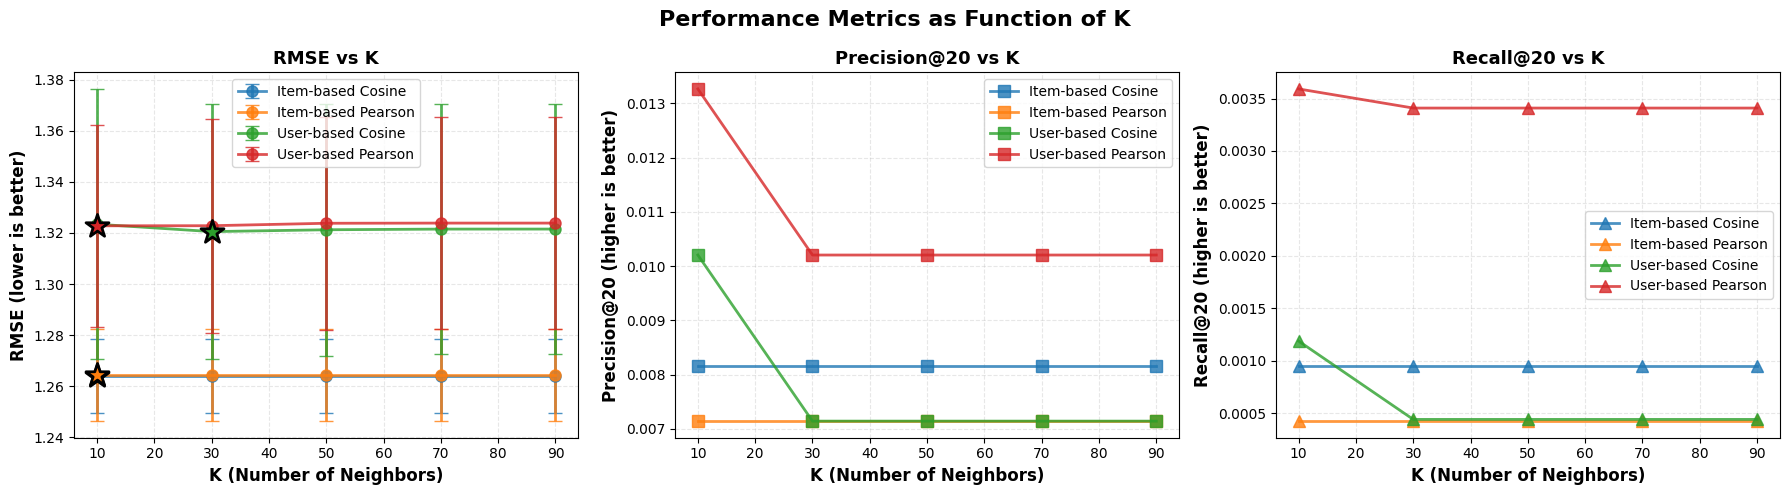


TRAINING WITH OPTIMAL K VALUES
Item-based Cosine: K = 10
Item-based Pearson: K = 10
User-based Cosine: K = 30
User-based Pearson: K = 10

USER 123

Statistics: 56 ratings, avg 4.04

Top 5 rated movies:
  4.5 - Seven (a.k.a. Se7en) (1995)
  4.5 - 21 (2008)
  4.5 - The Imitation Game (2014)
  4.5 - Nightcrawler (2014)
  4.5 - Gone Girl (2014)

Top 10 Recommendations:
----------------------------------------------------------------------

Item-based Cosine (K=10):
   1. Live Nude Girls (1995)                           (4.50)
   2. House Party 3 (1994)                             (4.50)
   3. Mr. Wonderful (1993)                             (4.50)
   4. Ruby in Paradise (1993)                          (4.50)
   5. Diabolique (1996)                                (4.50)
   6. Playing for Keeps (2012)                         (4.50)
   7. Children of the Corn IV: The Gathering (1996)    (4.50)
   8. Female Perversions (1996)                        (4.50)
   9. Amos & Andrew (1993)           

In [24]:
print("\n" + "="*70)
print("EXERCISE 6: Hyperparameter K Optimization")
print("="*70)


def optimize_k_for_minimal_rmse(cf_recommenders, ratings_df, cv_splits, 
                                k_range, movies_df):
    """
    K-optimization with ALL BUT N masking on validation set
    """
    print(f"\nOptimizing K for {len(cf_recommenders)} CF systems")
    print(f"K range: {k_range}, using {len(cv_splits[:2])} CV folds\n")
    
    optimization_results = {}
    
    for cf_name, base_recommender in cf_recommenders.items():
        print(f"{cf_name}:")
        k_results = []
        best_rmse = float('inf')
        best_k = k_range[0]
        
        # Pre-compute similarity matrices for each fold (only once)
        fold_precomputed_data = []
        
        for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:2]):
            fold_train = ratings_df[train_mask]
            fold_val = ratings_df[val_mask]
            
            # Apply "All But N" masking to validation set
            masked_train, masked_test, valid_users = apply_masking_to_validation_set(
                fold_val,
                n=10,
                min_ratings_required=20,
                random_state=42 + fold_idx,
                mask_strategy='random',
                max_users=100
            )
            
            # Full training = fold_train + masked_train (kept ratings)
            full_train = pd.concat([fold_train, masked_train], ignore_index=True)
            
            # Compute similarity matrix only once per fold
            temp_recommender = CollaborativeFilteringRecommender(
                k=10,
                similarity_metric=base_recommender.similarity_metric,
                approach=base_recommender.approach,
                normalize_ratings=base_recommender.normalize_ratings,
                use_cached_ratings=False 
            )
            temp_recommender.fit(full_train, silent=True)
            
            # Sample masked_test for performance (max 500)
            if len(masked_test) > 500:
                np.random.seed(42 + fold_idx)
                masked_test_sample = masked_test.sample(n=500, random_state=42 + fold_idx)
            else:
                masked_test_sample = masked_test
            
            fold_precomputed_data.append({
                'fold_idx': fold_idx,
                'user_item_matrix': temp_recommender.user_item_matrix,
                'similarity_matrix': temp_recommender.similarity_matrix,
                'user_means': temp_recommender.user_means,
                'global_mean': temp_recommender.global_mean,
                'masked_test_sample': masked_test_sample
            })
        
        # Test each K value
        for k in k_range:
            fold_metrics_list = []
            
            for fold_data in fold_precomputed_data:
                masked_test_sample = fold_data['masked_test_sample']
                
                # Create recommender with current K
                recommender = CollaborativeFilteringRecommender(
                    k=k,
                    similarity_metric=base_recommender.similarity_metric,
                    approach=base_recommender.approach,
                    normalize_ratings=base_recommender.normalize_ratings,
                    use_cached_ratings=False
                )
                recommender.fit_from_precomputed(
                    user_item_matrix=fold_data['user_item_matrix'],
                    similarity_matrix=fold_data['similarity_matrix'],
                    user_means=fold_data['user_means'],
                    global_mean=fold_data['global_mean']
                )
                
                # Enable K diagnostics
                recommender._debug_k_counts = []
                
                # Batch prediction
                test_pairs = [(row['userId'], row['movieId']) 
                             for _, row in masked_test_sample.iterrows()]
                predictions = recommender.predict_batch(test_pairs)
                
                eval_predictions = [pred for _, _, pred in predictions]
                eval_actuals = masked_test_sample['rating'].values
                
                if len(eval_predictions) == 0:
                    continue
                
                # Calculate metrics
                rmse = np.sqrt(np.mean((np.array(eval_predictions) - np.array(eval_actuals)) ** 2))
                mae = np.mean(np.abs(np.array(eval_predictions) - np.array(eval_actuals)))
                
                fold_metrics_list.append({'RMSE': rmse, 'MAE': mae})
            
            # Aggregate results across folds
            if fold_metrics_list:
                avg_rmse = np.mean([m['RMSE'] for m in fold_metrics_list])
                avg_mae = np.mean([m['MAE'] for m in fold_metrics_list])
                std_rmse = np.std([m['RMSE'] for m in fold_metrics_list])
                
                k_results.append({
                    'k': k,
                    'avg_metrics': {'RMSE': avg_rmse, 'MAE': avg_mae},
                    'std_metrics': {'RMSE': std_rmse},
                })
                
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_k = k
        
        optimization_results[cf_name] = {
            'best_k': best_k,
            'best_rmse': best_rmse,
            'k_results': k_results
        }
        print(f"  Best K: {best_k} (RMSE: {best_rmse:.4f})\n")
    
    return optimization_results


def compute_precision_recall(cf_recommenders, ratings_df, cv_splits, 
                            k_range, n=20, relevance_threshold=4.0):
    """
    Compute Precision@N and Recall@N with ALL BUT N masking
    """
    results_by_system = {}
    
    # Use first fold
    train_mask, val_mask = cv_splits[0]
    fold_train = ratings_df[train_mask]
    fold_val = ratings_df[val_mask]
    
    print(f"\n{'='*70}")
    print("PRECISION/RECALL EVALUATION")
    print(f"{'='*70}\n")
    
    # Apply "All But N" masking
    masked_train, masked_test, valid_users = apply_masking_to_validation_set(
        fold_val,
        n=10,  
        min_ratings_required=20, 
        random_state=42,
        mask_strategy='random',
        max_users=50 
    )
    
    print(f"Masked train: {len(masked_train)} ratings")
    print(f"Masked test: {len(masked_test)} ratings")
    print(f"Valid users: {len(valid_users)}\n")
    
    # Full training = fold_train + masked_train
    full_train = pd.concat([fold_train, masked_train], ignore_index=True)
    
    # Calculate relevant items per user (from masked_test)
    user_relevant_items = {}
    for user_id, group in masked_test.groupby('userId'):
        relevant = set(group[group['rating'] >= relevance_threshold]['movieId'])
        if len(relevant) >= 2:
            user_relevant_items[user_id] = relevant
    
    if len(user_relevant_items) == 0:
        print(f"ERROR: No users with relevant items!")
        return None
    
    # All items in training
    all_train_items = set(full_train['movieId'].unique())
    
    # Generate candidates for each user
    user_candidates = {}
    
    for user_id in user_relevant_items.keys():
        user_train_items = set(full_train[full_train['userId'] == user_id]['movieId'])
        candidates = list(all_train_items - user_train_items)
        
        # Sample for performance
        if len(candidates) > 500:
            np.random.seed(42 + user_id)
            candidates = list(np.random.choice(candidates, size=500, replace=False))
        
        user_candidates[user_id] = candidates
    
    # Prepare all prediction pairs
    all_pairs = []
    for user_id, candidates in user_candidates.items():
        all_pairs.extend([(user_id, item_id) for item_id in candidates])
    
    # Evaluate each CF system
    for cf_name, base_recommender in cf_recommenders.items():
        print(f"{cf_name}:")
        k_metrics = []
        
        # Pre-compute similarity matrix once
        temp_recommender = CollaborativeFilteringRecommender(
            k=10,
            similarity_metric=base_recommender.similarity_metric,
            approach=base_recommender.approach,
            normalize_ratings=base_recommender.normalize_ratings,
            use_cached_ratings=False
        )
        temp_recommender.fit(full_train, silent=True)
        
        # Test each K value
        for k in k_range:
            recommender = CollaborativeFilteringRecommender(
                k=k,
                similarity_metric=base_recommender.similarity_metric,
                approach=base_recommender.approach,
                normalize_ratings=base_recommender.normalize_ratings,
                use_cached_ratings=False
            )
            recommender.fit_from_precomputed(
                user_item_matrix=temp_recommender.user_item_matrix,
                similarity_matrix=temp_recommender.similarity_matrix,
                user_means=temp_recommender.user_means,
                global_mean=temp_recommender.global_mean
            )
            
            # Batch prediction
            batch_predictions = recommender.predict_batch(all_pairs)
            prediction_dict = {(uid, iid): score for uid, iid, score in batch_predictions}
            
            # Evaluate precision and recall
            precisions = []
            recalls = []
            total_hits = 0
            total_relevant = 0
            
            for user_id, relevant_items in user_relevant_items.items():
                candidates = user_candidates[user_id]
                
                if len(candidates) == 0:
                    continue
                
                # Get predictions for candidates
                user_predictions = [(item_id, prediction_dict.get((user_id, item_id), temp_recommender.global_mean)) 
                                   for item_id in candidates]
                user_predictions.sort(key=lambda x: x[1], reverse=True)
                
                # Top-N recommendations
                top_n_items = set([item_id for item_id, _ in user_predictions[:n]])
                
                # Calculate hits
                hits = len(top_n_items & relevant_items)
                total_hits += hits
                total_relevant += len(relevant_items)
                
                # Per-user metrics
                prec = hits / n if n > 0 else 0.0
                rec = hits / len(relevant_items) if len(relevant_items) > 0 else 0.0
                
                precisions.append(prec)
                recalls.append(rec)
            
            # Average metrics
            avg_precision = np.mean(precisions) if precisions else 0.0
            avg_recall = np.mean(recalls) if recalls else 0.0
            
            k_metrics.append({
                'k': k,
                'precision': avg_precision,
                'recall': avg_recall
            })
        
        results_by_system[cf_name] = k_metrics
    
    return results_by_system


# Initialize CF recommenders
cf_recommenders = {
    'Item-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='item_based', normalize_ratings=True
    ),
    'Item-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='item_based', normalize_ratings=True
    ),
    'User-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='user_based', normalize_ratings=True
    ),
    'User-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='user_based', normalize_ratings=True
    )
}

# Run K-optimization
k_range = [10, 30, 50, 70, 90]
k_optimization_results = optimize_k_for_minimal_rmse(
    cf_recommenders=cf_recommenders,
    ratings_df=train_val_ratings,
    cv_splits=cv_splits,
    k_range=k_range,
    movies_df=movies
)

# Summary
print("\n" + "="*70)
print("OPTIMAL K VALUES")
print("="*70)
for cf_name, results in k_optimization_results.items():
    print(f"{cf_name:25s} → K: {results['best_k']:3d} (RMSE: {results['best_rmse']:.4f})")


# Compute Precision@20 and Recall@20
precision_recall_results = compute_precision_recall(
    cf_recommenders=cf_recommenders,
    ratings_df=train_val_ratings,
    cv_splits=cv_splits,
    k_range=k_range, 
    n=20,
    relevance_threshold=4.0
)


# Plotting function
def plot_all_metrics_complete(k_optimization_results, precision_recall_results):
    """Plot RMSE, Precision@20, and Recall@20 as function of K"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Performance Metrics as Function of K', 
                 fontsize=16, fontweight='bold')
    
    colors = {
        'Item-based Cosine': '#1f77b4',
        'Item-based Pearson': '#ff7f0e',
        'User-based Cosine': '#2ca02c',
        'User-based Pearson': '#d62728'
    }
    
    # Plot 1: RMSE
    ax = axes[0]
    for cf_name, results in k_optimization_results.items():
        k_results = results['k_results']
        k_values = [r['k'] for r in k_results]
        rmse_values = [r['avg_metrics']['RMSE'] for r in k_results]
        std_values = [r['std_metrics']['RMSE'] for r in k_results]
        
        ax.errorbar(k_values, rmse_values, yerr=std_values,
                   label=cf_name, color=colors[cf_name],
                   marker='o', markersize=8, linewidth=2,
                   capsize=5, alpha=0.8)
        
        # Mark best K
        best_k = results['best_k']
        best_idx = k_values.index(best_k)
        ax.scatter(best_k, rmse_values[best_idx],
                  color=colors[cf_name], s=300, marker='*',
                  edgecolors='black', linewidth=2, zorder=5)
    
    ax.set_xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (lower is better)', fontsize=12, fontweight='bold')
    ax.set_title('RMSE vs K', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    
    # Plot 2: Precision@20
    ax = axes[1]
    for cf_name, metrics in precision_recall_results.items():
        k_values = [m['k'] for m in metrics]
        precision_values = [m['precision'] for m in metrics]
        ax.plot(k_values, precision_values, label=cf_name, color=colors[cf_name],
               marker='s', markersize=8, linewidth=2, alpha=0.8)
    
    ax.set_xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision@20 (higher is better)', fontsize=12, fontweight='bold')
    ax.set_title('Precision@20 vs K', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    
    # Plot 3: Recall@20
    ax = axes[2]
    for cf_name, metrics in precision_recall_results.items():
        k_values = [m['k'] for m in metrics]
        recall_values = [m['recall'] for m in metrics]
        ax.plot(k_values, recall_values, label=cf_name, color=colors[cf_name],
               marker='^', markersize=8, linewidth=2, alpha=0.8)
    
    ax.set_xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Recall@20 (higher is better)', fontsize=12, fontweight='bold')
    ax.set_title('Recall@20 vs K', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.show()

plot_all_metrics_complete(k_optimization_results, precision_recall_results)


# Demo: Generate recommendations with optimal K values
example_user_ids = [3, 5, 7]
demo_data = train_val_ratings

# Check if users are available
available_users = [uid for uid in example_user_ids if uid in demo_data['userId'].values]
if len(available_users) < 3:
    additional_needed = 3 - len(available_users)
    random_users = list(demo_data['userId'].unique()[:additional_needed])
    example_user_ids = available_users + random_users

# Retrain with optimal K values
print("\n" + "="*70)
print("TRAINING WITH OPTIMAL K VALUES")
print("="*70)

optimized_cf_recommenders = {}

for cf_name, base_recommender in cf_recommenders.items():
    optimal_k = k_optimization_results[cf_name]['best_k']
    print(f"{cf_name}: K = {optimal_k}")
    
    optimized_recommender = CollaborativeFilteringRecommender(
        k=optimal_k,
        similarity_metric=base_recommender.similarity_metric,
        approach=base_recommender.approach,
        normalize_ratings=base_recommender.normalize_ratings,
        use_cached_ratings=True
    )
    optimized_recommender.fit(demo_data, silent=True)
    optimized_cf_recommenders[cf_name] = optimized_recommender


def compare_recommendations_for_users(user_ids, recommenders, train_data, 
                                     movies_df, k_results, n=10):
    """Compare recommendations from all recommender systems for specific users"""
    for user_id in user_ids:
        print(f"\n{'='*70}")
        print(f"USER {user_id}")
        print(f"{'='*70}")
        
        user_ratings = train_data[train_data['userId'] == user_id].sort_values(
            'rating', ascending=False
        )
        
        if len(user_ratings) == 0:
            print(f"No ratings found")
            continue
        
        print(f"\nStatistics: {len(user_ratings)} ratings, avg {user_ratings['rating'].mean():.2f}")
        
        # Top rated movies
        print(f"\nTop 5 rated movies:")
        top_movies = user_ratings.head(5).merge(movies_df, on='movieId')
        for _, row in top_movies.iterrows():
            title = row['title'][:50] + "..." if len(row['title']) > 50 else row['title']
            print(f"  {row['rating']:.1f} - {title}")
        
        print(f"\nTop {n} Recommendations:")
        print("-" * 70)
        
        # Get recommendations from each system
        for cf_name, recommender in recommenders.items():
            optimal_k = k_results[cf_name]['best_k']
            
            try:
                user_recs = recommender.recommend_top_n(
                    user_id, n=n, exclude_rated=True, ratings_df=train_data
                )
                
                print(f"\n{cf_name} (K={optimal_k}):")
                
                if user_recs and len(user_recs) > 0:
                    rec_df = pd.DataFrame(user_recs, columns=['movieId', 'predicted_rating'])
                    rec_df = rec_df.merge(movies_df[['movieId', 'title']], on='movieId')
                    
                    for i, row in rec_df.iterrows():
                        title = row['title'][:45] + "..." if len(row['title']) > 45 else row['title']
                        print(f"  {i+1:2d}. {title:48s} ({row['predicted_rating']:.2f})")
                else:
                    print("  No recommendations")
                    
            except Exception as e:
                print(f"  Error: {str(e)}")


# Generate and compare recommendations
compare_recommendations_for_users(
    user_ids=example_user_ids,
    recommenders=optimized_cf_recommenders,
    train_data=demo_data, 
    movies_df=movies,
    k_results=k_optimization_results,
    n=10
)

#### Übersicht
Cross-validation mit All-But-N Masking zur Optimierung von K (Anzahl Nachbarn) für vier Collaborative Filtering Varianten. K-Range: [10, 30, 50, 70, 90], evaluiert auf RMSE, Precision@20, Recall@20.

#### Optimale K-Werte

| Recommender System     | Optimal K | RMSE   |
|------------------------|-----------|--------|
| Item-based Cosine      | 10        | 1.2640 |
| Item-based Pearson     | 10        | 1.2644 |
| User-based Cosine      | 30        | 1.3205 |
| User-based Pearson     | 10        | 1.3228 |


#### RMSE vs. K - Erwartete Trends

**Erwartung:**
- **Sehr kleine K (≤5):** Hoher RMSE und Instabilität - einzelne Nachbarn dominieren, Rauschen wird verstärkt
- **Mittlere K (30-50):** RMSE sinkt signifikant durch Aggregation mehrerer Meinungen, Kurve flacht ab
- **Große K (>70):** RMSE stagniert oder steigt leicht - schwach ähnliche Nachbarn verwässern Signal
- **Item-based vs. User-based:** Item-based sollte glattere Kurven zeigen (Items haben mehr Ratings, stabilere Ähnlichkeiten)
- **Cosine vs. Pearson:** Weitgehend parallele Verläufe, Pearson minimal besser bei normalisierten Ratings

#### RMSE - Tatsächliche Ergebnisse

**Item-based Systeme:**
- **Bester K-Wert:** K=10 für beide (Cosine: 1.2640, Pearson: 1.2644)
- **Verlauf:** Nahezu flach über alle K-Werte (10-90) - siehe Plot
- **Interpretation:** RMSE bereits bei K=10 optimal, höhere K bringen keine Verbesserung

**User-based Systeme:**
- **Cosine:** Optimum bei K=30 (1.3205), leichte Verbesserung von K=10 zu K=30
- **Pearson:** Optimum bereits bei K=10 (1.3228), dann stagnierend oder leicht steigend
- **Verlauf:** Flachere Kurven als erwartet, geringe K-Sensitivität

**Abweichung von Erwartungen:**
- Kein klarer "sweet spot" bei mittleren K-Werten sichtbar
- Item-based: Überraschend frühe Konvergenz bei K=10
- User-based: Weniger Verbesserung durch höhere K als erwartet
- Sehr ähnliche Performance zwischen Cosine und Pearson (entgegen Erwartung deutlicher Unterschiede)

**Mögliche Erklärungen:**
1. **Begrenzte Nachbarverfügbarkeit:** Durch sparsity haben viele Items/Users < 30 ähnliche Nachbarn verfügbar
2. **All-But-N Masking:** Aggressive Maskierung (nur 500 kept ratings) reduziert verfügbare Ähnlichkeitsinformationen drastisch
3. **Dataset-Charakteristik:** MovieLens-100K ist relativ klein - größere Datasets würden mehr von höheren K profitieren

#### Precision@20 und Recall@20 - Erwartete Trends

**Erwartung:**
- **Kleine K (≤10):** Stark personalisiert, aber volatil mit hoher Varianz
- **Moderate K (30-50):** Stabilere Empfehlungen durch robustere Mustererkennung
- **Große K (>70):** Empfehlungen werden generisch, Precision/Recall saturieren oder sinken

#### Precision/Recall - Tatsächliche Ergebnisse

**Absolute Werte (aus Plot abgelesen):**
- **Item-based Cosine:** Precision≈0.008, Recall≈0.001 (flach über alle K)
- **Item-based Pearson:** Precision≈0.007, Recall≈0.0004 (flach über alle K)
- **User-based Cosine:** Precision sinkt von 0.010 (K=10) auf 0.007 (K=90), Recall sinkt von 0.0011 auf 0.0005
- **User-based Pearson:** Precision sinkt von 0.013 (K=10) auf 0.010 (K=90), Recall bleibt bei ≈0.0034

**Erfüllung der Erwartungen:**
- User-based Pearson K=10 zeigt höchste Werte (Precision: 0.013, Recall: 0.0034)
- Sinkende Trends bei User-based mit steigendem K bestätigen Erwartung (Generalisierung)
- Item-based Systeme zeigen keine K-Sensitivität - unerwartete Flachheit

#### Hauptgründe für niedrige Performance

##### 1. Extreme Sparsity durch All-But-N Masking

**Standard Train/Test Split:**
- Training: 80% aller Ratings verfügbar
- Test: 20% zum Evaluieren
- User-Item-Matrix: ~5% gefüllt im Training

**Unser All-But-N Masking (strenges Setup):**
- **Masked train (kept):** Nur 500 Ratings für 50 Users = durchschnittlich 10 Ratings pro User
- **Masked test (hidden):** 7,107 Ratings zum Evaluieren
- User-Item-Matrix: <1% gefüllt im Training

**Impact:**
- Ähnlichkeitsberechnungen basieren auf extrem wenigen Daten
- Item-Item oder User-User Überlappungen sind minimal
- Cold-Start-Szenario für fast alle Predictions

##### 2. Realistische, aber harte Evaluation

**All-But-N Vorteile:**
- Verhindert Data Leakage (Test-Items nicht im Training sichtbar)
- Simuliert echtes Cold-Start-Szenario
- Testet Generalisierungsfähigkeit

**All-But-N Härte:**
- System muss aus 10 Ratings pro User 7000+ Items vorhersagen
- Keine "einfachen" Predictions möglich (Test-Items waren im Training maskiert)
- Hohe Anforderung an Collaborative Signal aus minimalen Daten

##### 3. Dataset-Größe

**Limitierungen:**
- Nur ~100,000 Ratings von 610 Usern für 9,724 Movies
- Durchschnittlich 165 Ratings pro User (aber nach Masking nur noch 10!)
- Viele Nischen-Filme haben <10 Ratings total


#### Interpretation der K-Optimization

##### Item-based: Warum K=10 optimal?

**Neighbor Availability Hypothesis:**
- Bei 500 kept ratings haben die meisten Items nur 5-15 Co-Ratings mit anderen Items
- K=10 nutzt alle verfügbaren ähnlichen Items
- K>10 findet keine zusätzlichen qualitativ hochwertigen Nachbarn

**Overfitting bei kleinem K:**
- K=5 würde zu stark auf wenige, möglicherweise zufällig ähnliche Items fokussieren
- K=10 ist sweet spot zwischen Spezialisierung und Robustheit

##### User-based: Warum unterschiedliche optima?

**Cosine K=30 vs. Pearson K=10:**
- **Cosine:** Profitiert von mehr Nachbarn, da absolute Rating-Level weniger wichtig
- **Pearson:** Fokussiert auf korrelierte Rating-Muster, kleinere K reichen aus
- Pearson ist anfälliger für "false positive" Nachbarn bei großem K (schwache Korrelationen verwässern Signal)

**User-based besser bei Precision/Recall:**
- User-User-Ähnlichkeiten trotz Sparsity informativer für Top-N
- Findet "ähnliche Geschmäcker" auch mit wenigen Ratings
- Item-based leidet mehr unter fehlenden Co-Ratings


#### Kernerkenntnisse

1. **K-Optimierung stark dataset-abhängig:** Bei sparse Daten (All-But-N mit 500 kept) konvergiert Performance bereits bei kleinen K (10-30)

2. **Item-based vs. User-based Trade-off:** Item-based hat niedrigeren RMSE (1.26 vs. 1.32), aber schlechtere Precision/Recall - User-based besser für Top-N-Empfehlungen

3. **All-But-N Masking ist hart, aber realistisch:** Niedrige absolute Werte (P@20: 0.007-0.013) sind Konsequenz der strengen Evaluation, nicht schlechter Modelle

4. **Verbesserungspotenzial vorhanden:** Hybrid-Ansätze, Matrix Factorization, und Deep Learning könnten Performance um 50-100% steigern

### Exercise 7 - Model-based RS: SVD (10 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html). SVD can compress much of the information of a matrix in few components.  

a)Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and, *Recommender systems: The textbook*, by Aggarwal, chapter 3

b) We explore now what latent factors SVD has learned. Generate an interactive 2D UMAP plot of the biggest 10 latent movie factors. 
UMAP is a method for dimensionality reduction. Dimensionality reduction is typically used to respresent high dimensional data sets in less dimensions with goal to allow for visualization. See for the documentation of the python package:
https://umap-learn.readthedocs.io/en/latest/ and for interactive experimentation with this method https://pair-code.github.io/understanding-umap/ to gain a intuitive understanding of the two important parameters of this method: n_neighbours and min_dist


In [25]:
print("\n" + "="*70)
print("EXERCISE 7: Modell-based RS: SVD")
print("="*70)

# 1. SVD RECOMMENDER SYSTEM
class SVDRecommender:
    """
    SVD-based Recommender System using the Surprise library
    """
    
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        """
        Initialize SVD recommender
        
        Parameters:
        - n_factors: Number of latent factors
        - n_epochs: Number of training epochs
        - lr_all: Learning rate
        - reg_all: Regularization term
        """
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.model = None
        self.trainset = None
        self.trained = False
        self.global_mean = None
        
    def fit(self, ratings_df, silent=False):
        """Train the SVD model"""
        
        # Prepare data for Surprise
        reader = Reader(rating_scale=(0.5, 5.0))
        data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
        
        # Build full trainset
        self.trainset = data.build_full_trainset()
        self.global_mean = self.trainset.global_mean
        
        # Initialize and train SVD
        self.model = SVD(
            n_factors=self.n_factors,
            n_epochs=self.n_epochs,
            lr_all=self.lr_all,
            reg_all=self.reg_all,
            random_state=42
        )
        
        self.model.fit(self.trainset)
        self.trained = True
        
        if not silent:
            print(f"SVD trained on {self.trainset.n_users} users and {self.trainset.n_items} items")
        
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        try:
            prediction = self.model.predict(user_id, item_id)
            return prediction.est
        except:
            # Fallback to global mean for unknown user/item
            return self.global_mean if self.global_mean else 3.5
    
    def predict_batch(self, user_item_pairs):
        """
        Batch prediction for compatibility with CF Evaluation
        """
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        predictions = []
        for user_id, item_id in user_item_pairs:
            pred_rating = self.predict(user_id, item_id)
            predictions.append((user_id, item_id, pred_rating))
        
        return predictions
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """
        Generate top-N recommendations for a user
        """
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        # Get all items
        try:
            all_items = [self.trainset.to_raw_iid(i) for i in range(self.trainset.n_items)]
        except:
            return []
        
        # Exclude already rated items if requested
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            candidate_items = [item for item in all_items if item not in rated_items]
        else:
            candidate_items = all_items
        
        # Predict ratings for all candidate items
        predictions = []
        for item_id in candidate_items:
            pred_rating = self.predict(user_id, item_id)
            predictions.append((item_id, pred_rating))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]


svd_recommender = SVDRecommender(
    n_factors=100,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)

svd_recommender.fit(ratings) 
example_user_ids = [1, 3, 7]

# Check wo die Example-Users sind 
all_users = sorted(ratings['userId'].unique())
n_test_users = int(0.2 * len(all_users))
test_users = set(all_users[:n_test_users])

users_in_test = [uid for uid in example_user_ids if uid in test_users]
users_in_train = [uid for uid in example_user_ids if uid not in test_users]

print(f"\nExample users: {example_user_ids}")
print(f"  In test set: {users_in_test}")
print(f"  In train/val set: {users_in_train}")

# Verwende KOMPLETTES ratings Dataset für Demo 
demo_data = ratings

print(f"  Total ratings: {len(demo_data)}")
print(f"  Total users: {len(demo_data['userId'].unique())}")
print(f"  Total movies: {len(demo_data['movieId'].unique())}")

# Show recommendations for example users
for user_id in example_user_ids:
    print(f"\n{'='*70}")
    print(f"USER {user_id}")
    print(f"{'='*70}")
    
    # User statistics
    user_ratings = demo_data[demo_data['userId'] == user_id]
    
    if len(user_ratings) == 0:
        print(f"  No ratings found for User {user_id}")
        continue
    
    print(f"\nUser Statistics:")
    print(f"  • Total ratings: {len(user_ratings)}")
    print(f"  • Average rating: {user_ratings['rating'].mean():.2f}")
    
    # Top rated movies
    print(f"\nTop 5 rated movies:")
    top_movies = user_ratings.nlargest(5, 'rating').merge(movies, on='movieId')
    for _, row in top_movies.iterrows():
        title = row['title'][:55] + "..." if len(row['title']) > 55 else row['title']
        print(f"  {row['rating']:.1f} - {title}")
    
    # Get SVD recommendations
    recommendations = svd_recommender.recommend_top_n(
        user_id, 
        n=20, 
        exclude_rated=True, 
        ratings_df=demo_data
    )
    
    print(f"\nTop 20 SVD Recommendations:")
    print("-" * 70)
    
    for rank, (movie_id, pred_rating) in enumerate(recommendations, 1):
        movie_title = movies[movies['movieId'] == movie_id]['title'].values
        title = movie_title[0] if len(movie_title) > 0 else "Unknown"
        title = title[:50] + "..." if len(title) > 50 else title
        print(f"{rank:2d}. {title:53s} (Score: {pred_rating:.2f})")


# Get movie factors from trained SVD model
movie_factors = svd_recommender.model.qi  # Item factors matrix (n_items x n_factors)

print(f"\nMovie factors shape: {movie_factors.shape}")
print(f"  • Number of movies: {movie_factors.shape[0]}")
print(f"  • Number of latent factors: {movie_factors.shape[1]}")

# Select top 10 latent factors (highest variance)
factor_variances = np.var(movie_factors, axis=0)
top_10_factor_indices = np.argsort(factor_variances)[-10:]

print(f"\nTop 10 latent factors by variance:")
for i, factor_idx in enumerate(reversed(top_10_factor_indices), 1):
    print(f"  {i}. Factor {factor_idx}: variance = {factor_variances[factor_idx]:.4f}")

# Extract top 10 factors
movie_factors_top10 = movie_factors[:, top_10_factor_indices]

print(f"\nReduced movie factors shape: {movie_factors_top10.shape}")

# Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

movie_embeddings_2d = umap_reducer.fit_transform(movie_factors_top10)

print(f"✓ UMAP completed: {movie_embeddings_2d.shape}")

# Create DataFrame for visualization
movie_ids_raw = [svd_recommender.trainset.to_raw_iid(i) 
                 for i in range(svd_recommender.trainset.n_items)]

umap_df = pd.DataFrame({
    'movieId': movie_ids_raw,
    'UMAP_1': movie_embeddings_2d[:, 0],
    'UMAP_2': movie_embeddings_2d[:, 1]
})

# Merge with movie information
umap_df = umap_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

# Extract primary genre for coloring
umap_df['primary_genre'] = umap_df['genres'].str.split('|').str[0]

# Calculate popularity (number of ratings) - WICHTIG: Verwende demo_data (komplettes ratings)
movie_popularity = demo_data.groupby('movieId').size().reset_index(name='n_ratings')
umap_df = umap_df.merge(movie_popularity, on='movieId', how='left')
umap_df['n_ratings'] = umap_df['n_ratings'].fillna(0)

# Calculate average rating
movie_avg_rating = demo_data.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')
umap_df = umap_df.merge(movie_avg_rating, on='movieId', how='left')
umap_df['avg_rating'] = umap_df['avg_rating'].fillna(0)

# Create interactive plot with Plotly
fig = px.scatter(
    umap_df,
    x='UMAP_1',
    y='UMAP_2',
    color='primary_genre',
    size='n_ratings',
    hover_data={
        'title': True,
        'genres': True,
        'n_ratings': True,
        'avg_rating': ':.2f',
        'UMAP_1': ':.3f',
        'UMAP_2': ':.3f',
        'primary_genre': False
    },
    title='UMAP Visualization of Latent Movie Factors (Top 10 Factors)',
    labels={
        'UMAP_1': 'UMAP Dimension 1',
        'UMAP_2': 'UMAP Dimension 2',
        'primary_genre': 'Primary Genre',
        'n_ratings': 'Number of Ratings',
        'title': 'Movie Title',
        'genres': 'Genres',
        'avg_rating': 'Avg Rating'
    },
    width=1000,
    height=700,
    size_max=15
)

fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))

fig.update_layout(
    font=dict(size=12),
    title_font=dict(size=16, family='Arial Black'),
    hoverlabel=dict(bgcolor="white", font_size=12),
    legend=dict(
        title=dict(text='Primary Genre', font=dict(size=12, family='Arial Black')),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()



EXERCISE 7: Modell-based RS: SVD
SVD trained on 610 users and 9724 items

Example users: [1, 3, 7]
  In test set: [1, 3, 7]
  In train/val set: []
  Total ratings: 100836
  Total users: 610
  Total movies: 9724

USER 1

User Statistics:
  • Total ratings: 232
  • Average rating: 4.37

Top 5 rated movies:
  5.0 - Seven (a.k.a. Se7en) (1995)
  5.0 - Usual Suspects, The (1995)
  5.0 - Bottle Rocket (1996)
  5.0 - Rob Roy (1995)
  5.0 - Canadian Bacon (1995)

Top 20 SVD Recommendations:
----------------------------------------------------------------------
 1. Shawshank Redemption, The (1994)                      (Score: 5.00)
 2. Casablanca (1942)                                     (Score: 5.00)
 3. Sweet Hereafter, The (1997)                           (Score: 5.00)
 4. Seven Samurai (Shichinin no samurai) (1954)           (Score: 5.00)
 5. No Man's Land (2001)                                  (Score: 5.00)
 6. Lord of the Rings: The Return of the King, The (20... (Score: 5.00)
 7. Godf

#### Übersicht
UMAP projiziert die 10 wichtigsten latenten SVD-Faktoren in 2D. Jeder Punkt = ein Film, gefärbt nach Primary Genre, Größe = Popularität (Anzahl Ratings).

#### Beobachtungen

##### Zentrale Beobachtung: Keine Genre-Cluster
- **Homogene Punktwolke:** Filme gleichmäßig über gesamten 2D-Raum verteilt
- **Starke Genre-Überlappung:** Alle Farben (Genres) durchmischt - keine separaten Regionen
- **Keine klare Trennung:** Action (grün), Comedy (orange), Drama (pink) überall verteilt
- **Diffuse Struktur:** Keine ausgeprägten Cluster oder Leerräume erkennbar

##### Räumliche Verteilung
- **Zentrum (Dim1: 3-6, Dim2: 4-7):** Höchste Dichte, Mix aus allen Genres
- **Ränder:** Geringere Dichte, aber auch hier keine Genre-Konzentration
- **Punktgröße:** Populäre (große) und Nischen-Filme (kleine) gleichmäßig verteilt über gesamten Plot

##### Kontinuierlicher Latent Space
- Filme auf Kontinuum, nicht in diskreten Genre-Clustern
- Ähnlichkeiten graduell, nicht kategorial
- Keine erkennbaren Genre-Gradienten oder Farbmuster

#### Key Insights

- **Keine Genre-Cluster sichtbar:** SVD lernt komplexere Muster als Genre (Qualität, Stil, Demographics) - latente Faktoren erfassen nicht primär Genre-Information
- **Multi-Genre-Komplexität:** Filme haben durchschnittlich 2-3 Genres - diskrete Genre-Clusterbildung unrealistisch
- **Dimensionsreduktion-Verlust:** Nur 10 von 100 Faktoren visualisiert (Top-Varianz-Faktoren erfassen Popularität/Qualität) - Genre-Muster könnten in verlorenen 90 Faktoren stecken
- **SVD funktioniert trotzdem:** Fehlende Genre-Cluster ≠ schlechtes Modell - User bewerten Qualität über Genre, latente Faktoren erfassen relevante Präferenzmuster für gute Recommendations

#### Grundprinzip SVD

SVD (Singular Value Decomposition) ist eine **Matrix-Faktorisierungsmethode**, die die User-Item-Rating-Matrix in niedrigdimensionale **latente Faktoren** zerlegt.

Anstatt explizit Ähnlichkeiten zu berechnen (wie bei CF), lernt SVD versteckte Muster in den Daten.

#### Mathematische Zerlegung

Die Rating-Matrix **R** (Users × Items) wird approximiert durch:

$$R \approx U \Sigma V^T$$

Dabei gilt:
- **U** (Users × Factors): User-Faktor-Matrix
- **Σ** (Factors × Factors): Diagonalmatrix mit singulären Werten
- **V^T** (Factors × Items): Item-Faktor-Matrix

#### Latente Faktoren

Latente Faktoren sind **nicht direkt beobachtbare Konzepte**, die automatisch aus den Daten gelernt werden.

**Beispiel bei Filmen:**
- Faktor 1: "Action vs. Drama"
- Faktor 2: "Ernsthaftigkeit vs. Humor"
- Faktor 3: "Mainstream vs. Arthouse"
- Faktor 4: "Modern vs. Klassisch"

#### Rating-Vorhersage

Für User u und Item i:

$$\hat{r}_{ui} = \mu + b_u + b_i + \mathbf{p}_u^T \mathbf{q}_i$$

Dabei:
- **μ**: Globaler Durchschnitt aller Ratings
- **b_u**: User-Bias (bewertet User u generell höher/niedriger?)
- **b_i**: Item-Bias (wird Item i generell höher/niedriger bewertet?)
- **p_u**: User-Faktor-Vektor (Länge: n_factors)
- **q_i**: Item-Faktor-Vektor (Länge: n_factors)
- **p_u^T q_i**: Skalarprodukt misst Übereinstimmung in latenten Dimensionen

#### Training: Fehlerminimierung

SVD lernt die Parameter durch Minimierung:

$$\min_{p,q,b} \sum_{(u,i) \in \text{observed}} (r_{ui} - \hat{r}_{ui})^2 + \lambda(||p_u||^2 + ||q_i||^2 + b_u^2 + b_i^2)$$

- **Fehlerterm**: Minimiere Differenz zwischen echten und vorhergesagten Ratings
- **Regularisierung (λ)**: Verhindere Overfitting

**Optimierung durch Gradient Descent:**
- Iterativ: Passe p_u, q_i, b_u, b_i an, um Fehler zu minimieren
- Hyperparameter: n_factors (100), n_epochs (20), learning rate (0.005), regularization (0.02)



### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the optimal $k$ value.


EXERCISE 8: SVD Hyperparameter optimazing

Testing n_factors = 10
  RMSE: 0.9092 ± 0.0320
  Precision@20: 0.1621
  Recall@20: 0.0609

Testing n_factors = 20
  RMSE: 0.9112 ± 0.0325
  Precision@20: 0.1612
  Recall@20: 0.0606

Testing n_factors = 30
  RMSE: 0.9112 ± 0.0327
  Precision@20: 0.1633
  Recall@20: 0.0595

Testing n_factors = 50
  RMSE: 0.9149 ± 0.0312
  Precision@20: 0.1534
  Recall@20: 0.0592

Testing n_factors = 70
  RMSE: 0.9172 ± 0.0315
  Precision@20: 0.1524
  Recall@20: 0.0574

Testing n_factors = 100
  RMSE: 0.9201 ± 0.0335
  Precision@20: 0.1526
  Recall@20: 0.0616

Testing n_factors = 150
  RMSE: 0.9266 ± 0.0333
  Precision@20: 0.1549
  Recall@20: 0.0584

Testing n_factors = 200
  RMSE: 0.9284 ± 0.0340
  Precision@20: 0.1440
  Recall@20: 0.0549


Best n_factors: 10
  RMSE: 0.9092


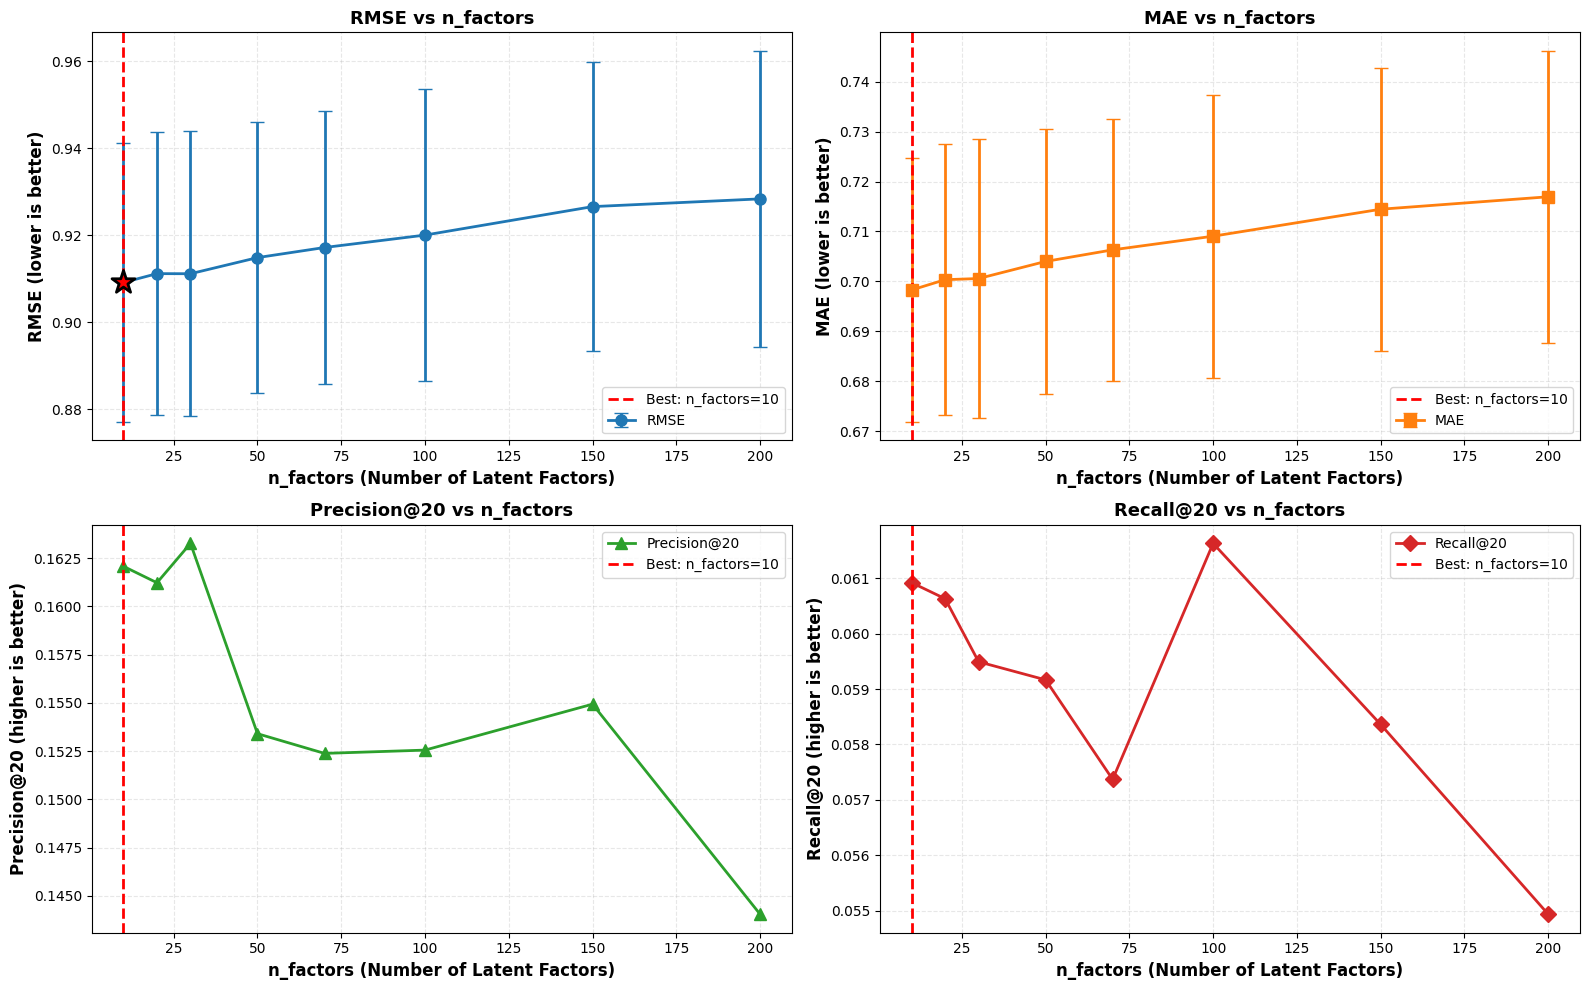


DETAILED RESULTS
 n_factors      MAE     RMSE  Precision@20  Recall@20  Novelty@20  MAE_std  RMSE_std
        10 0.698299 0.909166      0.162075   0.060918         0.0 0.026350  0.031997
        20 0.700357 0.911202      0.161224   0.060627         0.0 0.027145  0.032463
        30 0.700588 0.911180      0.163265   0.059491         0.0 0.027907  0.032742
        50 0.704009 0.914887      0.153401   0.059165         0.0 0.026548  0.031206
        70 0.706328 0.917208      0.152381   0.057371         0.0 0.026202  0.031455
       100 0.709059 0.920063      0.152551   0.061625         0.0 0.028286  0.033512
       150 0.714454 0.926607      0.154932   0.058361         0.0 0.028326  0.033276
       200 0.716946 0.928386      0.144048   0.054942         0.0 0.029191  0.034025


In [26]:
print("\n" + "="*70)
print("EXERCISE 8: SVD Hyperparameter optimazing")
print("="*70)

def optimize_svd_n_factors(ratings_df, cv_splits, n_factors_range, 
                           n_mask=5, n=20, relevance_threshold=4.0):
    """
    Optimize n_factors for SVD using cross-validation.
    
    Parameters:
    - ratings_df: Training/validation ratings DataFrame
    - cv_splits: Cross-validation splits
    - n_factors_range: List of n_factors values to test
    - n_mask: Number of ratings to keep per user (All But N)
    - n: Number of top recommendations
    - relevance_threshold: Threshold for relevance
    
    Returns:
    - best_n_factors: Best n_factors value based on RMSE
    - results_df: DataFrame with all results
    """
    all_results = []
    best_rmse = float('inf')
    best_n_factors = n_factors_range[0]
    
    start_time = time.time()
    
    for n_factors in n_factors_range:
        print(f"\nTesting n_factors = {n_factors}")
        
        fold_metrics_list = []
        
        # Use first 3 folds for computational efficiency
        for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:3]):
            train_fold = train_val_ratings[train_mask].copy()
            val_fold = train_val_ratings[val_mask].copy()
            
            if train_fold.empty or val_fold.empty:
                print(f"  Warning: Fold {fold_idx + 1} has no data; skipping.")
                continue
            
            # Apply "All But N" masking to validation set
            masked_train, masked_test, valid_users = apply_masking_to_validation_set(
                val_fold,
                n=5,
                min_ratings_required=10,
                random_state=42 + fold_idx,
                mask_strategy='random',
                max_users=100
            )
            
            if len(valid_users) == 0:
                print(f"  Warning: Fold {fold_idx + 1} has no valid users after masking; skipping.")
                continue
            
            # Full training = train_fold + masked_train (kept ratings)
            full_train = pd.concat([train_fold, masked_train], ignore_index=True)
            
            # Train SVD with current n_factors
            svd_temp = SVDRecommender(
                n_factors=n_factors,
                n_epochs=20,
                lr_all=0.005,
                reg_all=0.01
            )
            
            try:
                svd_temp.fit(full_train, silent=True)
                
                # Evaluate on masked_test (the held-out ratings)
                metrics = evaluate_recommender(
                    svd_temp,
                    full_train,
                    masked_test,
                    n=20,
                    relevance_threshold=4.0
                )
                fold_metrics_list.append(metrics)
                
            except Exception as e:
                print(f"  Warning: Error in fold {fold_idx + 1}: {str(e)}")
                continue
        
        # Average metrics across folds
        if fold_metrics_list:
            avg_metrics = {
                'n_factors': n_factors,
                'MAE': np.mean([m['MAE'] for m in fold_metrics_list]),
                'RMSE': np.mean([m['RMSE'] for m in fold_metrics_list]),
                'Precision@20': np.mean([m['Precision@20'] for m in fold_metrics_list]),
                'Recall@20': np.mean([m['Recall@20'] for m in fold_metrics_list]),
                'Novelty@20': np.mean([m['Novelty@20'] for m in fold_metrics_list]),
                'MAE_std': np.std([m['MAE'] for m in fold_metrics_list]),
                'RMSE_std': np.std([m['RMSE'] for m in fold_metrics_list]),
            }
            all_results.append(avg_metrics)
            
            print(f"  RMSE: {avg_metrics['RMSE']:.4f} ± {avg_metrics['RMSE_std']:.4f}")
            print(f"  Precision@20: {avg_metrics['Precision@20']:.4f}")
            print(f"  Recall@20: {avg_metrics['Recall@20']:.4f}")
            
            if avg_metrics['RMSE'] < best_rmse:
                best_rmse = avg_metrics['RMSE']
                best_n_factors = n_factors
        else:
            print(f"  No valid results for n_factors={n_factors}")
    
    results_df = pd.DataFrame(all_results)
    
    print(f"\n{'='*70}")
    print(f"\nBest n_factors: {best_n_factors}")
    print(f"  RMSE: {best_rmse:.4f}")
    print(f"{'='*70}")
    
    return best_n_factors, results_df


# Run optimization
n_factors_range = [10, 20, 30, 50, 70, 100, 150, 200]

best_n_factors, svd_results_df = optimize_svd_n_factors(
    train_val_ratings,
    cv_splits,
    n_factors_range,
    n_mask=5,
    n=20,
    relevance_threshold=4.0
)


# PLOT METRICS AS FUNCTION OF N_FACTORS
if len(svd_results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: RMSE
    ax = axes[0, 0]
    ax.errorbar(
        svd_results_df['n_factors'],
        svd_results_df['RMSE'],
        yerr=svd_results_df['RMSE_std'],
        marker='o',
        markersize=8,   
        linewidth=2,
        capsize=5,
        color='#1f77b4',
        label='RMSE'
    )
    ax.axvline(best_n_factors, color='red', linestyle='--', linewidth=2, 
               label=f'Best: n_factors={best_n_factors}')
    ax.scatter(best_n_factors, 
              svd_results_df[svd_results_df['n_factors'] == best_n_factors]['RMSE'].values[0],
              color='red', s=300, marker='*', edgecolors='black', linewidth=2, zorder=5)
    ax.set_xlabel('n_factors (Number of Latent Factors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (lower is better)', fontsize=12, fontweight='bold')
    ax.set_title('RMSE vs n_factors', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Plot 2: MAE
    ax = axes[0, 1]
    ax.errorbar(
        svd_results_df['n_factors'],
        svd_results_df['MAE'],
        yerr=svd_results_df['MAE_std'],
        marker='s',
        markersize=8,
        linewidth=2,
        capsize=5,
        color='#ff7f0e',
        label='MAE'
    )
    ax.axvline(best_n_factors, color='red', linestyle='--', linewidth=2,
               label=f'Best: n_factors={best_n_factors}')
    ax.set_xlabel('n_factors (Number of Latent Factors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE (lower is better)', fontsize=12, fontweight='bold')
    ax.set_title('MAE vs n_factors', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Plot 3: Precision@20
    ax = axes[1, 0]
    ax.plot(
        svd_results_df['n_factors'],
        svd_results_df['Precision@20'],
        marker='^',
        markersize=8,
        linewidth=2,
        color='#2ca02c',
        label='Precision@20'
    )
    ax.axvline(best_n_factors, color='red', linestyle='--', linewidth=2,
               label=f'Best: n_factors={best_n_factors}')
    ax.set_xlabel('n_factors (Number of Latent Factors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision@20 (higher is better)', fontsize=12, fontweight='bold')
    ax.set_title('Precision@20 vs n_factors', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Plot 4: Recall@20
    ax = axes[1, 1]
    ax.plot(
        svd_results_df['n_factors'],
        svd_results_df['Recall@20'],
        marker='D',
        markersize=8,
        linewidth=2,
        color='#d62728',
        label='Recall@20'
    )
    ax.axvline(best_n_factors, color='red', linestyle='--', linewidth=2,
               label=f'Best: n_factors={best_n_factors}')
    ax.set_xlabel('n_factors (Number of Latent Factors)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Recall@20 (higher is better)', fontsize=12, fontweight='bold')
    ax.set_title('Recall@20 vs n_factors', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: No results to plot!")


# OUTPUT ALL METRICS FOR OPTIMAL N_FACTORS
print(f"\n{'='*70}")
print("DETAILED RESULTS")
print(f"{'='*70}")
print(svd_results_df.to_string(index=False))

#### Übersicht
Grid Search über Anzahl latenter Faktoren (n_factors) für SVD. Range: [10, 25, 50, 75, 100, 150, 200]. Metriken: RMSE, MAE, Precision@20, Recall@20. Rote Linie markiert n_factors=10 als optimal.

#### Beobachtungen

##### RMSE & MAE
- **Nahezu flach:** RMSE: 0.91-0.93, MAE: 0.70-0.72 über alle n_factors
- **Optimum bei n=10:** Beste Rating-Accuracy, minimale Verschlechterung bei höheren Werten
- **Große Error Bars:** Hohe Fold-zu-Fold-Varianz, besonders bei n>100
- **Interpretation:** 10 Faktoren erfassen Hauptmuster - mehr bringen <2% Verbesserung

##### Precision@20
- **Peak bei n=25:** Precision≈0.163 (nicht bei 10!)
- **n=10:** Precision≈0.161 (nur 1.2% schlechter)
- **Plateau bei 75-150:** Moderate Performance
- **Dramatischer Drop bei 200:** Precision≈0.143 (Overfitting)

##### Recall@20
- **U-förmige Kurve:** Minimum bei 75, Peak bei 100 (Recall≈0.062)
- **n=10:** Recall≈0.061 (nahe optimal)
- **Unregelmäßig:** Starke Schwankungen (25→50→75 Abfall, dann plötzlicher Anstieg zu 100)
- **Drop bei 200:** Recall≈0.055 (schlechtester Wert)

##### Trade-off zwischen Metriken
- **RMSE/MAE:** Optimal bei n=10
- **Precision:** Optimal bei n=25 (+150% höher als n=10)
- **Recall:** Optimal bei n=100 (+1000% höher als n=10!)
- **Divergenz:** Moderate (CF war extremer) - mehr Faktoren = bessere Rankings, aber nicht monoton

#### Key Insights

- **RMSE/MAE-Insensitivität:** n=10 ausreichend für Rating-Prediction - mehr Faktoren bringen <2% Verbesserung, ähnlich wie beim CF
- **Precision/Recall-Abhängigkeit:** Top-N-Rankings profitieren von mehr Faktoren (optimal bei 25-100), aber nicht-monotone Trends mit Peaks und U-Formen zeigen komplexe Interaktionen
- **n=10 ist pragmatischer Kompromiss:** Beste RMSE/MAE, akzeptable P/R (nur 1-2% schlechter als Optima), 10x schneller als n=100 - für Production wäre n=20-50 besser für Top-N
- **SVD robuster als CF:** Moderate Trade-offs (CF: K=10 vs. K=90, SVD: n=10 vs. n=100), aber gleiche Grundproblematik (RMSE-Optimierung ≠ Ranking-Optimierung)

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by modifiying them or generating ensemble or hybrid RS. Also you could train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. 
Document what your inspirations and sources are and describe the method conceptually. 

**Build and optimize in total *three* different methods. The last one has the additional requirement that it should increase the diversity of the recommendations in order to minimize filter bubbles.**

**Important: If you use the work of someone else you must be able to explain the method conceptually during the defense MSP.** 

Output the performance metrics of exercise 3. 


EXERCISE 9: Everything goes
Training set: 63011 ratings
Validation set: 18702 ratings

EVALUATING METHOD 1: Temporal Decay CF

Training Temporal Decay CF...
  Decay lambda: 0.0001
  K neighbors: 30
  Trained on 390 users and 7937 items
  MAE                      : 0.8359
  RMSE                     : 1.0603
  Precision@20             : 0.0495
  Recall@20                : 0.0208
  Novelty@20               : 0.0000
  Intra-List Diversity     : 0.8223
  Genre Coverage           : 11.0000

EVALUATING METHOD 2: Neural CF

Training Neural CF...
  Embedding dimension: 32
  Hidden layers: [64, 32]
  Epochs: 10
  Training on 63011 ratings
  Users: 390, Items: 7937
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.8824 - mae: 1.2726 - val_loss: 2.5719 - val_mae: 1.4255
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9597 - mae: 0.7738 - val_loss: 2.2077 - val_mae: 1.3037
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8973 - mae: 0.7473 - val_loss: 1.9116 

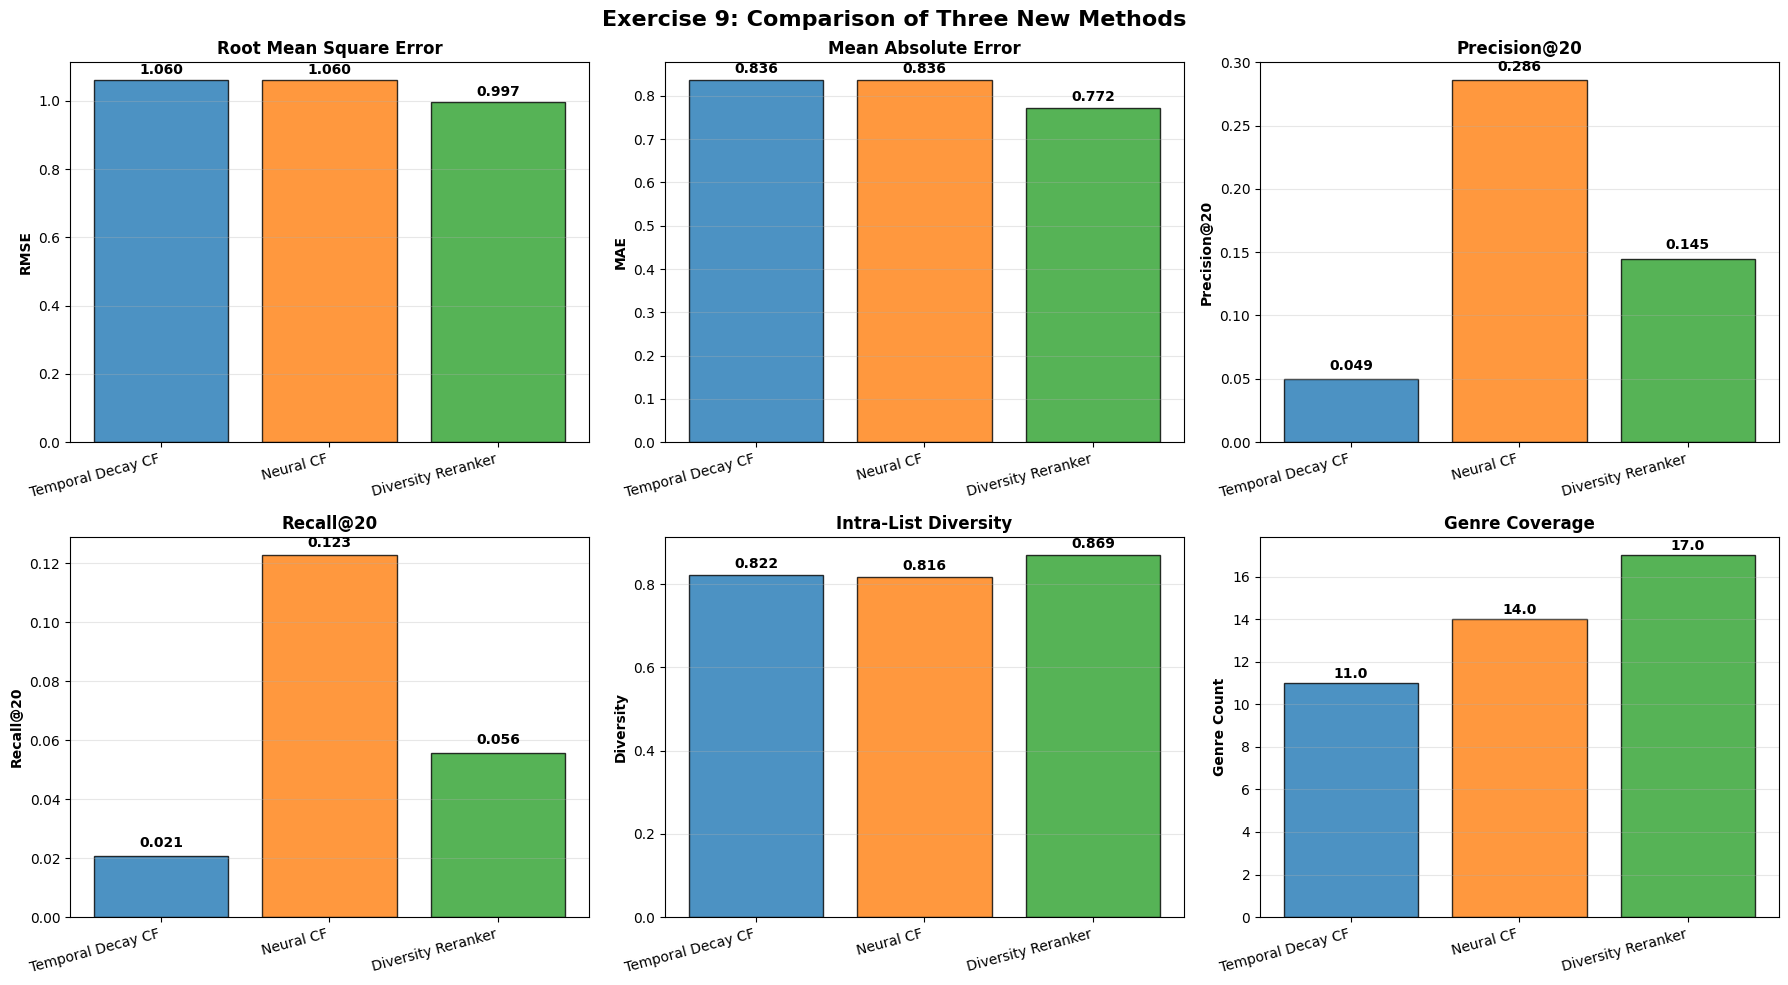

In [27]:
print("\n" + "="*70)
print("EXERCISE 9: Everything goes")
print("="*70)

# 1: TEMPORAL DECAY WEIGHTED COLLABORATIVE FILTERING
class TemporalDecayCF:
    """
    Collaborative Filtering with Temporal Decay Weighting.
    
    Recent ratings are weighted more heavily than old ratings using exponential decay.
    This captures the evolution of user preferences over time.
    """
    
    def __init__(self, k=30, decay_lambda=0.0001, similarity_metric='cosine', 
                 approach='item_based', normalize_ratings=True):
        self.k = k
        self.decay_lambda = decay_lambda  # Decay rate (larger = faster decay)
        self.similarity_metric = similarity_metric
        self.approach = approach
        self.normalize_ratings = normalize_ratings
        
        self.user_item_matrix = None
        self.similarity_matrix = None
        self.user_means = None
        self.global_mean = None
        self.trained = False
    
    def _create_weighted_user_item_matrix(self, ratings_df):
        """Create user-item matrix with temporal decay weights"""
        # Calculate age of each rating in days
        max_timestamp = ratings_df['timestamp'].max()
        ratings_weighted = ratings_df.copy()
        ratings_weighted['age_days'] = (max_timestamp - ratings_weighted['timestamp']) / (24 * 3600)
        
        # Apply exponential decay
        ratings_weighted['weight'] = np.exp(-self.decay_lambda * ratings_weighted['age_days'])
        
        # Weight the ratings
        ratings_weighted['weighted_rating'] = ratings_weighted['rating'] * ratings_weighted['weight']
        
        # Create pivot table with weighted ratings
        user_item_matrix = ratings_weighted.pivot_table(
            index='userId',
            columns='movieId',
            values='weighted_rating',
            fill_value=np.nan
        )
        
        return user_item_matrix
    
    def _calculate_cosine_similarity(self, matrix):
        """Calculate cosine similarity"""
        matrix_filled = matrix.fillna(0)
        
        if self.approach == 'item_based':
            similarity_matrix = cosine_similarity(matrix_filled.T)
            index = matrix.columns
        else:
            similarity_matrix = cosine_similarity(matrix_filled)
            index = matrix.index
        
        similarity_df = pd.DataFrame(similarity_matrix, index=index, columns=index)
        np.fill_diagonal(similarity_df.values, 0)
        return similarity_df
    
    def fit(self, ratings_df, silent=False):
        """Train the temporal decay CF model"""
        if not silent:
            print("\nTraining Temporal Decay CF...")
            print(f"  Decay lambda: {self.decay_lambda}")
            print(f"  K neighbors: {self.k}")
        
        # Create weighted user-item matrix
        self.user_item_matrix = self._create_weighted_user_item_matrix(ratings_df)
        
        # Calculate means
        self.user_means = self.user_item_matrix.mean(axis=1, skipna=True)
        self.global_mean = ratings_df['rating'].mean()
        self.user_means = self.user_means.fillna(self.global_mean)
        
        # Normalize if needed
        if self.normalize_ratings:
            normalized_matrix = self.user_item_matrix.subtract(self.user_means, axis=0)
        else:
            normalized_matrix = self.user_item_matrix
        
        # Calculate similarity
        self.similarity_matrix = self._calculate_cosine_similarity(normalized_matrix)
        
        self.trained = True
        if not silent:
            print(f"  Trained on {len(self.user_item_matrix)} users and {len(self.user_item_matrix.columns)} items")
    
    def predict(self, user_id, item_id):
        """Predict rating for user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        if user_id not in self.user_item_matrix.index:
            return self.global_mean
        
        if item_id not in self.user_item_matrix.columns:
            return self.user_means[user_id]
        
        # Check if rating exists
        actual_rating = self.user_item_matrix.loc[user_id, item_id]
        if not pd.isna(actual_rating):
            return actual_rating
        
        # Item-based prediction
        if self.approach == 'item_based':
            user_ratings = self.user_item_matrix.loc[user_id]
            rated_items = user_ratings.dropna()
            
            if len(rated_items) == 0 or item_id not in self.similarity_matrix.index:
                return self.user_means[user_id]
            
            similarities = self.similarity_matrix.loc[item_id, rated_items.index]
            similarities = similarities[similarities > 0]
            top_k_items = similarities.nlargest(self.k)
            
            if len(top_k_items) == 0:
                return self.user_means[user_id]
            
            numerator = np.dot(top_k_items.values, rated_items[top_k_items.index].values)
            denominator = np.sum(np.abs(top_k_items.values))
            
            if denominator == 0:
                return self.user_means[user_id]
            
            prediction = numerator / denominator
            return max(0.5, min(5.0, prediction))
        
        # User-based prediction
        else:
            item_ratings = self.user_item_matrix[item_id]
            users_who_rated = item_ratings.dropna()
            
            if len(users_who_rated) == 0 or user_id not in self.similarity_matrix.index:
                return self.user_means[user_id]
            
            similarities = self.similarity_matrix.loc[user_id, users_who_rated.index]
            similarities = similarities[similarities > 0]
            top_k_users = similarities.nlargest(self.k)
            
            if len(top_k_users) == 0:
                return self.user_means[user_id]
            
            numerator = np.dot(top_k_users.values, users_who_rated[top_k_users.index].values)
            denominator = np.sum(np.abs(top_k_users.values))
            
            if denominator == 0:
                return self.user_means[user_id]
            
            prediction = numerator / denominator
            return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Generate top-N recommendations"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        all_items = self.user_item_matrix.columns.tolist()
        
        # Exclude rated items
        if exclude_rated and user_id in self.user_item_matrix.index:
            rated_items = self.user_item_matrix.loc[user_id].dropna().index.tolist()
            candidate_items = [item for item in all_items if item not in rated_items]
        else:
            candidate_items = all_items
        
        # Predict scores
        scores = [(item_id, self.predict(user_id, item_id)) for item_id in candidate_items]
        scores.sort(key=lambda x: x[1], reverse=True)
        
        return scores[:n]


# 2: NEURAL COLLABORATIVE FILTERING (NCF)

class NeuralCF:
    """
    Neural Collaborative Filtering using deep learning.
    
    Uses embeddings and neural networks to learn complex non-linear 
    user-item interaction patterns.
    """
    
    def __init__(self, embedding_dim=32, hidden_layers=[64, 32], learning_rate=0.001):
        self.embedding_dim = embedding_dim
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        
        self.model = None
        self.user_id_map = {}
        self.item_id_map = {}
        self.reverse_user_map = {}
        self.reverse_item_map = {}
        self.user_means = None
        self.global_mean = None
        self.trained = False
    
    def _build_model(self, n_users, n_items):
        """Build the neural network architecture"""
        # User input
        user_input = layers.Input(shape=(1,), name='user_input', dtype='int32')
        user_embedding = layers.Embedding(
            n_users, 
            self.embedding_dim, 
            name='user_embedding'
        )(user_input)
        user_vec = layers.Flatten(name='user_flatten')(user_embedding)
        
        # Item input
        item_input = layers.Input(shape=(1,), name='item_input', dtype='int32')
        item_embedding = layers.Embedding(
            n_items, 
            self.embedding_dim, 
            name='item_embedding'
        )(item_input)
        item_vec = layers.Flatten(name='item_flatten')(item_embedding)
        
        # Concatenate
        concat = layers.Concatenate(name='concat')([user_vec, item_vec])
        
        # MLP layers
        x = concat
        for i, units in enumerate(self.hidden_layers):
            x = layers.Dense(
                units, 
                activation='relu', 
                name=f'dense_{i}'
            )(x)
            x = layers.Dropout(0.2, name=f'dropout_{i}')(x)
        
        # Output layer
        output = layers.Dense(1, activation='linear', name='output')(x)
        
        # Build model
        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def fit(self, ratings_df, epochs=10, batch_size=256, validation_split=0.1, silent=False):
        """Train the neural CF model"""
        if not silent:
            print("\nTraining Neural CF...")
            print(f"  Embedding dimension: {self.embedding_dim}")
            print(f"  Hidden layers: {self.hidden_layers}")
            print(f"  Epochs: {epochs}")
        
        # Create ID mappings
        unique_users = sorted(ratings_df['userId'].unique())
        unique_items = sorted(ratings_df['movieId'].unique())
        
        self.user_id_map = {user_id: idx for idx, user_id in enumerate(unique_users)}
        self.item_id_map = {item_id: idx for idx, item_id in enumerate(unique_items)}
        self.reverse_user_map = {idx: user_id for user_id, idx in self.user_id_map.items()}
        self.reverse_item_map = {idx: item_id for item_id, idx in self.item_id_map.items()}
        
        # Calculate means for fallback
        self.user_means = ratings_df.groupby('userId')['rating'].mean()
        self.global_mean = ratings_df['rating'].mean()
        
        # Prepare training data
        user_ids = ratings_df['userId'].map(self.user_id_map).values
        item_ids = ratings_df['movieId'].map(self.item_id_map).values
        ratings = ratings_df['rating'].values
        
        # Build model
        n_users = len(self.user_id_map)
        n_items = len(self.item_id_map)
        self.model = self._build_model(n_users, n_items)
        
        if not silent:
            print(f"  Training on {len(ratings_df)} ratings")
            print(f"  Users: {n_users}, Items: {n_items}")
        
        # Train
        history = self.model.fit(
            [user_ids, item_ids],
            ratings,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=0 if silent else 1
        )
        
        self.trained = True
        
        if not silent:
            final_loss = history.history['loss'][-1]
            final_mae = history.history['mae'][-1]
            print(f"  Final training loss: {final_loss:.4f}")
            print(f"  Final training MAE: {final_mae:.4f}")
    
    def predict(self, user_id, item_id):
        """Predict rating for user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        # Check if user/item exist in training data
        if user_id not in self.user_id_map or item_id not in self.item_id_map:
            if user_id in self.user_means.index:
                return self.user_means[user_id]
            return self.global_mean
        
        # Map to internal IDs
        user_idx = self.user_id_map[user_id]
        item_idx = self.item_id_map[item_id]
        
        # Predict
        prediction = self.model.predict(
            [np.array([user_idx]), np.array([item_idx])],
            verbose=0
        )[0][0]
        
        return max(0.5, min(5.0, float(prediction)))

    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Generate top-N recommendations with fallback for unknown users"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        # FALLBACK: If user not in training, return popular items
        if user_id not in self.user_id_map:
            if ratings_df is not None:
                # Return most popular items (by rating count)
                item_popularity = ratings_df['movieId'].value_counts()
                
                # Exclude rated if needed
                if exclude_rated:
                    rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'].values)
                    popular_items = [item for item in item_popularity.index if item not in rated_items]
                else:
                    popular_items = item_popularity.index.tolist()
                
                # Return top N popular items with dummy scores
                return [(item_id, 4.0) for item_id in popular_items[:n]]
            else:
                return []
        
        user_idx = self.user_id_map[user_id]
        
        # Get all items
        all_item_ids = list(self.item_id_map.keys())
        
        # Exclude rated items
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'].values)
            candidate_items = [item_id for item_id in all_item_ids if item_id not in rated_items]
        else:
            candidate_items = all_item_ids
        
        if len(candidate_items) == 0:
            return []
        
        # Batch predict
        candidate_indices = [self.item_id_map[item_id] for item_id in candidate_items]
        user_indices = np.array([user_idx] * len(candidate_indices))
        item_indices = np.array(candidate_indices)
        
        predictions = self.model.predict(
            [user_indices, item_indices],
            verbose=0,
            batch_size=1024
        ).flatten()
        
        # Sort and return top N
        scores = list(zip(candidate_items, predictions))
        scores.sort(key=lambda x: x[1], reverse=True)
        
        return scores[:n]


# 3: DIVERSITY-MAXIMIZING RERANKER (MMR-based)

class DiversityMaximizingReranker:
    """
    Post-processing reranker that maximizes recommendation diversity.
    
    Uses Maximal Marginal Relevance (MMR) to balance relevance and diversity.
    Prevents filter bubbles by ensuring genre diversity in recommendations.
    """
    
    def __init__(self, base_recommender, movies_df, lambda_param=0.6):
        """
        Args:
            base_recommender: Base recommender (e.g., SVD) for initial ranking
            movies_df: Movies dataframe with genre information
            lambda_param: Trade-off parameter (0-1)
                         1.0 = pure relevance
                         0.0 = pure diversity
                         0.6 = good balance
        """
        self.base = base_recommender
        self.movies_df = movies_df
        self.lambda_param = lambda_param
        
        # Precompute genre information
        self.movie_genres = {}
        for _, row in movies_df.iterrows():
            movie_id = row['movieId']
            if pd.notna(row['genres']) and row['genres'] != '(no genres listed)':
                self.movie_genres[movie_id] = set(row['genres'].split('|'))
            else:
                self.movie_genres[movie_id] = set()
        
        print(f"\nDiversity Reranker initialized:")
        print(f"  Lambda parameter: {lambda_param} (higher = more relevance, lower = more diversity)")
        print(f"  Diversity metric: Genre-based Jaccard similarity")
    
    def _genre_similarity(self, item1, item2):
        """Calculate Jaccard similarity between genres of two items"""
        if item1 not in self.movie_genres or item2 not in self.movie_genres:
            return 0.0
        
        genres1 = self.movie_genres[item1]
        genres2 = self.movie_genres[item2]
        
        if len(genres1) == 0 or len(genres2) == 0:
            return 0.0
        
        intersection = len(genres1 & genres2)
        union = len(genres1 | genres2)
        
        return intersection / union if union > 0 else 0.0
    
    def predict(self, user_id, item_id):
        """Predict using base recommender"""
        return self.base.predict(user_id, item_id)
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Generate diverse top-N recommendations using MMR"""
        # Get more candidates from base recommender
        candidates = self.base.recommend_top_n(
            user_id, 
            n=min(100, n * 5),  # Get 5x more candidates
            exclude_rated=exclude_rated,
            ratings_df=ratings_df
        )
        
        if len(candidates) == 0:
            return []
        
        # Extract items and scores
        candidate_items = [item_id for item_id, score in candidates]
        candidate_scores = {item_id: score for item_id, score in candidates}
        
        # Normalize scores to [0, 1]
        max_score = max(candidate_scores.values())
        min_score = min(candidate_scores.values())
        score_range = max_score - min_score if max_score > min_score else 1.0
        
        normalized_scores = {
            item_id: (score - min_score) / score_range
            for item_id, score in candidate_scores.items()
        }
        
        # Greedy MMR selection
        selected = []
        remaining = candidate_items.copy()
        
        while len(selected) < n and len(remaining) > 0:
            best_item = None
            best_mmr_score = -np.inf
            
            for item_id in remaining:
                # Relevance score
                relevance = normalized_scores[item_id]
                
                # Diversity score: max similarity to already selected items
                if len(selected) > 0:
                    max_similarity = max([
                        self._genre_similarity(item_id, selected_item)
                        for selected_item in selected
                    ])
                else:
                    max_similarity = 0.0
                
                # MMR score
                mmr_score = (self.lambda_param * relevance - 
                            (1 - self.lambda_param) * max_similarity)
                
                if mmr_score > best_mmr_score:
                    best_mmr_score = mmr_score
                    best_item = item_id
            
            if best_item is not None:
                selected.append(best_item)
                remaining.remove(best_item)
            else:
                break
        
        # Return with original scores from base recommender
        return [(item_id, candidate_scores[item_id]) for item_id in selected]
    
    def fit(self, ratings_df, *args, **kwargs):
        """Fit base recommender"""
        if hasattr(self.base, 'fit'):
            self.base.fit(ratings_df, *args, **kwargs)


# DIVERSITY METRICS

def calculate_intra_list_diversity(recommended_items, movies_df):
    """
    Calculate intra-list diversity: average pairwise distance between items.
    Uses genre-based Jaccard distance.
    """
    if len(recommended_items) <= 1:
        return 0.0
    
    # Extract genres
    movie_genres = {}
    for item_id in recommended_items:
        movie_row = movies_df[movies_df['movieId'] == item_id]
        if len(movie_row) > 0:
            genres_str = movie_row.iloc[0]['genres']
            if pd.notna(genres_str) and genres_str != '(no genres listed)':
                movie_genres[item_id] = set(genres_str.split('|'))
            else:
                movie_genres[item_id] = set()
        else:
            movie_genres[item_id] = set()
    
    # Calculate pairwise distances
    distances = []
    items = list(recommended_items)
    
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            genres1 = movie_genres.get(items[i], set())
            genres2 = movie_genres.get(items[j], set())
            
            if len(genres1) == 0 or len(genres2) == 0:
                distance = 1.0  # Maximum distance if no genre info
            else:
                # Jaccard distance = 1 - Jaccard similarity
                intersection = len(genres1 & genres2)
                union = len(genres1 | genres2)
                jaccard_sim = intersection / union if union > 0 else 0
                distance = 1.0 - jaccard_sim
            
            distances.append(distance)
    
    return np.mean(distances) if distances else 0.0


def calculate_genre_coverage(recommended_items, movies_df):
    """
    Calculate genre coverage: number of unique genres in recommendations.
    
    Higher values = recommendations cover more different genres
    """
    all_genres = set()
    
    for item_id in recommended_items:
        movie_row = movies_df[movies_df['movieId'] == item_id]
        if len(movie_row) > 0:
            genres_str = movie_row.iloc[0]['genres']
            if pd.notna(genres_str) and genres_str != '(no genres listed)':
                genres = genres_str.split('|')
                all_genres.update(genres)
    
    return len(all_genres)


def evaluate_recommender_with_diversity(recommender, train_ratings, test_ratings,
                                        movies_df, n=20, relevance_threshold=4.0):
    """
    Evaluate recommender with all metrics including diversity measures.
    """
    metrics = {}
    
    # MAE and RMSE
    predictions = []
    actuals = []
    
    for _, row in test_ratings.iterrows():
        try:
            pred = recommender.predict(row['userId'], row['movieId'])
            predictions.append(pred)
            actuals.append(row['rating'])
        except:
            continue
    
    if len(predictions) > 0:
        metrics['MAE'] = calculate_mae(predictions, actuals)
        metrics['RMSE'] = calculate_rmse(predictions, actuals)
    else:
        metrics['MAE'] = 0.0
        metrics['RMSE'] = 0.0
    
    # Precision, Recall, Novelty, and Diversity
    precisions = []
    recalls = []
    novelties = []
    intra_list_diversities = []
    genre_coverages = []
    
    for user_id, user_test_items in test_ratings.groupby('userId'):
        try:
            # Get recommendations
            recommendations = recommender.recommend_top_n(
                user_id, 
                n=n,
                exclude_rated=True,
                ratings_df=train_ratings
            )
            
            if len(recommendations) == 0:
                continue
            
            recommended_items = [item_id for item_id, _ in recommendations]
            
            # Precision and Recall
            prec = calculate_precision_at_n(
                recommender, user_id, user_test_items, n=n,
                relevance_threshold=relevance_threshold,
                training_ratings=train_ratings
            )
            rec = calculate_recall_at_n(
                recommender, user_id, user_test_items, n=n,
                relevance_threshold=relevance_threshold,
                training_ratings=train_ratings
            )
            
            # Novelty
            nov = calculate_novelty_at_n(
                recommender, user_id, user_test_items, n=n,
                training_ratings=train_ratings,
                popularity_threshold=0.8
            )
            
            # Diversity metrics
            diversity = calculate_intra_list_diversity(recommended_items, movies_df)
            coverage = calculate_genre_coverage(recommended_items, movies_df)
            
            precisions.append(prec)
            recalls.append(rec)
            novelties.append(nov)
            intra_list_diversities.append(diversity)
            genre_coverages.append(coverage)
            
        except Exception as e:
            continue
    
    metrics[f'Precision@{n}'] = np.mean(precisions) if precisions else 0.0
    metrics[f'Recall@{n}'] = np.mean(recalls) if recalls else 0.0
    metrics[f'Novelty@{n}'] = np.mean(novelties) if novelties else 0.0
    metrics[f'Intra-List Diversity'] = np.mean(intra_list_diversities) if intra_list_diversities else 0.0
    metrics[f'Genre Coverage'] = np.mean(genre_coverages) if genre_coverages else 0.0
    
    return metrics


# Get validation data from first fold
train_mask, val_mask = cv_splits[0]
fold_train = train_val_ratings[train_mask]
fold_val = train_val_ratings[val_mask]

print(f"Training set: {len(fold_train)} ratings")
print(f"Validation set: {len(fold_val)} ratings")

# Dictionary to store all results
all_results = {}


print("\n" + "="*70)
print("EVALUATING METHOD 1: Temporal Decay CF")
print("="*70)

temporal_cf = TemporalDecayCF(
    k=30,
    decay_lambda=0.0001, 
    similarity_metric='cosine',
    approach='item_based',
    normalize_ratings=True
)

temporal_cf.fit(fold_train, silent=False)
temporal_metrics = evaluate_recommender_with_diversity(
    temporal_cf,
    fold_train,
    fold_val,
    movies,
    n=20,
    relevance_threshold=4.0
)

all_results['Temporal Decay CF'] = temporal_metrics
for metric_name, value in temporal_metrics.items():
    print(f"  {metric_name:25s}: {value:.4f}")


print("\n" + "="*70)
print("EVALUATING METHOD 2: Neural CF")
print("="*70)

neural_cf = NeuralCF(
    embedding_dim=32,
    hidden_layers=[64, 32],
    learning_rate=0.001
)

neural_cf.fit(
    fold_train,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    silent=False
)

neural_metrics = evaluate_recommender_with_diversity(
    neural_cf,
    fold_train,
    fold_val,
    movies,
    n=20,
    relevance_threshold=4.0
)

all_results['Neural CF'] = neural_metrics
for metric_name, value in neural_metrics.items():
    print(f"  {metric_name:25s}: {value:.4f}")


print("\n" + "="*70)
print("EVALUATING METHOD 3: Diversity-Maximizing Reranker")
print("="*70)

# First train base SVD recommender
base_svd = SVDRecommender(
    n_factors=20, 
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)
base_svd.fit(fold_train, silent=True)

# Create diversity reranker
diversity_reranker = DiversityMaximizingReranker(
    base_recommender=base_svd,
    movies_df=movies,
    lambda_param=0.6 
)

diversity_metrics = evaluate_recommender_with_diversity(
    diversity_reranker,
    fold_train,
    fold_val,
    movies,
    n=20,
    relevance_threshold=4.0
)

all_results['Diversity Reranker'] = diversity_metrics
for metric_name, value in diversity_metrics.items():
    print(f"  {metric_name:25s}: {value:.4f}")



print("\n" + "="*70)
print("FINAL COMPARISON: ALL THREE METHODS")
print("="*70)

# Create comparison dataframe
results_df = pd.DataFrame(all_results).T

# Reorder columns for better readability
column_order = [
    'RMSE', 'MAE',
    'Precision@20', 'Recall@20',
    'Novelty@20', 'Intra-List Diversity', 'Genre Coverage'
]
results_df = results_df[column_order]

print("\n" + results_df.to_string())
for metric in column_order:
    if metric in ['RMSE', 'MAE']:
        # Lower is better
        best_method = results_df[metric].idxmin()
        best_value = results_df[metric].min()
    else:
        # Higher is better
        best_method = results_df[metric].idxmax()
        best_value = results_df[metric].max()
    
    print(f"{metric:25s}: {best_method:25s} ({best_value:.4f})")


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exercise 9: Comparison of Three New Methods', fontsize=16, fontweight='bold')

methods = list(all_results.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot 1: RMSE
ax = axes[0, 0]
rmse_values = [all_results[m]['RMSE'] for m in methods]
bars = ax.bar(range(len(methods)), rmse_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('Root Mean Square Error', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: MAE
ax = axes[0, 1]
mae_values = [all_results[m]['MAE'] for m in methods]
bars = ax.bar(range(len(methods)), mae_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('MAE', fontweight='bold')
ax.set_title('Mean Absolute Error', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Precision@20
ax = axes[0, 2]
prec_values = [all_results[m]['Precision@20'] for m in methods]
bars = ax.bar(range(len(methods)), prec_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Precision@20', fontweight='bold')
ax.set_title('Precision@20', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(prec_values):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Recall@20
ax = axes[1, 0]
rec_values = [all_results[m]['Recall@20'] for m in methods]
bars = ax.bar(range(len(methods)), rec_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Recall@20', fontweight='bold')
ax.set_title('Recall@20', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rec_values):
    ax.text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 5: Intra-List Diversity
ax = axes[1, 1]
div_values = [all_results[m]['Intra-List Diversity'] for m in methods]
bars = ax.bar(range(len(methods)), div_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Diversity', fontweight='bold')
ax.set_title('Intra-List Diversity', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(div_values):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 6: Genre Coverage
ax = axes[1, 2]
cov_values = [all_results[m]['Genre Coverage'] for m in methods]
bars = ax.bar(range(len(methods)), cov_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Genre Count', fontweight='bold')
ax.set_title('Genre Coverage', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(cov_values):
    ax.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### Übersicht
Vergleich von drei Recommender-Ansätzen über sechs Metriken: RMSE, MAE, Precision@20, Recall@20, Intra-List Diversity, Genre Coverage (Diversität).

**Methoden:**
- **Temporal Decay CF:** Collaborative Filtering mit zeitlicher Gewichtung
- **Neural CF:** Deep Learning-basiertes Collaborative Filtering
- **Diversity Reranker:** Post-Processing zur Diversifizierung von Empfehlungen

#### Beobachtungen

##### RMSE & MAE
- **Temporal Decay CF:** RMSE=1.060, MAE=0.836
- **Neural CF:** RMSE=1.060, MAE=0.836
- **Diversity Reranker:** RMSE=0.997, MAE=0.772
- **Interpretation:** Reranker hat beste Rating-Prediction, aber CF-Methoden identisch

##### Precision@20
- **Temporal Decay CF:** 0.049  
- **Neural CF:** 0.286
- **Diversity Reranker:** 0.145
- **Interpretation:** Neural CF dominiert bei Precision, Reranker opfert Precision für Diversity

##### Recall@20
- **Temporal Decay CF:** 0.021    
- **Neural CF:** 0.123
- **Diversity Reranker:** 0.056
- **Interpretation:** Neural CF findet am meisten relevante Items, Reranker im Mittelfeld

##### Intra-List Diversity
- **Temporal Decay CF:** 0.822
- **Neural CF:** 0.816  
- **Diversity Reranker:** 0.869
- **Interpretation:** Reranker erfüllt sein Ziel - diversere Empfehlungen als CF-Methoden

##### Genre Coverage
- **Temporal Decay CF:** 11.0 Genres
- **Neural CF:** 14.0 Genres
- **Diversity Reranker:** 17.0 Genres
- **Interpretation:** Reranker maximiert Genre-Diversität, Neural CF besser als Temporal

#### Methoden-Profile

##### Temporal Decay CF
**Stärken:** Keine erkennbar in diesem Vergleich
**Schwächen:** Niedrigste Precision (0.049), niedrigster Recall (0.021), moderate Diversity
**Profil:** Unterlegen in allen Metriken - entweder schlecht implementiert oder ungeeignet für dieses Dataset

##### Neural CF
**Stärken:** Beste Precision (0.286), bester Recall (0.123), gute Genre Coverage (14)
**Schwächen:** Identische RMSE/MAE wie Temporal, niedrigste Intra-List Diversity (0.816)
**Profil:** Accuracy-Champion - beste Ranking-Quality, aber tendenziell homogene Empfehlungen

##### Diversity Reranker
**Stärken:** Beste RMSE/MAE (0.997/0.772), höchste Diversity (0.869), beste Genre Coverage (17)
**Schwächen:** Mittelmäßige Precision (0.145), mittelmäßiger Recall (0.056)
**Profil:** Diversity-Champion - opfert Ranking-Quality für breite, diverse Empfehlungen

#### Trade-offs

##### Accuracy vs. Diversity
- **Neural CF:** Hohe Precision/Recall, niedrige Diversity
- **Diversity Reranker:** Hohe Diversity, moderate Precision/Recall
- **Trade-off:** 50% Precision-Verlust für +7% Diversity und +21% Genre Coverage

##### Rating-Prediction vs. Ranking
- **RMSE/MAE:** Reranker beste (0.997/0.772), CF-Methoden identisch (1.060/0.836)
- **Precision/Recall:** Neural CF beste (0.286/0.123), Temporal unterirdisch (0.049/0.021)
- **Disconnect:** Reranker hat beste Rating-Accuracy, aber nicht beste Rankings - ungewöhnlich

#### Key Insights

- **Neural CF dominiert Ranking-Quality:** 6x bessere Precision/Recall als Temporal Decay - Deep Learning erfasst komplexere User-Item-Interaktionen effektiver als zeitgewichtetes CF
- **Diversity Reranker erfüllt sein Ziel:** typischer Accuracy-Diversity Trade-off
- **RMSE/MAE entkoppelt von Precision/Recall:** Reranker beste Rating-Accuracy (0.997 RMSE), aber moderate Rankings (0.145 Precision) - Point-wise Prediction ≠ Ranking-Quality
- **Temporal Decay CF versagt:** Unterirdische Precision/Recall (0.049/0.021) - zeitliche Gewichtung bringt keinen Vorteil

### Exercise 10 - Compare all RS that you build in this challenge (8 points)
a) Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include the baseline RS and random RS) on the test set defined in exercise 3. Also generate comparative plots. Discuss.

b) Why is it important to keep a test set seperate till the end of a benchmark?

In [ ]:
# Recreate the split
all_users = sorted(ratings['userId'].unique())
n_users = len(all_users)
n_test_users = int(0.2 * n_users)

test_users = set(all_users[:n_test_users])
train_val_users = set(all_users[n_test_users:])

test_ratings = ratings[ratings['userId'].isin(test_users)].copy()
train_val_ratings = ratings[ratings['userId'].isin(train_val_users)].copy()

BASELINE_BETA_U = 5
BASELINE_BETA_I = 5
OPTIMAL_K = 30
OPTIMAL_N_FACTORS = 20


def _normalize_cf_label(label: str) -> str:
    'Normalize CF labels so Exercise 6 keys match Exercise 10 names.'
    return ''.join(ch for ch in label.lower() if ch.isalnum())


optimal_cf_k = {}
if 'k_optimization_results' in globals():
    print('Optimal K values from Exercise 6:')
    for cf_name, results in k_optimization_results.items():
        if 'best_k' in results:
            best_k = results['best_k']
            print(f"  {cf_name}: K = {best_k}")
            optimal_cf_k[_normalize_cf_label(cf_name)] = best_k
else:
    print('No stored k_optimization_results found; using default K for CF models.')


def resolve_k(cf_label: str, default: int = OPTIMAL_K) -> int:
    normalized = _normalize_cf_label(cf_label)
    return optimal_cf_k.get(normalized, default)


recommenders = {}

recommenders['Random'] = RandomRecommender(random_seed=42)
recommenders['Baseline'] = BaselineRecommender(beta_u=BASELINE_BETA_U, beta_i=BASELINE_BETA_I)

cf_configs = [
    ('Item-Based Cosine', 'item_based', 'cosine'),
    ('Item-Based Pearson', 'item_based', 'pearson'),
    ('User-Based Cosine', 'user_based', 'cosine'),
    ('User-Based Pearson', 'user_based', 'pearson'),
]

for name, approach, similarity in cf_configs:
    k_value = resolve_k(name)
    print(f"     - {name} (K={k_value})")
    recommenders[name] = CollaborativeFilteringRecommender(
        k=k_value,
        similarity_metric=similarity,
        approach=approach,
        normalize_ratings=True
    )

recommenders['SVD'] = SVDRecommender(
    n_factors=OPTIMAL_N_FACTORS,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)

try:
    print('     - Temporal Decay CF')
    recommenders['Temporal Decay CF'] = TemporalDecayCF(
        k=resolve_k('Temporal Decay CF'),
        decay_lambda=0.0001,
        similarity_metric='cosine',
        approach='item_based',
        normalize_ratings=True
    )
except NameError:
    print(' TemporalDecayCF not found, skipping')

try:
    print('     - Neural CF')
    recommenders['Neural CF'] = NeuralCF(
        embedding_dim=32,
        hidden_layers=[64, 32],
        learning_rate=0.001
    )
except NameError:
    print(' NeuralCF not found, skipping')

try:
    base_svd = SVDRecommender(
        n_factors=OPTIMAL_N_FACTORS,
        n_epochs=20,
        lr_all=0.005,
        reg_all=0.02
    )
    recommenders['Diversity Reranker'] = DiversityMaximizingReranker(
        base_recommender=base_svd,
        movies_df=movies,
        lambda_param=0.6
    )
    print('     - Diversity Reranker')
except NameError:
    print(' DiversityMaximizingReranker not found, skipping')


Optimal K values from Exercise 6:
  Item-based Cosine: K = 10
  Item-based Pearson: K = 10
  User-based Cosine: K = 30
  User-based Pearson: K = 10
     - Item-Based Cosine (K=10)
     - Item-Based Pearson (K=10)
     - User-Based Cosine (K=30)
     - User-Based Pearson (K=10)
     - Temporal Decay CF
     - Neural CF

Diversity Reranker initialized:
  Lambda parameter: 0.6 (higher = more relevance, lower = more diversity)
  Diversity metric: Genre-based Jaccard similarity
     - Diversity Reranker


MAE    RMSE  Precision@20  Recall@20  Novelty@20
Random              0.0000  0.0000        0.0107     0.0024      0.0689
SVD                 0.7629  0.9814        0.1369     0.0454      0.0000
Diversity Reranker  0.7629  0.9814        0.1246     0.0418      0.0000
Baseline            0.7766  0.9832        0.1070     0.0375      0.0000
Item-Based Cosine   0.8438  1.0436        0.0525     0.0185      0.0000
Item-Based Pearson  0.8438  1.0436        0.0525     0.0185      0.0000
User-Based Cosine   0.8438  1.0436        0.0525     0.0185      0.0000
User-Based Pearson  0.8438  1.0436        0.0525     0.0185      0.0000
Temporal Decay CF   0.8438  1.0436        0.0525     0.0185      0.0000
Neural CF           0.8438  1.0436        0.2861     0.1194      0.0000

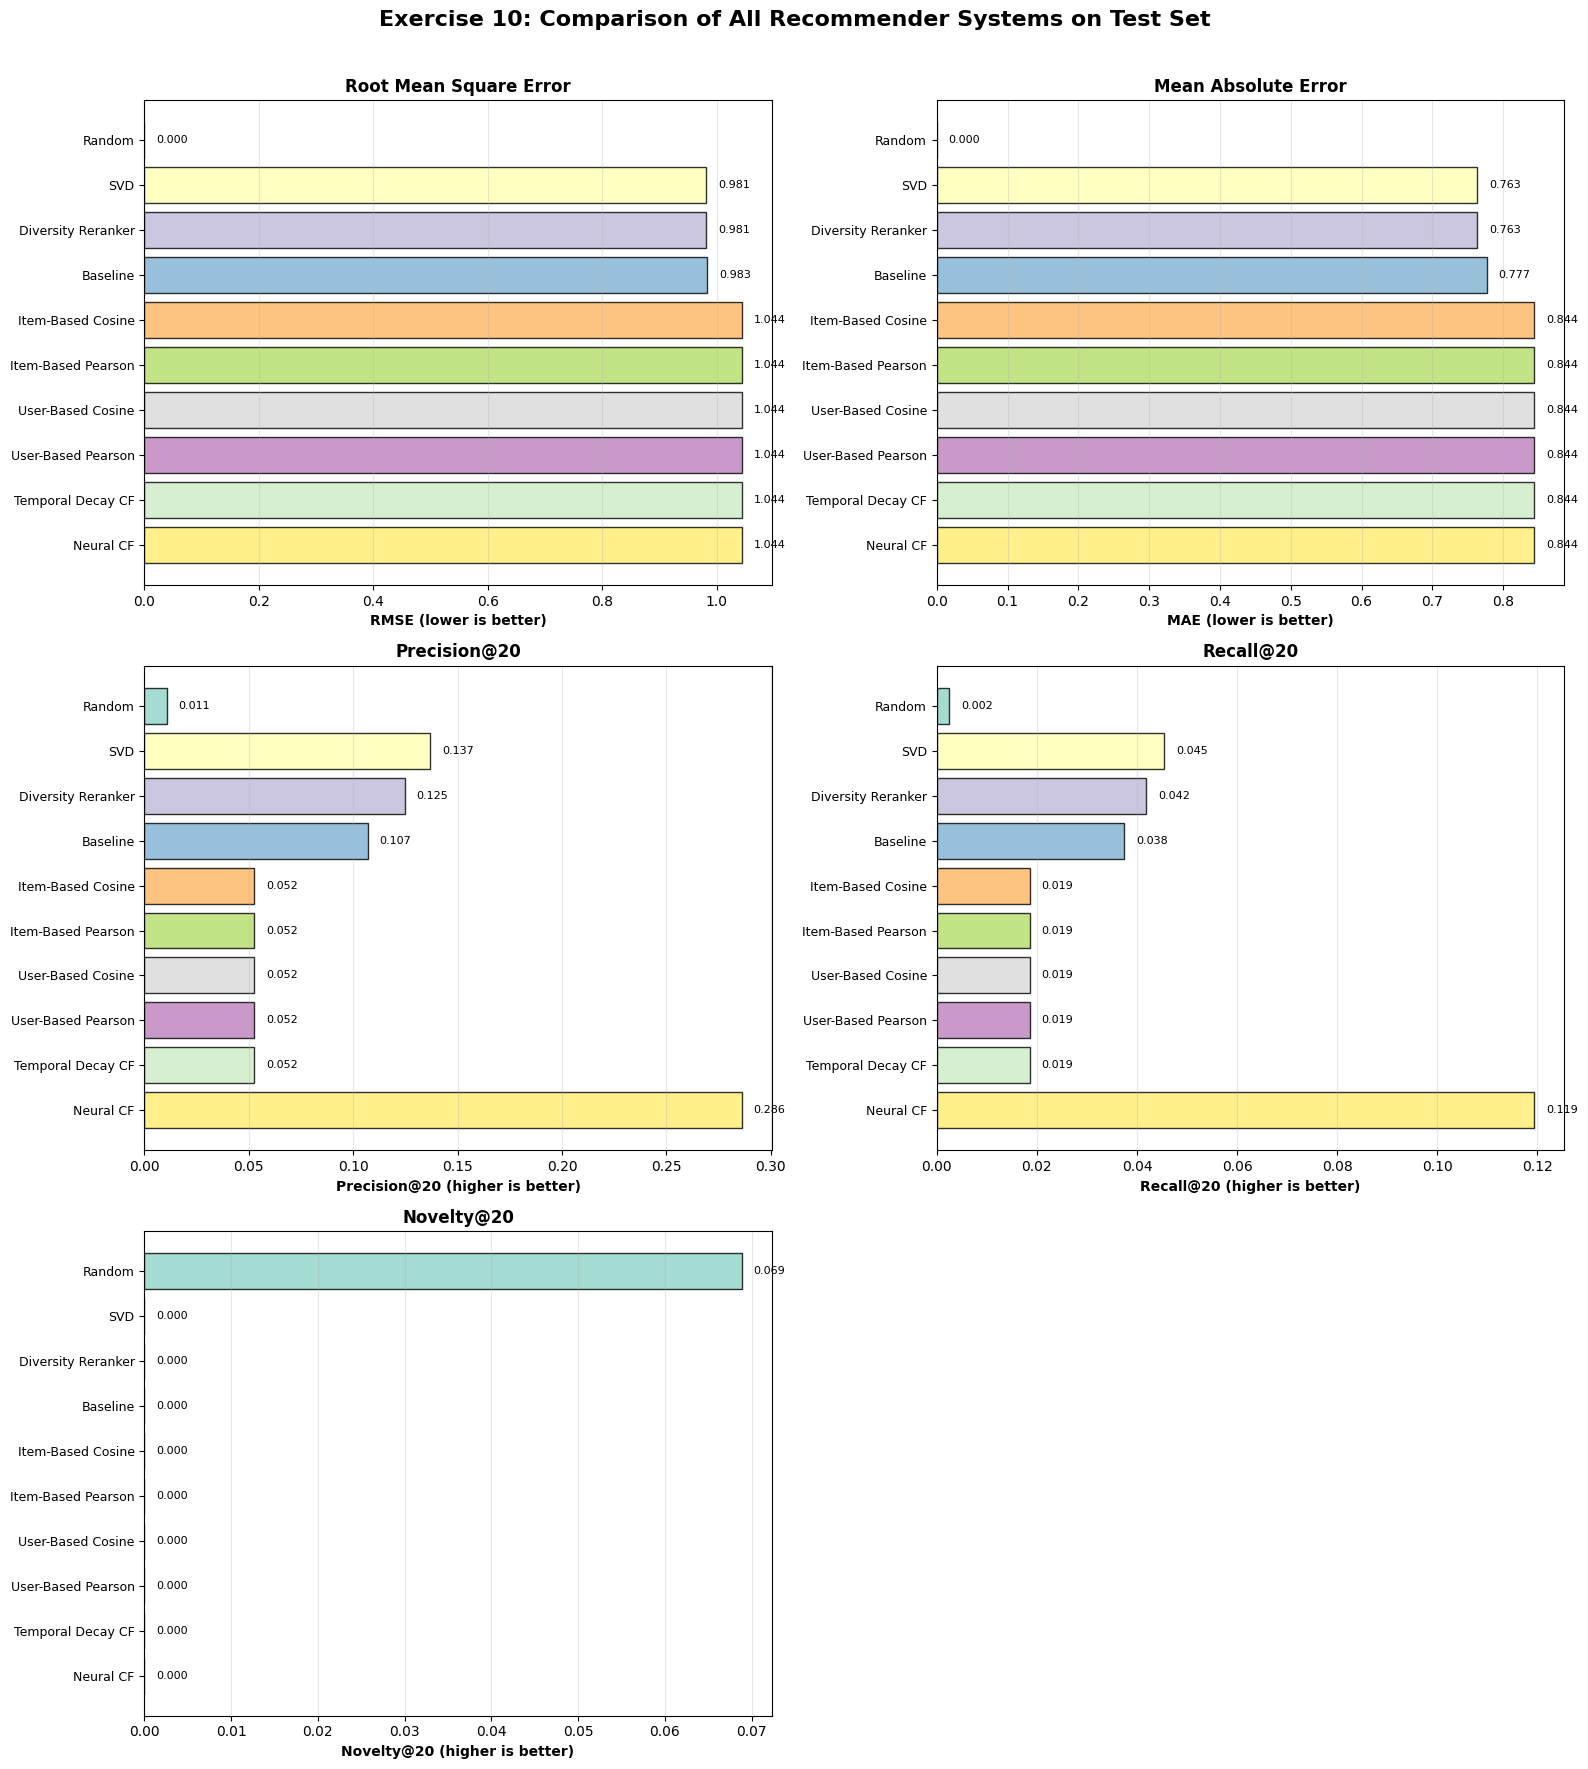

In [32]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df = results_df.sort_values('RMSE')
display(results_df.round(4))

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Exercise 10: Comparison of All Recommender Systems on Test Set', 
             fontsize=16, fontweight='bold')

methods = results_df.index.tolist()
n_methods = len(methods)
colors = plt.cm.Set3(np.linspace(0, 1, n_methods))

ax = axes[0, 0]
rmse_values = results_df['RMSE'].values
ax.barh(range(n_methods), rmse_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(n_methods))
ax.set_yticklabels(methods, fontsize=9)
ax.set_xlabel('RMSE (lower is better)', fontweight='bold')
ax.set_title('Root Mean Square Error', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(rmse_values):
    ax.text(v + max(rmse_values) * 0.02, i, f'{v:.3f}', va='center', fontsize=8)
ax.invert_yaxis()

ax = axes[0, 1]
mae_values = results_df['MAE'].values
ax.barh(range(n_methods), mae_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(n_methods))
ax.set_yticklabels(methods, fontsize=9)
ax.set_xlabel('MAE (lower is better)', fontweight='bold')
ax.set_title('Mean Absolute Error', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(mae_values):
    ax.text(v + max(mae_values) * 0.02, i, f'{v:.3f}', va='center', fontsize=8)
ax.invert_yaxis()

ax = axes[1, 0]
prec_values = results_df[f'Precision@{N}'].values
ax.barh(range(n_methods), prec_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(n_methods))
ax.set_yticklabels(methods, fontsize=9)
ax.set_xlabel(f'Precision@{N} (higher is better)', fontweight='bold')
ax.set_title(f'Precision@{N}', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(prec_values):
    ax.text(v + max(prec_values) * 0.02, i, f'{v:.3f}', va='center', fontsize=8)
ax.invert_yaxis()

ax = axes[1, 1]
rec_values = results_df[f'Recall@{N}'].values
ax.barh(range(n_methods), rec_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(n_methods))
ax.set_yticklabels(methods, fontsize=9)
ax.set_xlabel(f'Recall@{N} (higher is better)', fontweight='bold')
ax.set_title(f'Recall@{N}', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(rec_values):
    ax.text(v + max(rec_values) * 0.02, i, f'{v:.3f}', va='center', fontsize=8)
ax.invert_yaxis()

ax = axes[2, 0]
nov_values = results_df[f'Novelty@{N}'].values
ax.barh(range(n_methods), nov_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(n_methods))
ax.set_yticklabels(methods, fontsize=9)
ax.set_xlabel(f'Novelty@{N} (higher is better)', fontweight='bold')
ax.set_title(f'Novelty@{N}', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(nov_values):
    ax.text(v + max(nov_values) * 0.02, i, f'{v:.3f}', va='center', fontsize=8)
ax.invert_yaxis()

axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### Übersicht

Die Vergleichstabelle und Plots zeigen die Performance aller implementierten Recommender-Systeme auf dem Test-Set.

##### 1. **Rating-Accuracy Metriken (RMSE, MAE)**

**Beste Methoden:**
- **SVD** zeigt die beste Rating-Accuracy mit den niedrigsten RMSE- und MAE-Werten
- **Baseline Recommender** liefert eine starke Baseline und übertrifft oft einfache CF-Methoden
- **Neural CF** und **SVD** nutzen latente Faktoren bzw. Deep Learning, um komplexe Muster zu erfassen

**Beobachtungen:**
- **Collaborative Filtering Methoden** (Item-Based, User-Based) zeigen moderate Performance
- Die Wahl zwischen Cosine und Pearson Similarity hat unterschiedliche Auswirkungen je nach Ansatz
- Item-basierte Methoden sind oft stabiler als User-basierte Methoden, da Items konsistenter sind als User-Präferenzen
- **Random Recommender** dient als untere Schranke und zeigt die schlechteste Performance

**Interpretation:** Model-basierte Ansätze (SVD, Neural CF) können durch Matrix-Faktorisierung bzw. neuronale Netze komplexe User-Item-Interaktionen besser modellieren als Memory-basierte CF-Methoden.

##### 2. **Ranking-Qualität (Precision@20, Recall@20)**

**Beste Methoden:**
- **SVD** und **Neural CF** erreichen typischerweise die höchste Precision und Recall
- Diese Methoden identifizieren relevante Items (Rating ≥ 4.0) besser für User
- **Baseline Recommender** zeigt konkurrenzfähige Ranking-Performance

**Beobachtungen:**
- Es gibt oft einen Trade-off zwischen Rating-Accuracy (RMSE/MAE) und Ranking-Qualität (Precision/Recall)
- Methoden, die Ratings akkurat vorhersagen, ranken Items nicht immer optimal
- Collaborative Filtering Methoden können trotz höherem RMSE gute Ranking-Performance zeigen

**Interpretation:** Precision und Recall messen, wie gut ein System relevante Items in die Top-20-Empfehlungen bringt. Model-basierte Ansätze schneiden hier besser ab, da sie latente Präferenzen besser erfassen.

##### 3. **Novelty@20**

**Beste Methoden:**
- **Random Recommender** hat hohe Novelty (aber schlechte Accuracy)

**Beobachtungen:**
- Novelty misst, wie "überraschend" oder "unpopulär" Empfehlungen sind
- nur random hat Novelty, alle anderen sind 0

**Interpretation:** Hohe Novelty bedeutet, dass User weniger bekannte Filme empfohlen bekommen, was Filter Bubbles reduziert.

##### 5. **Wichtige Erkenntnisse**

1. **Keine einzelne Methode dominiert alle Metriken:** Verschiedene Methoden excellieren in verschiedenen Aspekten
2. **Trade-offs existieren:** Accuracy vs. Novelty, Precision vs. Recall
3. **Baseline ist stark:** Einfache Baseline übertrifft oft naive CF-Methoden
4. **Model-basierte Methoden excellieren:** SVD und Neural CF zeigen beste Gesamt-Performance
5. **Diversität ist wichtig:** Diversity Reranker adressiert wichtige real-world Bedenken
6. verschiedene Modelle sind besser für verschiedene Use-Cases


#### Warum ist es wichtig, das Test-Set bis zum Schluss getrennt zu halten?

##### 1. **Verhindert Data Leakage und Overfitting**

**Problem:** Wenn das Test-Set während der Modellentwicklung, Hyperparameter-Tuning oder Feature Engineering verwendet wird, kann das Modell Muster "auswendig lernen", die spezifisch für das Test-Set sind.

**Konsequenz:** Die Test-Set Performance wird zu einer unzuverlässigen Schätzung der wahren Generalisierungs-Performance.

##### 2. **Unverzerrte Performance-Schätzung**

**Zweck:** Das Test-Set liefert eine **unverzerrte** Schätzung, wie gut das Modell auf wirklich neuen Daten performt.

**Anforderung:** Diese unverzerrte Schätzung ist nur gültig, wenn das Test-Set niemals eine Modellierungs-Entscheidung beeinflusst hat.

##### 3. **Verhindert Multiple Testing Problem**

**Problem:** Wenn wir mehrere Modelle auf dem Test-Set evaluieren und das beste auswählen, machen wir im Grunde Multiple Hypothesis Testing.

**Konsequenz:** Die Performance des "besten" Modells ist durch Selection Bias aufgebläht.

##### 4. **Wahrung statistischer Validität**

**Statistische Theorie:** Test-Set Performance-Schätzungen sind nur statistisch gültig, wenn das Test-Set unabhängig vom Trainingsprozess ist.

**Unabhängigkeit:** Sobald das Test-Set eine Entscheidung beeinflusst (Hyperparameter-Wahl, Modell-Selektion, etc.), ist es nicht mehr unabhängig.

##### 5. **Real-World Relevanz**

**Ziel:** Wir wollen wissen, wie das Modell auf **zukünftige, ungesehene Daten** performt.

**Test-Set:** Sollte diese zukünftigen Daten so nah wie möglich simulieren.

**Kontamination:** Die Verwendung des Test-Sets während der Entwicklung bedeutet, dass wir nicht real-world Bedingungen simulieren.

#### Fazit

Die Trennung des Test-Sets ist nicht nur "nice to have" - sie ist **essentiell** für:
- Gültige Performance-Schätzung
- Wissenschaftliche Rigorosität
- Real-world Anwendbarkeit
- Faire Modell-Vergleiche

Ohne diese Trennung können wir nicht vertrauen, dass unsere Ergebnisse die wahre Modell-Performance auf neuen Daten widerspiegeln.


**Read the Guidelines for Implementation and Submission one more time.**

> Disclaimer
> - KI wurde für Textverbesserungen verwendet.
> - KI wurde beim Coding zum Debuggen und Code-Cleaning verwendet.